# Recommendation System using Graph Representation Learning

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torch_geometric.data import Data, Dataset, HeteroData
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

import pandas as pd
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

import os
import urllib.request
from tqdm import tqdm
import zipfile


## Introduction and Background

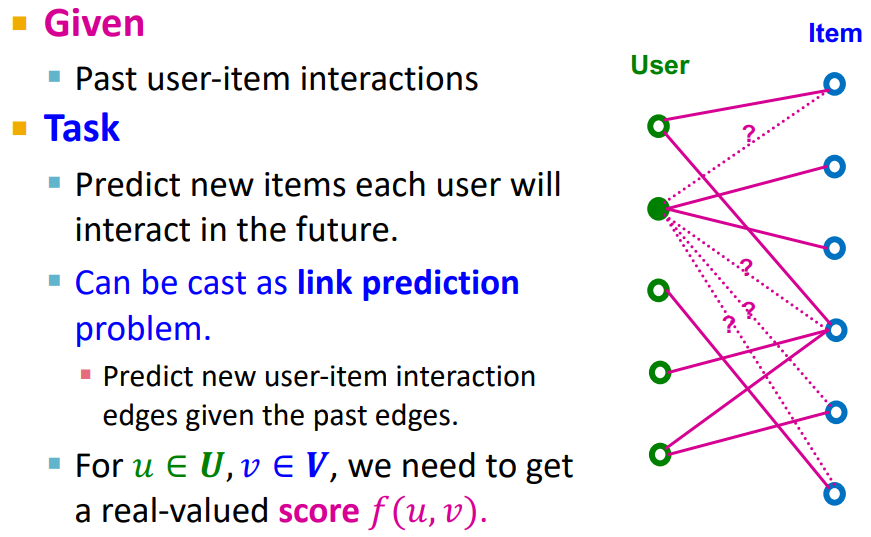

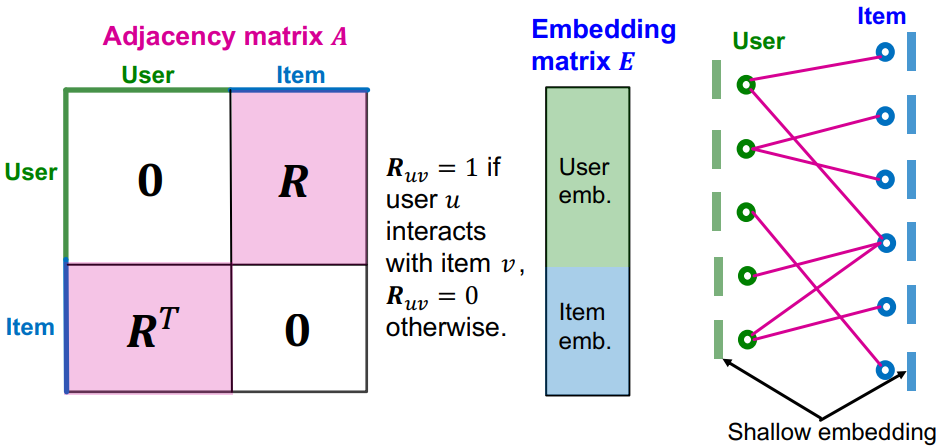

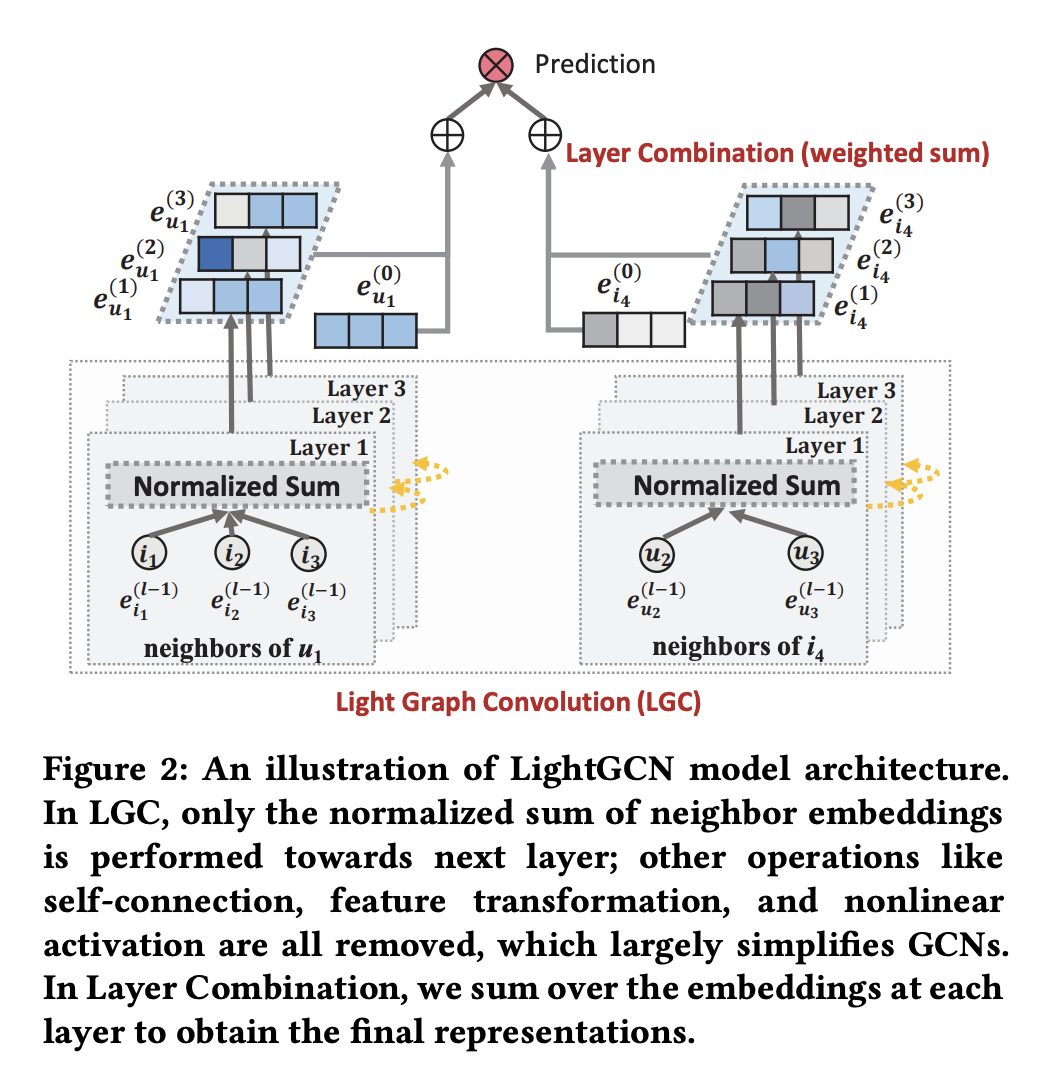

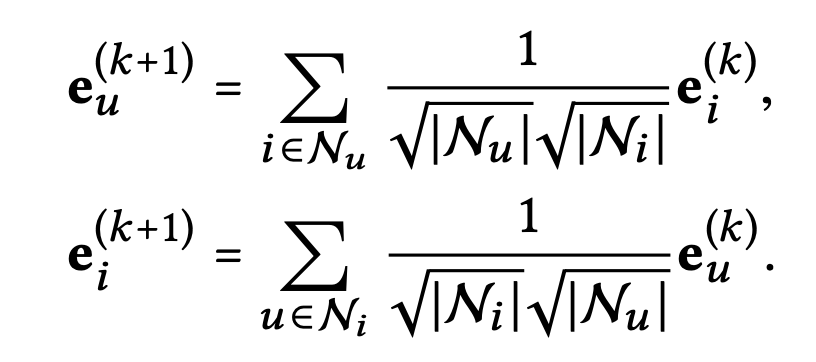

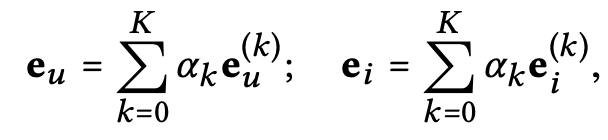


## Data Prep

In [2]:
def download_dataset(name):
    """Download dataset if not already available."""
    if name.lower() == 'movielens-100k':
        url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
        zip_path = "ml-100k.zip"
        extract_path = "ml-100k"
        
        if not os.path.exists(extract_path):
            print(f"Downloading {name} dataset...")
            urllib.request.urlretrieve(url, zip_path)
            
            print("Extracting files...")
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall('.')
            
            if os.path.exists(zip_path):
                os.remove(zip_path)
        
        return extract_path
    
    elif name.lower() == 'movielens-1m':
        url = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
        zip_path = "ml-1m.zip"
        extract_path = "ml-1m"
        
        if not os.path.exists(extract_path):
            print(f"Downloading {name} dataset...")
            urllib.request.urlretrieve(url, zip_path)
            
            print("Extracting files...")
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall('.')
            
            if os.path.exists(zip_path):
                os.remove(zip_path)
        
        return extract_path
    
    elif name.lower() == 'yelp':
        # Assuming yelp dataset is in ../yelp/Yelp-JSON/Yelp JSON
        extract_path = os.path.join("..", "yelp", "Yelp-JSON", "Yelp JSON") 
        if not os.path.exists(extract_path):
            # If you have a specific path where Yelp data is stored, you can set it here.
            # For example: extract_path = "C:/path/to/your/Yelp-JSON"
            raise FileNotFoundError(f"Yelp dataset not found at {extract_path}. "
                                    f"Please ensure the Yelp JSON files are in the correct directory.")
        print(f"Using Yelp dataset from {extract_path}")
        return extract_path
    
    else:
        raise ValueError(f"Dataset {name} not supported")

def load_movielens_100k(path):
    """Load MovieLens-100K dataset and return user-item interactions."""
    data_file = os.path.join(path, 'u.data')
    
    df = pd.read_csv(data_file, sep='\t', header=None, 
                    names=['user_id', 'item_id', 'rating', 'timestamp'])
    
    # positive interactions (rating >= 4)
    df_positive = df[df['rating'] >= 4].copy()
    
    # Remap IDs from 0
    unique_users = df_positive['user_id'].unique()
    unique_items = df_positive['item_id'].unique()
    
    user_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_users)}
    item_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_items)}
    
    df_positive['user_id'] = df_positive['user_id'].map(user_id_map)
    df_positive['item_id'] = df_positive['item_id'].map(item_id_map)

    user_nodes = df_positive['user_id'].values
    item_nodes = df_positive['item_id'].values
    
    return user_nodes, item_nodes, len(unique_users), len(unique_items)

def load_movielens_1m(path):
    """Load MovieLens-1M dataset and return user-item interactions."""
    data_file = os.path.join(path, 'ratings.dat')
    
    df = pd.read_csv(data_file, sep='::', header=None, engine='python',
                    names=['user_id', 'item_id', 'rating', 'timestamp'])
    print(len(df))
    # positive interactions (rating >= 4)
    df_positive = df[df['rating'] >= 4].copy()
    
    # Remap IDs from 0
    unique_users = df_positive['user_id'].unique()
    unique_items = df_positive['item_id'].unique()
    
    user_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_users)}
    item_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_items)}
    
    df_positive['user_id'] = df_positive['user_id'].map(user_id_map)
    df_positive['item_id'] = df_positive['item_id'].map(item_id_map)
    
    user_nodes = df_positive['user_id'].values
    item_nodes = df_positive['item_id'].values
    
    return user_nodes, item_nodes, len(unique_users), len(unique_items)


In [3]:
import json
import gc

def process_yelp_data_in_chunks(file_path, chunk_size=10000, output_dir="processed_chunks"):
    """Process large JSON files in chunks to avoid memory errors."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    chunk_num = 0
    current_chunk = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in tqdm(enumerate(f)):
            try:
                data = json.loads(line)
                current_chunk.append(data)
            except json.JSONDecodeError:
                continue

            if len(current_chunk) >= chunk_size:
                df_chunk = pd.DataFrame(current_chunk)

                # Save chunk to disk (either as CSV or as pickle)
                chunk_file = os.path.join(
                    output_dir, f'chunk_{str(chunk_num).zfill(3)}.parquet')
                df_chunk.to_parquet(chunk_file, index=False)

                # Clear memory
                del df_chunk
                current_chunk = []
                gc.collect()
                chunk_num += 1

        if current_chunk:
            df_chunk = pd.DataFrame(current_chunk)
            chunk_file = os.path.join(output_dir, f'chunk_{str(chunk_num).zfill(3)}.parquet')
            df_chunk.to_parquet(chunk_file, index=False)
            del df_chunk
            current_chunk = []
            gc.collect()
            chunk_num += 1
    print(f"Processed {chunk_num} chunks and saved to {output_dir}")


def create_graph_from_chunks(chunks_dir, user_mapping_file=None, business_mapping_file=None):
    """Create a PyG graph from processed chunks."""
    if user_mapping_file and os.path.exists(user_mapping_file):
        user_to_idx = pd.read_pickle(user_mapping_file)
    else:
        user_to_idx = {}

    if business_mapping_file and os.path.exists(business_mapping_file):
        business_to_idx = pd.read_pickle(business_mapping_file)
    else:
        business_to_idx = {}

    edge_index = [[], []]  # [user_indices, business_indices]
    # edge_attr = []  # ratings

    for chunk_file in tqdm(sorted(os.listdir(chunks_dir))):
        if not chunk_file.endswith('.parquet'):
            continue

        chunk_path = os.path.join(chunks_dir, chunk_file)
        df_chunk = pd.read_parquet(chunk_path)

        for _, row in df_chunk.iterrows():
            user_id = row['user_id']
            business_id = row['business_id']
            rating = row['stars']

            if user_id not in user_to_idx:
                user_to_idx[user_id] = len(user_to_idx)
            if business_id not in business_to_idx:
                business_to_idx[business_id] = len(business_to_idx)

            # Add edge
            if rating >= 4:
                edge_index[0].append(user_to_idx[user_id])
                edge_index[1].append(business_to_idx[business_id])
            # edge_attr.append(rating)

        del df_chunk
        gc.collect()

    num_users = len(user_to_idx)
    num_businesses = len(business_to_idx)
    # Create graph
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)
    direction = torch.ones(len(edge_index_tensor[0]), dtype=torch.long)
    edge_direction = torch.concat([direction, 2*direction],) # will be used for splitting
    edge_index_tensor[1] = edge_index_tensor[1] + num_users  # Adjust business indices
    # reverse direction (undirected graph)
    edge_index_tensor = torch.cat([edge_index_tensor, torch.stack([edge_index_tensor[1], edge_index_tensor[0]])], dim=1)
    # edge_attr_tensor = torch.tensor(edge_attr, dtype=torch.float)

    # Save mappings for future use
    if user_mapping_file:
        pd.to_pickle(user_to_idx, user_mapping_file)
    if business_mapping_file:
        pd.to_pickle(business_to_idx, business_mapping_file)

    return Data(
        edge_index=edge_index_tensor,
        edge_direction=edge_direction,
        num_nodes=num_users + num_businesses,
        num_users=num_users,
        num_businesses=num_businesses,
        num_items=num_businesses,
        # edge_attr=edge_attr_tensor
        )

In [4]:
def create_graph_data(user_nodes, item_nodes, num_users, num_items):
    """Create PyTorch Geometric graph data from user-item interactions."""
   
    user_indices = torch.tensor(user_nodes, dtype=torch.long)
    item_indices = torch.tensor(item_nodes, dtype=torch.long)
    
    # bipartite graph structure
    # undirected: (user, item) and (item, user)
    edge_index = torch.stack([
        torch.cat([user_indices, item_indices + num_users]),
        torch.cat([item_indices + num_users, user_indices])
    ], dim=0)
    
    data = Data(edge_index=edge_index, num_nodes=num_users + num_items)
    
    data.num_users = num_users
    data.num_items = num_items
    
    return data

def split_edges(data, test_ratio=0.2, val_ratio=0.05, save_path=None):
    """Split edges into train, validation, and test sets."""
    # Get user-item edges (only one direction)
    user_idx, item_idx = data.edge_index[0], data.edge_index[1]
    user_item_mask = user_idx < data.num_users
    
    user_idx = user_idx[user_item_mask]
    item_idx = item_idx[user_item_mask] - data.num_users  # Normalize item indices
    
    # edges as (user_id, item_id) tuples
    edges = list(zip(user_idx.numpy(), item_idx.numpy()))
    
    # Split edges
    train_edges, test_edges = train_test_split(edges, test_size=test_ratio, random_state=42)
    
    if val_ratio > 0:
        val_size = val_ratio / (1 - test_ratio)  # Adjusted ratio from remaining train data
        train_edges, val_edges = train_test_split(train_edges, test_size=val_size, random_state=42)
    else:
        val_edges = []
    
    edge_tuples = list(zip(data.edge_index[0].numpy(), data.edge_index[1].numpy()))
    train_mask = torch.zeros(len(edge_tuples), dtype=torch.bool)
    val_mask = torch.zeros(len(edge_tuples), dtype=torch.bool)
    test_mask = torch.zeros(len(edge_tuples), dtype=torch.bool)
    
    train_edges_orig = [(u, i + data.num_users) for u, i in train_edges]
    val_edges_orig = [(u, i + data.num_users) for u, i in val_edges]
    test_edges_orig = [(u, i + data.num_users) for u, i in test_edges]
    
    # Include both directions for each edge (user->item and item->user)
    train_edges_all = train_edges_orig + [(i, u) for u, i in train_edges_orig]
    val_edges_all = val_edges_orig + [(i, u) for u, i in val_edges_orig]
    test_edges_all = test_edges_orig + [(i, u) for u, i in test_edges_orig]
    
    for idx, edge in enumerate(edge_tuples):
        if edge in train_edges_all:
            train_mask[idx] = True
        elif edge in val_edges_all:
            val_mask[idx] = True
        elif edge in test_edges_all:
            test_mask[idx] = True
    
    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask
    
    data.train_edges = train_edges
    data.val_edges = val_edges 
    data.test_edges = test_edges
    
    if save_path: 
        torch.save(data, save_path) # for effiecnt loading later
        print(f"Saved processed graph data to {save_path}")
    
    return data


def split_yelp_edges(data, test_ratio=0.2, val_ratio=0.05, save_path=None):
    """Split edges into train, validation, and test sets."""
    # Get user-item edges (only one direction)
    edge_direction = data.edge_direction
    src2dst_mask = (edge_direction == 1).flatten()
    src2dst = edge_direction[src2dst_mask]

    train_mask = torch.zeros_like(src2dst, dtype=torch.bool)
    val_mask = torch.zeros_like(src2dst, dtype=torch.bool)
    test_mask = torch.zeros_like(src2dst, dtype=torch.bool)


    indices = np.arange(len(src2dst))
    train_indices, test_indices = train_test_split(indices, test_size=test_ratio, random_state=42)
    if val_ratio > 0:
        val_size = val_ratio / (1 - test_ratio)  # Adjusted ratio from remaining train data
        train_indices, val_indices = train_test_split(train_indices, test_size=val_size, random_state=43)

    train_mask[train_indices] = True
    if val_ratio > 0:
        val_mask[val_indices] = True
    test_mask[test_indices] = True

    train_mask = torch.cat([train_mask, train_mask]) #.T.flatten()
    val_mask = torch.cat([val_mask, val_mask])
    test_mask = torch.cat([test_mask, test_mask])

    train_edges = data.edge_index[:, train_mask]
    val_edges = data.edge_index[:, val_mask]
    test_edges = data.edge_index[:, test_mask]

    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask

    num_users = data.num_users
    data.train_edges = [(u, i - num_users) for u, i in train_edges.t().tolist() if i >= num_users]
    data.val_edges = [(u, i - num_users) for u, i in val_edges.t().tolist() if i >= num_users]
    data.test_edges = [(u, i - num_users) for u, i in test_edges.t().tolist() if i >= num_users]

    if save_path:
        torch.save(data, save_path) # for effiecnt loading later
        print(f"Saved processed graph data to {save_path}")

    return data

In [5]:
class EdgeDataset(torch.utils.data.Dataset):
    def __init__(self, edge_index, mask, num_users, num_items, negative_sampling_ratio=1):
        """
        Dataset for edge data with negative sampling.
        
        Args:
            edge_index: PyG edge index tensor
            mask: Boolean mask for selecting edges
            num_users: Number of users
            num_items: Number of items
            negative_sampling_ratio: Ratio of negative samples to positive samples
        """
        self.positive_edges = edge_index.t()[mask].cpu()
        self.num_users = num_users
        self.num_items = num_items
        self.negative_sampling_ratio = negative_sampling_ratio
        
        self.positive_edges_set = set()
        for edge in self.positive_edges:
            # edges with actual indices (not offset)
            user_idx = edge[0].item()
            item_idx = edge[1].item() - num_users if edge[1] >= num_users else edge[1].item()
            self.positive_edges_set.add((user_idx, item_idx))
        
    def __len__(self):
        return len(self.positive_edges)
    
    def __getitem__(self, idx):
        pos_edge = self.positive_edges[idx]
        user_idx = pos_edge[0].item()
        if pos_edge[1] >= self.num_users:
            item_idx = pos_edge[1].item() - self.num_users
        else:
            item_idx = pos_edge[0].item() - self.num_users
            user_idx = pos_edge[1].item()
        
        negatives = []
        for _ in range(self.negative_sampling_ratio):
            while True:
                neg_item = np.random.randint(0, self.num_items - 1)
                neg_edge_tuple = (pos_edge[0].item(), neg_item)
                
                # Ensure negative edge is not in positive edge set
                if (user_idx, neg_item) not in self.positive_edges_set:
                    negatives.append(torch.tensor([user_idx, neg_item]))
                    break
        
        return {
            'positive': torch.tensor([user_idx, item_idx]),
            'negatives': torch.stack(negatives)
        }

## Modelling

In [6]:
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64, num_layers=3):
        """
        Initialize LightGCN model.
        
        Args:
            num_users: Number of users in the dataset
            num_items: Number of items in the dataset
            embedding_dim: Dimension of embeddings
            num_layers: Number of propagation layers
        """
        super(LightGCN, self).__init__()
        
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        # Initialize weights using Xavier initialization
        # nn.init.xavier_uniform_(self.user_embedding.weight)
        # nn.init.xavier_uniform_(self.item_embedding.weight)
    
    def forward(self, edge_index):
        """
        Forward pass through the LightGCN model.
        
        Args:
            edge_index: Edge indices of the graph
            
        Returns:
            final_user_embedding: User embeddings after propagation
            final_item_embedding: Item embeddings after propagation
        """
        device = self.user_embedding.weight.device

        user_emb = self.user_embedding.weight
        item_emb = self.item_embedding.weight
        
        # combine user and item embeddings
        all_emb = torch.cat([user_emb, item_emb], dim=0)
        
        embs = [all_emb]
        
        # graph convs
        for lyr in range(self.num_layers):
            # neighborhood aggregation
            all_emb = self.propagate(edge_index, all_emb)
            embs.append(all_emb)
        
        embs = torch.stack(embs, dim=1)
        embs = torch.mean(embs, dim=1)
    
        user_embs, item_embs = torch.split(embs, [self.num_users, self.num_items])
        
        return user_embs, item_embs
    
    def compute_normalized_adj(self, edge_index, num_nodes):
        """
        Compute normalized adjacency matrix for message passing.
        
        Args:
            edge_index: Edge indices
            num_nodes: Total number of nodes
            
        Returns:
            edge_index: Normalized edge indices
            norm: Normalization factors for each edge
        """
        device = edge_index.device
        
        row, col = edge_index
        deg = degree(col, num_nodes, dtype=torch.float).to(device)
        
        # normalization (D^(-0.5) * A * D^(-0.5))
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        
        # normalize adj matrix
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        return edge_index, norm
    
    def propagate(self, edge_index, features):
        """
        Propagate features over the graph.
        
        Args:
            edge_index_norm: Normalized edge indices
            features: Node features
            
        Returns:
            Updated features after propagation
        """
        device = features.device
        edge_index_norm, norm = self.compute_normalized_adj(edge_index, features.size(0))
        
        # message passing
        row, col = edge_index
        features_j = features[col]
        features_j = features_j * norm.view(-1, 1)
        
        # aggregation
        features_agg = torch.zeros_like(features)
        features_agg.index_add_(0, row, features_j)
        
        return features_agg
    
    def predict(self, user_indices, item_indices, user_emb=None, item_emb=None):
        """
        Predict ratings for user-item pairs.
        
        Args:
            user_indices: User indices
            item_indices: Item indices
            user_emb: Pre-computed user embeddings (optional)
            item_emb: Pre-computed item embeddings (optional)
            
        Returns:
            predictions: Predicted ratings
        """
        device = user_indices.device
        
        if user_emb is None or item_emb is None:
            user_emb = self.user_embedding.weight
            item_emb = self.item_embedding.weight
        
        user_vectors = user_emb[user_indices]
        item_vectors = item_emb[item_indices]
        
        predictions = torch.sum(user_vectors * item_vectors, dim=1)
        
        return predictions

In [7]:

class LightGCNv2(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64, num_layers=3,
                 user_feat_dim=None, item_feat_dim=None, feature_projection_dim=64):
        """
        Initialize LightGCNv2 model.
        
        Args:
            num_users: Number of users in the dataset
            num_items: Number of items in the dataset
            embedding_dim: Dimension of embeddings
            num_layers: Number of propagation layers
            user_feat_dim: Original dimension of user features (if any)
            item_feat_dim: Original dimension of item features (if any)
            feature_projection_dim: Dimension to project features to before concatenation
        """
        super(LightGCNv2, self).__init__()
        
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.user_feat_dim = user_feat_dim
        self.item_feat_dim = item_feat_dim
        self.feature_projection_dim = feature_projection_dim
        
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        # user features
        if self.user_feat_dim is not None:
            self.user_feature_transform = nn.Linear(self.user_feat_dim, self.feature_projection_dim)
            self.user_concat_transform = nn.Linear(self.embedding_dim + self.feature_projection_dim, self.embedding_dim)
            nn.init.xavier_uniform_(self.user_feature_transform.weight)
            nn.init.xavier_uniform_(self.user_concat_transform.weight)

        # item features
        if self.item_feat_dim is not None:
            self.item_feature_transform = nn.Linear(self.item_feat_dim, self.feature_projection_dim)
            self.item_concat_transform = nn.Linear(self.embedding_dim + self.feature_projection_dim, self.embedding_dim)
            nn.init.xavier_uniform_(self.item_feature_transform.weight)
            nn.init.xavier_uniform_(self.item_concat_transform.weight)

        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
    
    def forward(self, edge_index, user_features=None, item_features=None):
        """
        Forward pass through the LightGCNWithFeatures model.
        
        Args:
            edge_index: Edge indices of the graph
            user_features: Tensor of user features (optional)
            item_features: Tensor of item features (optional)
            
        Returns:
            final_user_embedding: User embeddings after propagation
            final_item_embedding: Item embeddings after propagation
        """
        user_emb = self.user_embedding.weight
        item_emb = self.item_embedding.weight

        if self.user_feat_dim is not None and user_features is not None:
            if user_features.shape[0] != self.num_users or user_features.shape[1] != self.user_feat_dim:
                raise ValueError(f"User features shape mismatch. Expected ({self.num_users}, {self.user_feat_dim}), got {user_features.shape}")
            projected_user_feat = F.relu(self.user_feature_transform(user_features))
            user_emb = torch.cat([user_emb, projected_user_feat], dim=1)
            user_emb = F.relu(self.user_concat_transform(user_emb))

        if self.item_feat_dim is not None and item_features is not None:
            if item_features.shape[0] != self.num_items or item_features.shape[1] != self.item_feat_dim:
                raise ValueError(f"Item features shape mismatch. Expected ({self.num_items}, {self.item_feat_dim}), got {item_features.shape}")
            projected_item_feat = F.relu(self.item_feature_transform(item_features))
            item_emb = torch.cat([item_emb, projected_item_feat], dim=1)
            item_emb = F.relu(self.item_concat_transform(item_emb))
        
        all_emb = torch.cat([user_emb, item_emb], dim=0)
        
        embs = [all_emb]
        
        for _ in range(self.num_layers):
            all_emb = self.propagate(edge_index, all_emb)
            embs.append(all_emb)
        
        embs = torch.stack(embs, dim=1)
        final_emb = torch.mean(embs, dim=1)
    
        final_user_emb, final_item_emb = torch.split(final_emb, [self.num_users, self.num_items])
        
        return final_user_emb, final_item_emb
    
    def compute_normalized_adj(self, edge_index, num_nodes):
        """
        Compute normalized adjacency matrix for message passing.
        """
        row, col = edge_index
        deg = degree(col, num_nodes, dtype=torch.float).to(edge_index.device)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return edge_index, norm
    
    def propagate(self, edge_index, features):
        """
        Propagate features over the graph.
        """
        edge_index_norm, norm = self.compute_normalized_adj(edge_index, features.size(0))
        row, col = edge_index_norm
        
        # Message passing: aggregate neighbors' features
        # features[col] gets the features of the source nodes for each edge
        # norm.view(-1, 1) ensures broadcasting for element-wise multiplication
        aggregated_messages = features[col] * norm.view(-1, 1)
        
        # Summing messages for each node
        # index_add_ aggregates messages based on the destination node (row)
        out_features = torch.zeros_like(features)
        out_features.index_add_(0, row, aggregated_messages)
        
        return out_features

    def predict(self, user_indices, item_indices, user_emb_final, item_emb_final):
        """
        Predict ratings for user-item pairs using final embeddings.
        
        Args:
            user_indices: User indices
            item_indices: Item indices
            user_emb_final: Final user embeddings from the forward pass
            item_emb_final: Final item embeddings from the forward pass
            
        Returns:
            predictions: Predicted ratings (dot product)
        """
        user_vectors = user_emb_final[user_indices]
        item_vectors = item_emb_final[item_indices]
        predictions = torch.sum(user_vectors * item_vectors, dim=1)
        return predictions


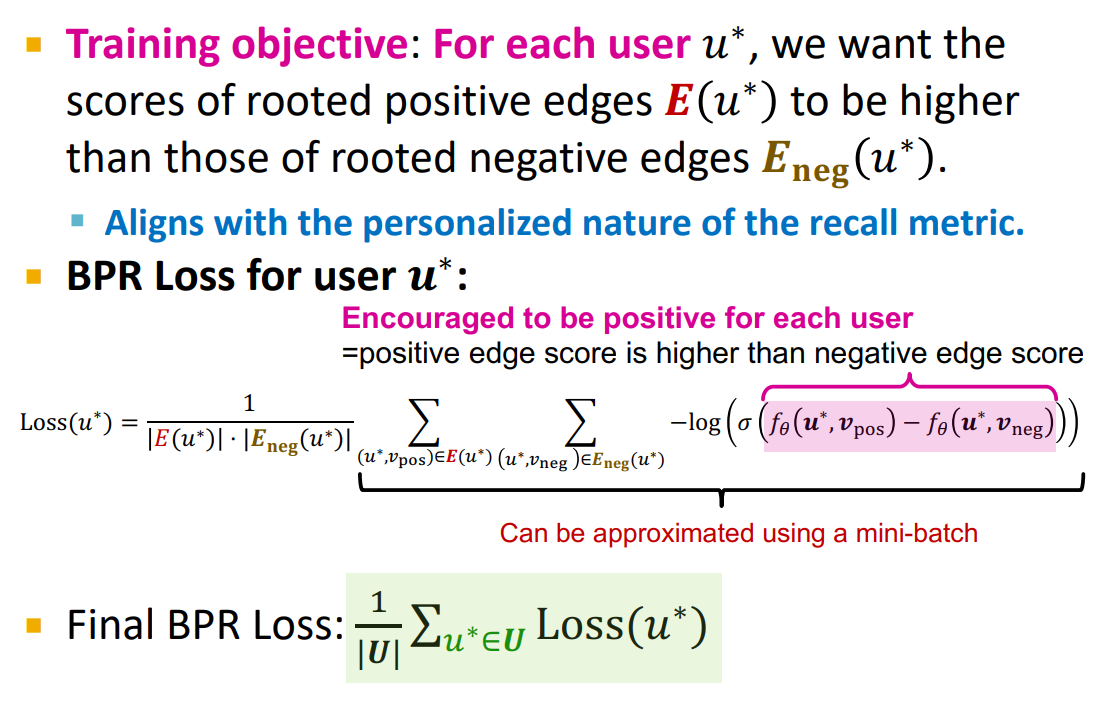

In [8]:
def bpr_loss(pos_scores, neg_scores):
    """
    Bayesian Personalized Ranking (BPR) loss function.
    
    Args:
        pos_scores: Scores for positive edges
        neg_scores: Scores for negative edges
        
    Returns:
        loss: BPR loss value
    """
    # BPR loss: -log(sigmoid(x_pos - x_neg))
    diff = pos_scores.unsqueeze(1) - neg_scores
    loss = -torch.log(torch.sigmoid(diff))
    return loss.mean()

In [9]:
def compute_recall_at_k(user_emb, item_emb, val_edges, train_edges, num_users, num_items, k_list=[10, 20]):
    recall_dict = {}
    # all_scores = torch.matmul(user_emb, item_emb.T)  # [num_users, num_items]
    
    val_edges_dict = {}
    for u, i in val_edges:
        if u not in val_edges_dict:
            val_edges_dict[u] = set()
        val_edges_dict[u].add(i)

    train_edges_dict = {}
    for u, i in train_edges:
        if u not in train_edges_dict:
            train_edges_dict[u] = set()
        train_edges_dict[u].add(i)

    recall_at_k = {k: 0.0 for k in k_list}
    total_users = 0

    for user_id in range(num_users):
        user_val_items = val_edges_dict.get(user_id, set())
        if not user_val_items:
            continue

        total_users += 1

        user_scores = torch.matmul(user_emb[user_id], item_emb.T)
        if user_id in train_edges_dict:
            # for train_item in train_edges_dict[user_id]:
            #     user_scores[train_item] = float('-inf')
            user_scores[list(train_edges_dict[user_id])] = float('-inf')

        for k in k_list:
            topk_items = torch.topk(user_scores, k).indices.cpu().numpy()
            hit_count = len(set(topk_items) & user_val_items)
            recall_at_k[k] += hit_count / len(user_val_items)
    for k in k_list:
        recall_dict[f'Recall@{k}'] = recall_at_k[k] / total_users if total_users > 0 else 0.0
    return recall_dict

## Training

In [10]:
def train_lightgcn(model, data, dataset_name, epochs=200, batch_size=1024, learning_rate=0.001, 
                   weight_decay=1e-4, device='cuda', negative_sampling_ratio=1, recall_k_list=[10, 20],
                   save_path=None, save_best=True):
    """
    Train LightGCN model.
    
    Args:
        model: LightGCN model
        data: PyG Data object with edge_index and masks
        epochs: Number of training epochs
        batch_size: Batch size for training
        learning_rate: Learning rate
        weight_decay: Weight decay for regularization
        device: Device to run training on
        negative_sampling_ratio: Ratio of negative samples to positive samples
        
    Returns:
        training_history: Dictionary containing training metrics
    """
    model.to(device)
    data.to(device)
    
    num_users = model.num_users
    num_items = model.num_items
    
    train_dataset = EdgeDataset(data.edge_index, data.train_mask, num_users, num_items, negative_sampling_ratio)
    val_dataset = EdgeDataset(data.edge_index, data.val_mask, num_users, num_items, negative_sampling_ratio)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=0,  # avoid multiprocessing issues
        pin_memory=False
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )
    
    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_auc': [],
        'val_auc_pr': [],
        'layer_weights': [],
        'recall_at_k': []
    }
    
    best_val_auc = 0
    patience = 20
    patience_counter = 0
    
    edge_index = data.edge_index.to(device)
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        train_batches = 0
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} - Training')
        for batch in pbar:
            # batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            optimizer.zero_grad()
            
            # frw pass - get embeddings
            user_emb, item_emb = model(edge_index)
            
            # pos edges scores
            pos_user_idx = batch['positive'][:, 0]
            pos_item_idx = batch['positive'][:, 1] #- num_users  # Adjust item indices
            pos_scores = model.predict(pos_user_idx, pos_item_idx, user_emb, item_emb)
            
            # neg edges scores
            neg_user_idx = batch['negatives'][:, :, 0]
            neg_item_idx = batch['negatives'][:, :, 1] #- num_users  # Adjust item indices
            
            neg_user_idx_flat = neg_user_idx.reshape(-1)
            neg_item_idx_flat = neg_item_idx.reshape(-1)
            neg_scores_flat = model.predict(neg_user_idx_flat, neg_item_idx_flat, user_emb, item_emb)
            neg_scores = neg_scores_flat.reshape(neg_user_idx.shape)
            
        
            loss = bpr_loss(pos_scores, neg_scores)

            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            train_batches += 1
            pbar.set_postfix(loss=f"{loss.item():.4f}")
        
        avg_train_loss = total_train_loss / train_batches
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        val_batches = 0
        val_scores = []
        val_labels = []
        
        with torch.no_grad():
            user_emb, item_emb = model(edge_index)
            for batch in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} - Validation'):
                batch = {k: v.to(device) for k, v in batch.items()}
                
                
                pos_user_idx = batch['positive'][:, 0]
                pos_item_idx = batch['positive'][:, 1] # - num_users
                pos_scores = model.predict(pos_user_idx, pos_item_idx, user_emb, item_emb)
                
                neg_user_idx = batch['negatives'][:, :, 0]
                neg_item_idx = batch['negatives'][:, :, 1] # - num_users
                
                neg_user_idx_flat = neg_user_idx.reshape(-1)
                neg_item_idx_flat = neg_item_idx.reshape(-1)
                neg_scores_flat = model.predict(neg_user_idx_flat, neg_item_idx_flat, user_emb, item_emb)
                neg_scores = neg_scores_flat.reshape(neg_user_idx.shape)
                
                val_loss = bpr_loss(pos_scores, neg_scores)
                total_val_loss += val_loss.item()
                val_batches += 1
                
                val_scores.extend(pos_scores.cpu().numpy())
                val_scores.extend(neg_scores.cpu().numpy().flatten())
                
                val_labels.extend(np.ones_like(pos_scores.cpu().numpy()))
                val_labels.extend(np.zeros_like(neg_scores.cpu().numpy().flatten()))
        
        avg_val_loss = total_val_loss / val_batches
        
        #  val metrics
        val_auc = roc_auc_score(val_labels, val_scores)
        precision, recall, _ = precision_recall_curve(val_labels, val_scores)
        val_auc_pr = auc(recall, precision)
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_auc'].append(val_auc)
        history['val_auc_pr'].append(val_auc_pr)

        with torch.no_grad():
            user_emb, item_emb = model(edge_index)
            val_edges = data.val_edges
            train_edges = data.train_edges  
            
            # recall@k
            recall_metrics = compute_recall_at_k(
                user_emb=user_emb.cpu(),
                item_emb=item_emb.cpu(),
                val_edges=val_edges,
                train_edges=train_edges,
                num_users=num_users,
                num_items=num_items,
                k_list=recall_k_list
            )
        
        history['recall_at_k'].append(recall_metrics)      
        
        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}")
        print(f"Val AUC-ROC: {val_auc:.4f}")
        print(f"Val AUC-PR: {val_auc_pr:.4f}")
        for metric_name, value in recall_metrics.items():
            print(f"{metric_name}: {value:.4f}")

        print("-" * 50)

        if not save_path:
            save_path = f"best_lightgcn_model_{dataset_name}.pth"
        
        # Early stopping
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            patience_counter = 0
            # Save best model
            if save_best:
                print(f"Saving best model to {save_path}")
                torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    if save_best:
        print(f"Loading best model from {save_path}")
        model.load_state_dict(torch.load(save_path))
    
    return history

In [16]:
def main(dataset_name='movielens-100k', epochs=200, embedding_dim=64, num_layers=3, batch_size=1024, learning_rate=0.001, 
         weight_decay=1e-4, device='cuda', negative_sampling_ratio=1):
    """
    Main function to run the LightGCN training and evaluation.
    
    Args:
        dataset_name: Name of the dataset ('movielens-100k' or 'movielens-1m')
        epochs: Number of training epochs
        batch_size: Batch size for training
        learning_rate: Learning rate
        weight_decay: Weight decay for regularization
        device: Device to run training on ('cuda' or 'cpu')
        negative_sampling_ratio: Ratio of negative samples to positive samples
        
    Returns:
        history: Training history containing loss and metrics
    """
    
    dataset_path = download_dataset(dataset_name)
    graph_obj_path = dataset_name+'_processed_graph.pt'
    if os.path.exists(graph_obj_path):
        data = torch.load(graph_obj_path, weights_only=False)
        if dataset_name.lower() == 'yelp':
            data.num_items = data.num_businesses
        data = data.to(device)
        print(f"Loaded processed graph data from {graph_obj_path}")
    else:
        if dataset_name.lower() == 'movielens-100k':
            user_nodes, item_nodes, num_users, num_items = load_movielens_100k(dataset_path)
        elif dataset_name.lower() == 'movielens-1m':
            user_nodes, item_nodes, num_users, num_items = load_movielens_1m(dataset_path)
        elif dataset_name.lower() == 'yelp':
            review_data_file = os.path.join(dataset_path, 'yelp_academic_dataset_review.json')
            process_yelp_data_in_chunks(review_data_file, chunk_size=50000)
        else:
            raise ValueError(f"Dataset {dataset_name} not supported.")
            

        print("Creating graph data and splitting edges into train/val/test sets...")
        if dataset_name.lower() == 'yelp':
            data = create_graph_from_chunks(
                'processed_chunks',
                user_mapping_file='user_to_idx.pkl',
                business_mapping_file='business_to_idx.pkl'
                )
            data = split_yelp_edges(data, test_ratio=0.2, val_ratio=0.05, save_path=graph_obj_path)
        else:   
            data = create_graph_data(user_nodes, item_nodes, num_users, num_items)
            data = split_edges(data, test_ratio=0.2, val_ratio=0.05)
        print("Graph data created")        
        print("Edge splitting completed\n----\n")
        
    
    num_users = data.num_users
    num_items = data.num_items

    print(f"Loaded {dataset_name} dataset with {num_users} users and {num_items} items")
    print(f"Number of user nodes: {num_users}")
    print(f"Number of item nodes: {num_items}")
    print(f"Number of edges: {data.edge_index.size(1)//2}")

    data = data.to(device)
    model = LightGCN(
        num_users=num_users, 
        num_items=num_items, 
        embedding_dim=embedding_dim, 
        num_layers=num_layers,
    ).to(device)
    
    # Train the model
    history = train_lightgcn(model, data, dataset_name, epochs=epochs, batch_size=batch_size,
                             learning_rate=learning_rate, weight_decay=weight_decay,
                             device=device, negative_sampling_ratio=negative_sampling_ratio)
    
    return history

In [19]:
def test_model(dataset_name, device='cuda', save_path=None):
    """
    Test the LightGCN model on the test set.
    
    Args:
        model: Trained LightGCN model
        data: PyG Data object with edge_index and masks
        dataset_name: Name of the dataset ('movielens-100k' or 'movielens-1m')
        device: Device to run testing on ('cuda' or 'cpu')
        
    Returns:
        test_results: Dictionary containing test metrics
    """
    
    dataset_path = download_dataset(dataset_name)
    graph_obj_path = dataset_name+'_processed_graph.pt'
    if os.path.exists(graph_obj_path):
        data = torch.load(graph_obj_path, weights_only=False)
        if dataset_name.lower() == 'yelp':
            data.num_items = data.num_businesses
        data = data.to(device)
        print(f"Loaded processed graph data from {graph_obj_path}")
    else:
        if dataset_name.lower() == 'movielens-100k':
            user_nodes, item_nodes, num_users, num_items = load_movielens_100k(dataset_path)
        elif dataset_name.lower() == 'movielens-1m':
            user_nodes, item_nodes, num_users, num_items = load_movielens_1m(dataset_path)
        elif dataset_name.lower() == 'yelp':
            review_data_file = os.path.join(dataset_path, 'yelp_academic_dataset_review.json')
            process_yelp_data_in_chunks(review_data_file, chunk_size=50000)
        else:
            raise ValueError(f"Dataset {dataset_name} not supported.")
            
        print("Creating graph data and splitting edges into train/val/test sets...")
        if dataset_name.lower() == 'yelp':
            data = create_graph_from_chunks(
                'processed_chunks',
                user_mapping_file='user_to_idx.pkl',
                business_mapping_file='business_to_idx.pkl'
                )
            data = split_yelp_edges(data, test_ratio=0.2, val_ratio=0.05, save_path=graph_obj_path)
        else:   
            data = create_graph_data(user_nodes, item_nodes, num_users, num_items)
            data = split_edges(data, test_ratio=0.2, val_ratio=0.05)
        print("Graph data created")        
        print("Edge splitting completed\n----\n")

    num_users = data.num_users
    num_items = data.num_items
    
    print(f"Loaded {dataset_name} dataset with {num_users} users and {num_items} items")
    print(f"Number of user nodes: {num_users}")
    print(f"Number of item nodes: {num_items}")
    print(f"Number of edges: {data.edge_index.size(1)//2}")

    

    model = LightGCN(
        num_users=num_users,
        num_items=num_items,
        embedding_dim=100,
        num_layers=3,
    ).to(device)
    # Load the best model
    if save_path:
        print(f"Loading best model from {save_path}")
        model.load_state_dict(torch.load(save_path))
    else:
        model.load_state_dict(torch.load(f"best_lightgcn_model_{dataset_name}.pth"))
    model.to(device)
    data.to(device)
    

    
    test_dataset = EdgeDataset(data.edge_index, data.test_mask, num_users, num_items)
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=1024, 
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )
    
    # Load best model if save_path is provided
    
    
    # Testing phase
    model.eval()
    total_test_loss = 0
    test_batches = 0
    test_scores = []
    test_labels = []
    
    with torch.no_grad():
        user_emb, item_emb = model(data.edge_index)
        for batch in tqdm(test_loader, desc=f'Testing'):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            pos_user_idx = batch['positive'][:, 0]
            pos_item_idx = batch['positive'][:, 1] # - num_users
            
            pos_scores = model.predict(pos_user_idx, pos_item_idx, user_emb, item_emb)
            
            neg_user_idx = batch['negatives'][:, :, 0]
            neg_item_idx = batch['negatives'][:, :, 1] # - num_users
            
            neg_user_idx_flat = neg_user_idx.reshape(-1)
            neg_item_idx_flat = neg_item_idx.reshape(-1)
            neg_scores_flat = model.predict(neg_user_idx_flat, neg_item_idx_flat, user_emb, item_emb)
            neg_scores = neg_scores_flat.reshape(neg_user_idx.shape)
            
            test_loss = bpr_loss(pos_scores, neg_scores)
            total_test_loss += test_loss.item()
            test_batches += 1
            test_scores.extend(pos_scores.cpu().numpy())
            test_scores.extend(neg_scores.cpu().numpy().flatten())
            test_labels.extend(np.ones_like(pos_scores.cpu().numpy()))
            test_labels.extend(np.zeros_like(neg_scores.cpu().numpy().flatten()))
    avg_test_loss = total_test_loss / test_batches
    test_auc = roc_auc_score(test_labels, test_scores)
    precision, recall, _ = precision_recall_curve(test_labels, test_scores)
    test_auc_pr = auc(recall, precision)

    ## recall@k
    test_edges = data.test_edges
    train_edges = data.train_edges
    recall_metrics = compute_recall_at_k(
        user_emb=user_emb.cpu(),
        item_emb=item_emb.cpu(),
        val_edges=test_edges,
        train_edges=train_edges,
        num_users=num_users,
        num_items=num_items,
        k_list=[10, 20]
    )
    print("Recall@k metrics on test set:")
    for metric_name, value in recall_metrics.items():
        print(f"{metric_name}: {value:.4f}")
    test_results = {
        'test_loss': avg_test_loss,
        'test_auc': test_auc,
        'test_auc_pr': test_auc_pr,
        'recall_at_k': recall_metrics
    }
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test AUC-ROC: {test_auc:.4f}")
    print(f"Test AUC-PR: {test_auc_pr:.4f}")

    return test_results

---

### Yelp

In [ ]:
hist = main(
    dataset_name='yelp', 
    epochs=3,
    embedding_dim=100, 
    num_layers=3,
    batch_size=1024, 
    learning_rate=0.001, 
    weight_decay=5e-5, 
    device='cuda', 
    negative_sampling_ratio=2
)

In [14]:
yelp_test_results = test_model(
    dataset_name='yelp', 
    device='cuda', 
    save_path='best_lightgcn_model_yelp.pth'
)

Using Yelp dataset from ..\yelp\Yelp-JSON\Yelp JSON
Loaded processed graph data from yelp_processed_graph.pt
Loaded yelp dataset with 1987929 users and 150346 items
Number of user nodes: 1987929
Number of item nodes: 150346
Number of edges: 4684545
Loading best model from best_lightgcn_model_yelp.pth


Testing: 100%|██████████| 1830/1830 [01:03<00:00, 28.86it/s]


Recall@k metrics on test set:
Recall@10: 0.3130
Recall@20: 0.4063
Test Loss: 0.0419
Test AUC-ROC: 0.9884
Test AUC-PR: 0.9863


---

### Movielens

In [ ]:
hist = main(
    dataset_name='movielens-100k', 
    epochs=100,
    embedding_dim=64, 
    num_layers=4,
    batch_size=1024, 
    learning_rate=0.0005, 
    weight_decay=5e-5, 
    device='cuda', 
    negative_sampling_ratio=30
)

Loaded processed graph data from movielens-100k_processed_graph.pt


Epoch 1/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


Epoch 1/100
Train Loss: 0.6835
Val Loss: 0.6905
Val AUC-ROC: 0.5717
Val AUC-PR: 0.0434
Recall@10: 0.0212
Recall@20: 0.0363
--------------------------------------------------


Epoch 2/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


Epoch 2/100
Train Loss: 0.6711
Val Loss: 0.6784
Val AUC-ROC: 0.5844
Val AUC-PR: 0.0458
Recall@10: 0.0237
Recall@20: 0.0391
--------------------------------------------------


Epoch 3/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


Epoch 3/100
Train Loss: 0.6556
Val Loss: 0.6600
Val AUC-ROC: 0.6054
Val AUC-PR: 0.0503
Recall@10: 0.0263
Recall@20: 0.0435
--------------------------------------------------


Epoch 4/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


Epoch 4/100
Train Loss: 0.6352
Val Loss: 0.6392
Val AUC-ROC: 0.6310
Val AUC-PR: 0.0559
Recall@10: 0.0307
Recall@20: 0.0521
--------------------------------------------------


Epoch 5/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]


Epoch 5/100
Train Loss: 0.6098
Val Loss: 0.6124
Val AUC-ROC: 0.6636
Val AUC-PR: 0.0652
Recall@10: 0.0378
Recall@20: 0.0643
--------------------------------------------------


Epoch 6/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]


Epoch 6/100
Train Loss: 0.5801
Val Loss: 0.5821
Val AUC-ROC: 0.6983
Val AUC-PR: 0.0760
Recall@10: 0.0455
Recall@20: 0.0805
--------------------------------------------------


Epoch 7/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.60it/s]


Epoch 7/100
Train Loss: 0.5466
Val Loss: 0.5490
Val AUC-ROC: 0.7313
Val AUC-PR: 0.0869
Recall@10: 0.0529
Recall@20: 0.1038
--------------------------------------------------


Epoch 8/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


Epoch 8/100
Train Loss: 0.5126
Val Loss: 0.5191
Val AUC-ROC: 0.7557
Val AUC-PR: 0.0941
Recall@10: 0.0663
Recall@20: 0.1139
--------------------------------------------------


Epoch 9/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]


Epoch 9/100
Train Loss: 0.4825
Val Loss: 0.4927
Val AUC-ROC: 0.7740
Val AUC-PR: 0.0994
Recall@10: 0.0746
Recall@20: 0.1241
--------------------------------------------------


Epoch 10/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]


Epoch 10/100
Train Loss: 0.4566
Val Loss: 0.4691
Val AUC-ROC: 0.7882
Val AUC-PR: 0.1044
Recall@10: 0.0806
Recall@20: 0.1398
--------------------------------------------------


Epoch 11/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]


Epoch 11/100
Train Loss: 0.4361
Val Loss: 0.4528
Val AUC-ROC: 0.7965
Val AUC-PR: 0.1065
Recall@10: 0.0845
Recall@20: 0.1420
--------------------------------------------------


Epoch 12/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.25it/s]


Epoch 12/100
Train Loss: 0.4198
Val Loss: 0.4412
Val AUC-ROC: 0.8017
Val AUC-PR: 0.1086
Recall@10: 0.0899
Recall@20: 0.1482
--------------------------------------------------


Epoch 13/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.27it/s]


Epoch 13/100
Train Loss: 0.4076
Val Loss: 0.4317
Val AUC-ROC: 0.8058
Val AUC-PR: 0.1098
Recall@10: 0.0908
Recall@20: 0.1495
--------------------------------------------------


Epoch 14/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


Epoch 14/100
Train Loss: 0.3986
Val Loss: 0.4243
Val AUC-ROC: 0.8086
Val AUC-PR: 0.1105
Recall@10: 0.0947
Recall@20: 0.1528
--------------------------------------------------


Epoch 15/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]


Epoch 15/100
Train Loss: 0.3912
Val Loss: 0.4191
Val AUC-ROC: 0.8109
Val AUC-PR: 0.1111
Recall@10: 0.0970
Recall@20: 0.1595
--------------------------------------------------


Epoch 16/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.68it/s]


Epoch 16/100
Train Loss: 0.3856
Val Loss: 0.4162
Val AUC-ROC: 0.8114
Val AUC-PR: 0.1103
Recall@10: 0.0979
Recall@20: 0.1651
--------------------------------------------------


Epoch 17/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]


Epoch 17/100
Train Loss: 0.3815
Val Loss: 0.4115
Val AUC-ROC: 0.8143
Val AUC-PR: 0.1126
Recall@10: 0.1018
Recall@20: 0.1629
--------------------------------------------------


Epoch 18/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.61it/s]


Epoch 18/100
Train Loss: 0.3789
Val Loss: 0.4090
Val AUC-ROC: 0.8152
Val AUC-PR: 0.1130
Recall@10: 0.1048
Recall@20: 0.1672
--------------------------------------------------


Epoch 19/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


Epoch 19/100
Train Loss: 0.3758
Val Loss: 0.4068
Val AUC-ROC: 0.8160
Val AUC-PR: 0.1134
Recall@10: 0.1076
Recall@20: 0.1744
--------------------------------------------------


Epoch 20/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.31it/s]


Epoch 20/100
Train Loss: 0.3745
Val Loss: 0.4058
Val AUC-ROC: 0.8173
Val AUC-PR: 0.1129
Recall@10: 0.1091
Recall@20: 0.1808
--------------------------------------------------


Epoch 21/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.28it/s]


Epoch 21/100
Train Loss: 0.3723
Val Loss: 0.4066
Val AUC-ROC: 0.8169
Val AUC-PR: 0.1122
Recall@10: 0.1109
Recall@20: 0.1821
--------------------------------------------------


Epoch 22/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.09it/s]


Epoch 22/100
Train Loss: 0.3714
Val Loss: 0.4040
Val AUC-ROC: 0.8177
Val AUC-PR: 0.1128
Recall@10: 0.1134
Recall@20: 0.1845
--------------------------------------------------


Epoch 23/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]


Epoch 23/100
Train Loss: 0.3699
Val Loss: 0.4021
Val AUC-ROC: 0.8186
Val AUC-PR: 0.1127
Recall@10: 0.1100
Recall@20: 0.1832
--------------------------------------------------


Epoch 24/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]


Epoch 24/100
Train Loss: 0.3689
Val Loss: 0.4023
Val AUC-ROC: 0.8192
Val AUC-PR: 0.1134
Recall@10: 0.1126
Recall@20: 0.1853
--------------------------------------------------


Epoch 25/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


Epoch 25/100
Train Loss: 0.3678
Val Loss: 0.3992
Val AUC-ROC: 0.8203
Val AUC-PR: 0.1148
Recall@10: 0.1135
Recall@20: 0.1852
--------------------------------------------------


Epoch 26/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]


Epoch 26/100
Train Loss: 0.3669
Val Loss: 0.4003
Val AUC-ROC: 0.8193
Val AUC-PR: 0.1141
Recall@10: 0.1173
Recall@20: 0.1883
--------------------------------------------------


Epoch 27/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]


Epoch 27/100
Train Loss: 0.3663
Val Loss: 0.4005
Val AUC-ROC: 0.8190
Val AUC-PR: 0.1138
Recall@10: 0.1186
Recall@20: 0.1919
--------------------------------------------------


Epoch 28/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.25it/s]


Epoch 28/100
Train Loss: 0.3654
Val Loss: 0.3982
Val AUC-ROC: 0.8204
Val AUC-PR: 0.1137
Recall@10: 0.1219
Recall@20: 0.1943
--------------------------------------------------


Epoch 29/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


Epoch 29/100
Train Loss: 0.3649
Val Loss: 0.3981
Val AUC-ROC: 0.8205
Val AUC-PR: 0.1144
Recall@10: 0.1240
Recall@20: 0.1946
--------------------------------------------------


Epoch 30/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


Epoch 30/100
Train Loss: 0.3648
Val Loss: 0.3996
Val AUC-ROC: 0.8196
Val AUC-PR: 0.1140
Recall@10: 0.1249
Recall@20: 0.1985
--------------------------------------------------


Epoch 31/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


Epoch 31/100
Train Loss: 0.3637
Val Loss: 0.3988
Val AUC-ROC: 0.8200
Val AUC-PR: 0.1137
Recall@10: 0.1271
Recall@20: 0.1967
--------------------------------------------------


Epoch 32/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.22it/s]


Epoch 32/100
Train Loss: 0.3638
Val Loss: 0.3967
Val AUC-ROC: 0.8196
Val AUC-PR: 0.1145
Recall@10: 0.1295
Recall@20: 0.1985
--------------------------------------------------


Epoch 33/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]


Epoch 33/100
Train Loss: 0.3636
Val Loss: 0.3983
Val AUC-ROC: 0.8193
Val AUC-PR: 0.1129
Recall@10: 0.1307
Recall@20: 0.1978
--------------------------------------------------


Epoch 34/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.22it/s]


Epoch 34/100
Train Loss: 0.3629
Val Loss: 0.3961
Val AUC-ROC: 0.8205
Val AUC-PR: 0.1144
Recall@10: 0.1319
Recall@20: 0.1980
--------------------------------------------------


Epoch 35/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


Epoch 35/100
Train Loss: 0.3629
Val Loss: 0.3959
Val AUC-ROC: 0.8206
Val AUC-PR: 0.1140
Recall@10: 0.1331
Recall@20: 0.2012
--------------------------------------------------


Epoch 36/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.23it/s]


Epoch 36/100
Train Loss: 0.3616
Val Loss: 0.3960
Val AUC-ROC: 0.8199
Val AUC-PR: 0.1142
Recall@10: 0.1326
Recall@20: 0.2015
--------------------------------------------------


Epoch 37/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.65it/s]


Epoch 37/100
Train Loss: 0.3618
Val Loss: 0.3944
Val AUC-ROC: 0.8205
Val AUC-PR: 0.1155
Recall@10: 0.1328
Recall@20: 0.2018
--------------------------------------------------


Epoch 38/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.31it/s]


Epoch 38/100
Train Loss: 0.3613
Val Loss: 0.3960
Val AUC-ROC: 0.8198
Val AUC-PR: 0.1140
Recall@10: 0.1311
Recall@20: 0.2054
--------------------------------------------------


Epoch 39/100 - Validation: 100%|██████████| 6/6 [00:03<00:00,  1.98it/s]


Epoch 39/100
Train Loss: 0.3609
Val Loss: 0.3953
Val AUC-ROC: 0.8206
Val AUC-PR: 0.1143
Recall@10: 0.1312
Recall@20: 0.2045
--------------------------------------------------


Epoch 40/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]


Epoch 40/100
Train Loss: 0.3609
Val Loss: 0.3917
Val AUC-ROC: 0.8221
Val AUC-PR: 0.1175
Recall@10: 0.1341
Recall@20: 0.2041
--------------------------------------------------


Epoch 41/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]


Epoch 41/100
Train Loss: 0.3608
Val Loss: 0.3934
Val AUC-ROC: 0.8213
Val AUC-PR: 0.1148
Recall@10: 0.1340
Recall@20: 0.2072
--------------------------------------------------


Epoch 42/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


Epoch 42/100
Train Loss: 0.3604
Val Loss: 0.3945
Val AUC-ROC: 0.8197
Val AUC-PR: 0.1144
Recall@10: 0.1332
Recall@20: 0.2075
--------------------------------------------------


Epoch 43/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epoch 43/100
Train Loss: 0.3595
Val Loss: 0.3917
Val AUC-ROC: 0.8223
Val AUC-PR: 0.1169
Recall@10: 0.1339
Recall@20: 0.2085
--------------------------------------------------


Epoch 44/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]


Epoch 44/100
Train Loss: 0.3597
Val Loss: 0.3927
Val AUC-ROC: 0.8215
Val AUC-PR: 0.1151
Recall@10: 0.1361
Recall@20: 0.2103
--------------------------------------------------


Epoch 45/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.23it/s]


Epoch 45/100
Train Loss: 0.3597
Val Loss: 0.3944
Val AUC-ROC: 0.8200
Val AUC-PR: 0.1140
Recall@10: 0.1362
Recall@20: 0.2111
--------------------------------------------------


Epoch 46/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.70it/s]


Epoch 46/100
Train Loss: 0.3588
Val Loss: 0.3921
Val AUC-ROC: 0.8220
Val AUC-PR: 0.1167
Recall@10: 0.1374
Recall@20: 0.2120
--------------------------------------------------


Epoch 47/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]


Epoch 47/100
Train Loss: 0.3578
Val Loss: 0.3913
Val AUC-ROC: 0.8220
Val AUC-PR: 0.1159
Recall@10: 0.1383
Recall@20: 0.2131
--------------------------------------------------


Epoch 48/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Epoch 48/100
Train Loss: 0.3572
Val Loss: 0.3907
Val AUC-ROC: 0.8217
Val AUC-PR: 0.1159
Recall@10: 0.1379
Recall@20: 0.2147
--------------------------------------------------


Epoch 49/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]


Epoch 49/100
Train Loss: 0.3573
Val Loss: 0.3920
Val AUC-ROC: 0.8211
Val AUC-PR: 0.1154
Recall@10: 0.1431
Recall@20: 0.2167
--------------------------------------------------


Epoch 50/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.42it/s]


Epoch 50/100
Train Loss: 0.3569
Val Loss: 0.3911
Val AUC-ROC: 0.8217
Val AUC-PR: 0.1161
Recall@10: 0.1430
Recall@20: 0.2166
--------------------------------------------------


Epoch 51/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.41it/s]


Epoch 51/100
Train Loss: 0.3567
Val Loss: 0.3896
Val AUC-ROC: 0.8228
Val AUC-PR: 0.1162
Recall@10: 0.1429
Recall@20: 0.2177
--------------------------------------------------


Epoch 52/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.41it/s]


Epoch 52/100
Train Loss: 0.3558
Val Loss: 0.3893
Val AUC-ROC: 0.8227
Val AUC-PR: 0.1162
Recall@10: 0.1432
Recall@20: 0.2171
--------------------------------------------------


Epoch 53/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.20it/s]


Epoch 53/100
Train Loss: 0.3553
Val Loss: 0.3884
Val AUC-ROC: 0.8231
Val AUC-PR: 0.1169
Recall@10: 0.1433
Recall@20: 0.2182
--------------------------------------------------


Epoch 54/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]


Epoch 54/100
Train Loss: 0.3544
Val Loss: 0.3890
Val AUC-ROC: 0.8229
Val AUC-PR: 0.1158
Recall@10: 0.1428
Recall@20: 0.2233
--------------------------------------------------


Epoch 55/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.50it/s]


Epoch 55/100
Train Loss: 0.3548
Val Loss: 0.3877
Val AUC-ROC: 0.8235
Val AUC-PR: 0.1171
Recall@10: 0.1411
Recall@20: 0.2234
--------------------------------------------------


Epoch 56/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]


Epoch 56/100
Train Loss: 0.3538
Val Loss: 0.3873
Val AUC-ROC: 0.8234
Val AUC-PR: 0.1172
Recall@10: 0.1417
Recall@20: 0.2245
--------------------------------------------------


Epoch 57/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]


Epoch 57/100
Train Loss: 0.3540
Val Loss: 0.3863
Val AUC-ROC: 0.8237
Val AUC-PR: 0.1176
Recall@10: 0.1421
Recall@20: 0.2251
--------------------------------------------------


Epoch 58/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]


Epoch 58/100
Train Loss: 0.3532
Val Loss: 0.3862
Val AUC-ROC: 0.8240
Val AUC-PR: 0.1184
Recall@10: 0.1427
Recall@20: 0.2259
--------------------------------------------------


Epoch 59/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.27it/s]


Epoch 59/100
Train Loss: 0.3529
Val Loss: 0.3881
Val AUC-ROC: 0.8236
Val AUC-PR: 0.1173
Recall@10: 0.1438
Recall@20: 0.2252
--------------------------------------------------


Epoch 60/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]


Epoch 60/100
Train Loss: 0.3520
Val Loss: 0.3865
Val AUC-ROC: 0.8238
Val AUC-PR: 0.1165
Recall@10: 0.1441
Recall@20: 0.2268
--------------------------------------------------


Epoch 61/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


Epoch 61/100
Train Loss: 0.3516
Val Loss: 0.3847
Val AUC-ROC: 0.8253
Val AUC-PR: 0.1182
Recall@10: 0.1441
Recall@20: 0.2263
--------------------------------------------------


Epoch 62/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]


Epoch 62/100
Train Loss: 0.3511
Val Loss: 0.3831
Val AUC-ROC: 0.8256
Val AUC-PR: 0.1186
Recall@10: 0.1453
Recall@20: 0.2283
--------------------------------------------------


Epoch 63/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]


Epoch 63/100
Train Loss: 0.3512
Val Loss: 0.3855
Val AUC-ROC: 0.8244
Val AUC-PR: 0.1188
Recall@10: 0.1454
Recall@20: 0.2261
--------------------------------------------------


Epoch 64/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]


Epoch 64/100
Train Loss: 0.3502
Val Loss: 0.3853
Val AUC-ROC: 0.8247
Val AUC-PR: 0.1176
Recall@10: 0.1462
Recall@20: 0.2282
--------------------------------------------------


Epoch 65/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.41it/s]


Epoch 65/100
Train Loss: 0.3494
Val Loss: 0.3838
Val AUC-ROC: 0.8257
Val AUC-PR: 0.1189
Recall@10: 0.1459
Recall@20: 0.2305
--------------------------------------------------


Epoch 66/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]


Epoch 66/100
Train Loss: 0.3491
Val Loss: 0.3823
Val AUC-ROC: 0.8260
Val AUC-PR: 0.1200
Recall@10: 0.1467
Recall@20: 0.2304
--------------------------------------------------


Epoch 67/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


Epoch 67/100
Train Loss: 0.3490
Val Loss: 0.3830
Val AUC-ROC: 0.8260
Val AUC-PR: 0.1189
Recall@10: 0.1472
Recall@20: 0.2309
--------------------------------------------------


Epoch 68/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


Epoch 68/100
Train Loss: 0.3480
Val Loss: 0.3833
Val AUC-ROC: 0.8264
Val AUC-PR: 0.1185
Recall@10: 0.1465
Recall@20: 0.2318
--------------------------------------------------


Epoch 69/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


Epoch 69/100
Train Loss: 0.3481
Val Loss: 0.3825
Val AUC-ROC: 0.8263
Val AUC-PR: 0.1191
Recall@10: 0.1476
Recall@20: 0.2312
--------------------------------------------------


Epoch 70/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


Epoch 70/100
Train Loss: 0.3478
Val Loss: 0.3811
Val AUC-ROC: 0.8261
Val AUC-PR: 0.1196
Recall@10: 0.1488
Recall@20: 0.2337
--------------------------------------------------


Epoch 71/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch 71/100
Train Loss: 0.3480
Val Loss: 0.3805
Val AUC-ROC: 0.8272
Val AUC-PR: 0.1201
Recall@10: 0.1523
Recall@20: 0.2340
--------------------------------------------------


Epoch 72/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]


Epoch 72/100
Train Loss: 0.3473
Val Loss: 0.3819
Val AUC-ROC: 0.8272
Val AUC-PR: 0.1194
Recall@10: 0.1524
Recall@20: 0.2341
--------------------------------------------------


Epoch 73/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]


Epoch 73/100
Train Loss: 0.3469
Val Loss: 0.3801
Val AUC-ROC: 0.8272
Val AUC-PR: 0.1204
Recall@10: 0.1516
Recall@20: 0.2341
--------------------------------------------------


Epoch 74/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


Epoch 74/100
Train Loss: 0.3464
Val Loss: 0.3815
Val AUC-ROC: 0.8268
Val AUC-PR: 0.1202
Recall@10: 0.1527
Recall@20: 0.2347
--------------------------------------------------


Epoch 75/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.32it/s]


Epoch 75/100
Train Loss: 0.3461
Val Loss: 0.3804
Val AUC-ROC: 0.8279
Val AUC-PR: 0.1207
Recall@10: 0.1523
Recall@20: 0.2349
--------------------------------------------------


Epoch 76/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]


Epoch 76/100
Train Loss: 0.3456
Val Loss: 0.3803
Val AUC-ROC: 0.8276
Val AUC-PR: 0.1203
Recall@10: 0.1527
Recall@20: 0.2351
--------------------------------------------------


Epoch 77/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.28it/s]


Epoch 77/100
Train Loss: 0.3463
Val Loss: 0.3796
Val AUC-ROC: 0.8280
Val AUC-PR: 0.1200
Recall@10: 0.1528
Recall@20: 0.2343
--------------------------------------------------


Epoch 78/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.32it/s]


Epoch 78/100
Train Loss: 0.3455
Val Loss: 0.3792
Val AUC-ROC: 0.8277
Val AUC-PR: 0.1202
Recall@10: 0.1522
Recall@20: 0.2348
--------------------------------------------------


Epoch 79/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]


Epoch 79/100
Train Loss: 0.3442
Val Loss: 0.3787
Val AUC-ROC: 0.8288
Val AUC-PR: 0.1206
Recall@10: 0.1535
Recall@20: 0.2348
--------------------------------------------------


Epoch 80/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]


Epoch 80/100
Train Loss: 0.3444
Val Loss: 0.3809
Val AUC-ROC: 0.8276
Val AUC-PR: 0.1193
Recall@10: 0.1539
Recall@20: 0.2347
--------------------------------------------------


Epoch 81/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.33it/s]


Epoch 81/100
Train Loss: 0.3450
Val Loss: 0.3795
Val AUC-ROC: 0.8282
Val AUC-PR: 0.1201
Recall@10: 0.1541
Recall@20: 0.2354
--------------------------------------------------


Epoch 82/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]


Epoch 82/100
Train Loss: 0.3449
Val Loss: 0.3791
Val AUC-ROC: 0.8283
Val AUC-PR: 0.1207
Recall@10: 0.1540
Recall@20: 0.2341
--------------------------------------------------


Epoch 83/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]


Epoch 83/100
Train Loss: 0.3450
Val Loss: 0.3784
Val AUC-ROC: 0.8287
Val AUC-PR: 0.1214
Recall@10: 0.1521
Recall@20: 0.2343
--------------------------------------------------


Epoch 84/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]


Epoch 84/100
Train Loss: 0.3445
Val Loss: 0.3778
Val AUC-ROC: 0.8288
Val AUC-PR: 0.1206
Recall@10: 0.1538
Recall@20: 0.2338
--------------------------------------------------


Epoch 85/100 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]


Epoch 85/100
Train Loss: 0.3442
Val Loss: 0.3777
Val AUC-ROC: 0.8290
Val AUC-PR: 0.1220
Recall@10: 0.1530
Recall@20: 0.2345
--------------------------------------------------


Epoch 86/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.06it/s]


Epoch 86/100
Train Loss: 0.3437
Val Loss: 0.3796
Val AUC-ROC: 0.8282
Val AUC-PR: 0.1199
Recall@10: 0.1526
Recall@20: 0.2345
--------------------------------------------------


Epoch 87/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]


Epoch 87/100
Train Loss: 0.3438
Val Loss: 0.3790
Val AUC-ROC: 0.8282
Val AUC-PR: 0.1213
Recall@10: 0.1530
Recall@20: 0.2337
--------------------------------------------------


Epoch 88/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.36it/s]


Epoch 88/100
Train Loss: 0.3439
Val Loss: 0.3795
Val AUC-ROC: 0.8284
Val AUC-PR: 0.1202
Recall@10: 0.1528
Recall@20: 0.2342
--------------------------------------------------


Epoch 89/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.16it/s]


Epoch 89/100
Train Loss: 0.3436
Val Loss: 0.3764
Val AUC-ROC: 0.8294
Val AUC-PR: 0.1207
Recall@10: 0.1534
Recall@20: 0.2344
--------------------------------------------------


Epoch 90/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.20it/s]


Epoch 90/100
Train Loss: 0.3439
Val Loss: 0.3781
Val AUC-ROC: 0.8292
Val AUC-PR: 0.1201
Recall@10: 0.1547
Recall@20: 0.2351
--------------------------------------------------


Epoch 91/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.34it/s]


Epoch 91/100
Train Loss: 0.3433
Val Loss: 0.3771
Val AUC-ROC: 0.8290
Val AUC-PR: 0.1207
Recall@10: 0.1534
Recall@20: 0.2332
--------------------------------------------------


Epoch 92/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]


Epoch 92/100
Train Loss: 0.3435
Val Loss: 0.3795
Val AUC-ROC: 0.8287
Val AUC-PR: 0.1195
Recall@10: 0.1554
Recall@20: 0.2338
--------------------------------------------------


Epoch 93/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.11it/s]


Epoch 93/100
Train Loss: 0.3436
Val Loss: 0.3796
Val AUC-ROC: 0.8280
Val AUC-PR: 0.1187
Recall@10: 0.1554
Recall@20: 0.2338
--------------------------------------------------


Epoch 94/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


Epoch 94/100
Train Loss: 0.3432
Val Loss: 0.3775
Val AUC-ROC: 0.8287
Val AUC-PR: 0.1210
Recall@10: 0.1549
Recall@20: 0.2352
--------------------------------------------------


Epoch 95/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


Epoch 95/100
Train Loss: 0.3436
Val Loss: 0.3771
Val AUC-ROC: 0.8297
Val AUC-PR: 0.1217
Recall@10: 0.1553
Recall@20: 0.2342
--------------------------------------------------


Epoch 96/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]


Epoch 96/100
Train Loss: 0.3437
Val Loss: 0.3779
Val AUC-ROC: 0.8296
Val AUC-PR: 0.1215
Recall@10: 0.1549
Recall@20: 0.2356
--------------------------------------------------


Epoch 97/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.41it/s]


Epoch 97/100
Train Loss: 0.3429
Val Loss: 0.3772
Val AUC-ROC: 0.8296
Val AUC-PR: 0.1214
Recall@10: 0.1550
Recall@20: 0.2358
--------------------------------------------------


Epoch 98/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]


Epoch 98/100
Train Loss: 0.3432
Val Loss: 0.3774
Val AUC-ROC: 0.8294
Val AUC-PR: 0.1219
Recall@10: 0.1550
Recall@20: 0.2351
--------------------------------------------------


Epoch 99/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.20it/s]


Epoch 99/100
Train Loss: 0.3432
Val Loss: 0.3796
Val AUC-ROC: 0.8283
Val AUC-PR: 0.1195
Recall@10: 0.1550
Recall@20: 0.2351
--------------------------------------------------


Epoch 100/100 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.62it/s]


Epoch 100/100
Train Loss: 0.3430
Val Loss: 0.3778
Val AUC-ROC: 0.8294
Val AUC-PR: 0.1204
Recall@10: 0.1548
Recall@20: 0.2352
--------------------------------------------------


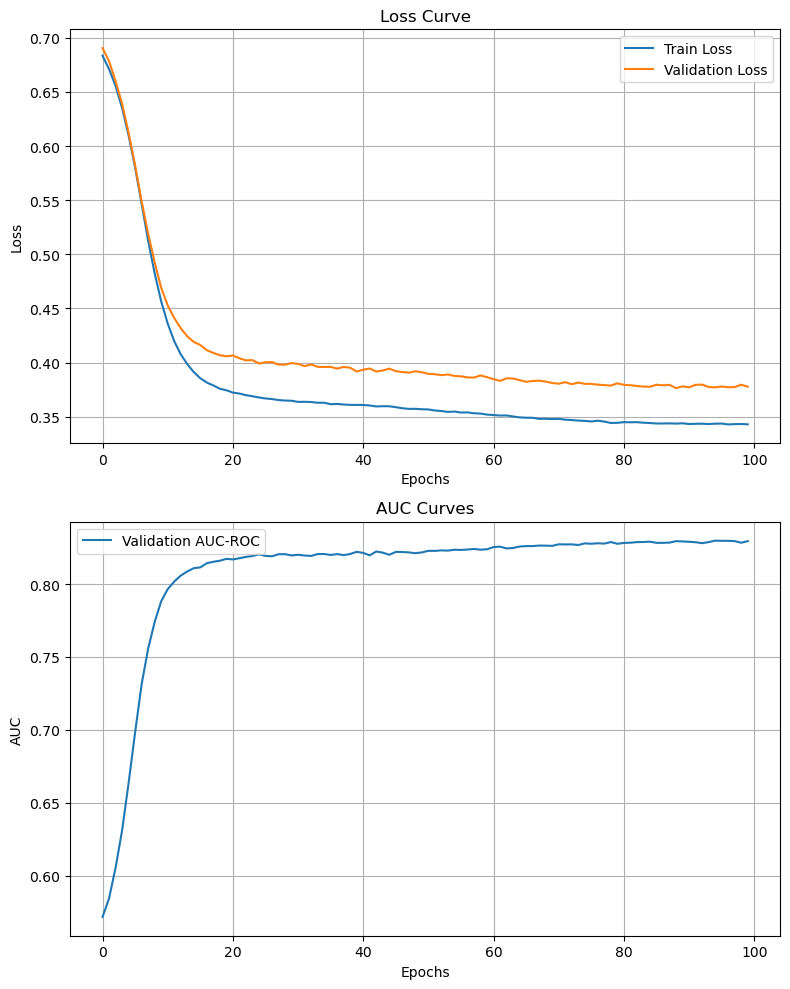

In [ ]:
# plot training history 
import matplotlib.pyplot as plt
import numpy as np

train_loss = hist['train_loss']
val_loss = hist['val_loss']
val_auc = hist['val_auc']
val_auc_pr = hist['val_auc_pr']
recall_at_k = hist['recall_at_k']
recall_at_k = [recall['Recall@10'] for recall in recall_at_k]
recall_at_k_20 = [recall['Recall@20'] for recall in hist['recall_at_k']]

plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.title('Loss Curve')
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(val_auc, label='Validation AUC-ROC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('AUC Curves')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


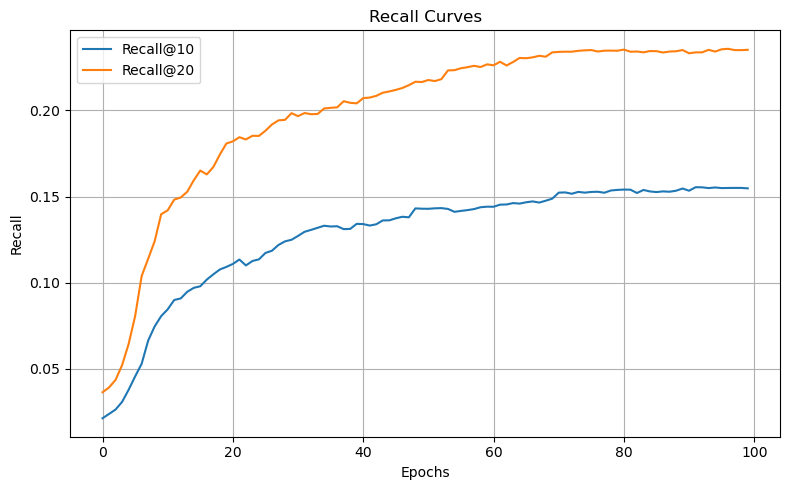

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(recall_at_k, label='Recall@10')
plt.plot(recall_at_k_20, label='Recall@20')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall Curves')
plt.grid()
plt.legend()
plt.tight_layout()  

**TODO:**
- change (generalize) recall@topK for val into `topk_metrics` for all topK metircs i.e. P@K, NDGC, MRR, ... both train and val

In [ ]:
import itertools
import os
import torch

def tune_hyperparams(dataset_name, device='cuda'):
    """
    Perform hyperparameter search for LightGCN model.

    Args:
        dataset_name (str): Name of the dataset (e.g., 'movielens-100k').
        device (str): Device to run training on ('cuda' or 'cpu').

    Returns:
        tuple: (best_params, best_val_metric)
    """
    print(f"Starting hyperparameter tuning for {dataset_name}...") 

    dataset_path = download_dataset(dataset_name)
    graph_obj_path = dataset_name + '_processed_graph.pt'
    
    if os.path.exists(graph_obj_path):
        data = torch.load(graph_obj_path, weights_only=False) # Ensure weights_only is False if graph structure is complex
        print(f"Loaded processed graph data from {graph_obj_path}")
    else:
        if dataset_name.lower() == 'movielens-100k':
            user_nodes, item_nodes, num_users, num_items = load_movielens_100k(dataset_path)
        elif dataset_name.lower() == 'movielens-1m':
            user_nodes, item_nodes, num_users, num_items = load_movielens_1m(dataset_path)
        elif dataset_name.lower() == 'yelp':
            # Assuming yelp_dataset_path is correctly pointing to the Yelp JSON files directory
            user_nodes, item_nodes, num_users, num_items = load_yelp_dataset(dataset_path)
        else:
            raise ValueError(f"Dataset {dataset_name} not supported for tuning.")
        print(f"Loaded {dataset_name} dataset with {num_users} users and {num_items} items")
        data = create_graph_data(user_nodes, item_nodes, num_users, num_items)
        data = split_edges(data, test_ratio=0.2, val_ratio=0.1) 
        

    data = data.to(device)
    num_users = data.num_users
    num_items = data.num_items


    # Dfine hyperparameter grid
    param_grid = {
        'embedding_dim': [32, 64],
        'num_layers': [3, 5, 8],
        'learning_rate': [0.001, 0.0005],
        'weight_decay': [1e-5, 1e-4],
        'negative_sampling_ratio': [5, 10],
        'batch_size': [1024]
    }

    best_params = {}
    best_val_metric = -1

    keys, values = zip(*param_grid.items())
    hyperparam_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    print(f"Total hyperparameter combinations to test: {len(hyperparam_combinations)}")

    for i, params in enumerate(hyperparam_combinations):
        print(f"\n--- Testing combination {i+1}/{len(hyperparam_combinations)} ---")
        print(f"Parameters: {params}")

        model = LightGCN(
            num_users=num_users,
            num_items=num_items,
            embedding_dim=params['embedding_dim'],
            num_layers=params['num_layers']
        ).to(device)

        # Use a smaller number of epochs for tuning to save time
        # The train_lightgcn function saves the best model based on validation AUC
        # and returns the history, which includes the best validation AUC.
        # A unique save_path for each tuning run model to avoid conflicts.
        tuning_model_save_path = f"temp_tuning_model_{dataset_name}_combo_{i+1}.pth"
        
        history = train_lightgcn(
            model,
            data,
            dataset_name=f"{dataset_name}_tuning_run_{i+1}", 
            epochs=15,  ## <--
            batch_size=params['batch_size'],
            learning_rate=params['learning_rate'],
            weight_decay=params['weight_decay'],
            device=device,
            negative_sampling_ratio=params['negative_sampling_ratio'],
            recall_k_list=[10, 20], # Can use val_auc or a specific recall metric for tuning
            save_path=tuning_model_save_path,
            save_best=False  # Save the best model for each tuning run
        )

        # set an argument for the metric to be used for tuning: currently using AUC
        current_val_metric = max(history['val_auc']) if history['val_auc'] else -1
        # current_val_metric = history['recall_at_k'][-1]['Recall@10'] if history['recall_at_k'] else -1
        
        print(f"Validation AUC for current params: {current_val_metric:.4f}")

        if current_val_metric > best_val_metric:
            best_val_metric = current_val_metric
            best_params = params
            print(f"*** New best parameters found: {best_params} with Val AUC: {best_val_metric:.4f} ***")
            # torch.save(model.state_dict(), f"best_tuning_model_{dataset_name}.pth")

        if os.path.exists(tuning_model_save_path):
            os.remove(tuning_model_save_path)
            # print(f"Removed temporary model: {tuning_model_save_path}")

    print("\n--- Hyperparameter Tuning Complete ---")
    print(f"Best Validation Metric (AUC): {best_val_metric:.4f}")
    print(f"Best Hyperparameters: {best_params}")
    
    return best_params, best_val_metric



In [ ]:
best_hyperparams, best_metric = tune_hyperparams(dataset_name='movielens-100k', device='cuda')
print("\nFinal Best Hyperparameters:", best_hyperparams)
print("Final Best Validation Metric (AUC):", best_metric)

Starting hyperparameter tuning for movielens-100k...
Loaded processed graph data from movielens-100k_processed_graph.pt
Total hyperparameter combinations to test: 48

--- Testing combination 1/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 3, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.53it/s]


Epoch 1/15
Train Loss: 0.6825
Val Loss: 0.6833
Val AUC-ROC: 0.5677
Val AUC-PR: 0.2087
Recall@10: 0.0167
Recall@20: 0.0295
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.20it/s]


Epoch 2/15
Train Loss: 0.6512
Val Loss: 0.6409
Val AUC-ROC: 0.6293
Val AUC-PR: 0.2567
Recall@10: 0.0288
Recall@20: 0.0510
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 14.12it/s]


Epoch 3/15
Train Loss: 0.5890
Val Loss: 0.5689
Val AUC-ROC: 0.7159
Val AUC-PR: 0.3291
Recall@10: 0.0514
Recall@20: 0.0945
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 14.97it/s]


Epoch 4/15
Train Loss: 0.5051
Val Loss: 0.4880
Val AUC-ROC: 0.7751
Val AUC-PR: 0.3817
Recall@10: 0.0769
Recall@20: 0.1352
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 15.68it/s]


Epoch 5/15
Train Loss: 0.4323
Val Loss: 0.4332
Val AUC-ROC: 0.7991
Val AUC-PR: 0.4119
Recall@10: 0.0923
Recall@20: 0.1576
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.95it/s]


Epoch 6/15
Train Loss: 0.3884
Val Loss: 0.4153
Val AUC-ROC: 0.8053
Val AUC-PR: 0.4075
Recall@10: 0.1024
Recall@20: 0.1728
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.48it/s]


Epoch 7/15
Train Loss: 0.3659
Val Loss: 0.3934
Val AUC-ROC: 0.8137
Val AUC-PR: 0.4228
Recall@10: 0.1093
Recall@20: 0.1834
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.40it/s]


Epoch 8/15
Train Loss: 0.3517
Val Loss: 0.3941
Val AUC-ROC: 0.8148
Val AUC-PR: 0.4195
Recall@10: 0.1206
Recall@20: 0.1917
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.13it/s]


Epoch 9/15
Train Loss: 0.3420
Val Loss: 0.3852
Val AUC-ROC: 0.8184
Val AUC-PR: 0.4233
Recall@10: 0.1247
Recall@20: 0.1928
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.57it/s]


Epoch 10/15
Train Loss: 0.3356
Val Loss: 0.3793
Val AUC-ROC: 0.8196
Val AUC-PR: 0.4310
Recall@10: 0.1287
Recall@20: 0.2055
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.69it/s]


Epoch 11/15
Train Loss: 0.3285
Val Loss: 0.3774
Val AUC-ROC: 0.8220
Val AUC-PR: 0.4273
Recall@10: 0.1309
Recall@20: 0.2127
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.11it/s]


Epoch 12/15
Train Loss: 0.3251
Val Loss: 0.3681
Val AUC-ROC: 0.8270
Val AUC-PR: 0.4374
Recall@10: 0.1399
Recall@20: 0.2169
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.10it/s]


Epoch 13/15
Train Loss: 0.3199
Val Loss: 0.3676
Val AUC-ROC: 0.8267
Val AUC-PR: 0.4421
Recall@10: 0.1471
Recall@20: 0.2269
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.12it/s]


Epoch 14/15
Train Loss: 0.3142
Val Loss: 0.3677
Val AUC-ROC: 0.8286
Val AUC-PR: 0.4344
Recall@10: 0.1510
Recall@20: 0.2329
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.63it/s]


Epoch 15/15
Train Loss: 0.3102
Val Loss: 0.3550
Val AUC-ROC: 0.8331
Val AUC-PR: 0.4451
Recall@10: 0.1580
Recall@20: 0.2385
--------------------------------------------------
Validation AUC for current params: 0.8331
*** New best parameters found: {'embedding_dim': 32, 'num_layers': 3, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'negative_sampling_ratio': 5, 'batch_size': 1024} with Val AUC: 0.8331 ***

--- Testing combination 2/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 3, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.56it/s]


Epoch 1/15
Train Loss: 0.6810
Val Loss: 0.6680
Val AUC-ROC: 0.5941
Val AUC-PR: 0.1255
Recall@10: 0.0161
Recall@20: 0.0318
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


Epoch 2/15
Train Loss: 0.6438
Val Loss: 0.6183
Val AUC-ROC: 0.6645
Val AUC-PR: 0.1649
Recall@10: 0.0288
Recall@20: 0.0564
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.67it/s]


Epoch 3/15
Train Loss: 0.5717
Val Loss: 0.5371
Val AUC-ROC: 0.7453
Val AUC-PR: 0.2183
Recall@10: 0.0571
Recall@20: 0.1112
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


Epoch 4/15
Train Loss: 0.4837
Val Loss: 0.4646
Val AUC-ROC: 0.7863
Val AUC-PR: 0.2442
Recall@10: 0.0837
Recall@20: 0.1419
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.89it/s]


Epoch 5/15
Train Loss: 0.4191
Val Loss: 0.4242
Val AUC-ROC: 0.8017
Val AUC-PR: 0.2539
Recall@10: 0.0942
Recall@20: 0.1566
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


Epoch 6/15
Train Loss: 0.3821
Val Loss: 0.4012
Val AUC-ROC: 0.8100
Val AUC-PR: 0.2645
Recall@10: 0.1023
Recall@20: 0.1664
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.73it/s]


Epoch 7/15
Train Loss: 0.3635
Val Loss: 0.3935
Val AUC-ROC: 0.8127
Val AUC-PR: 0.2626
Recall@10: 0.1043
Recall@20: 0.1717
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.47it/s]


Epoch 8/15
Train Loss: 0.3523
Val Loss: 0.3829
Val AUC-ROC: 0.8177
Val AUC-PR: 0.2724
Recall@10: 0.1063
Recall@20: 0.1833
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.53it/s]


Epoch 9/15
Train Loss: 0.3445
Val Loss: 0.3802
Val AUC-ROC: 0.8191
Val AUC-PR: 0.2730
Recall@10: 0.1148
Recall@20: 0.1864
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.75it/s]


Epoch 10/15
Train Loss: 0.3372
Val Loss: 0.3759
Val AUC-ROC: 0.8212
Val AUC-PR: 0.2768
Recall@10: 0.1198
Recall@20: 0.1902
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.91it/s]


Epoch 11/15
Train Loss: 0.3318
Val Loss: 0.3737
Val AUC-ROC: 0.8217
Val AUC-PR: 0.2747
Recall@10: 0.1301
Recall@20: 0.1930
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.95it/s]


Epoch 12/15
Train Loss: 0.3266
Val Loss: 0.3658
Val AUC-ROC: 0.8243
Val AUC-PR: 0.2797
Recall@10: 0.1368
Recall@20: 0.2060
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.57it/s]


Epoch 13/15
Train Loss: 0.3221
Val Loss: 0.3636
Val AUC-ROC: 0.8269
Val AUC-PR: 0.2821
Recall@10: 0.1385
Recall@20: 0.2202
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.07it/s]


Epoch 14/15
Train Loss: 0.3162
Val Loss: 0.3590
Val AUC-ROC: 0.8304
Val AUC-PR: 0.2860
Recall@10: 0.1438
Recall@20: 0.2342
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.67it/s]


Epoch 15/15
Train Loss: 0.3115
Val Loss: 0.3557
Val AUC-ROC: 0.8314
Val AUC-PR: 0.2871
Recall@10: 0.1494
Recall@20: 0.2424
--------------------------------------------------
Validation AUC for current params: 0.8314

--- Testing combination 3/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 3, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.86it/s]


Epoch 1/15
Train Loss: 0.6863
Val Loss: 0.6798
Val AUC-ROC: 0.5673
Val AUC-PR: 0.2083
Recall@10: 0.0231
Recall@20: 0.0374
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.67it/s]


Epoch 2/15
Train Loss: 0.6780
Val Loss: 0.6719
Val AUC-ROC: 0.5796
Val AUC-PR: 0.2172
Recall@10: 0.0249
Recall@20: 0.0417
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.65it/s]


Epoch 3/15
Train Loss: 0.6650
Val Loss: 0.6559
Val AUC-ROC: 0.6116
Val AUC-PR: 0.2411
Recall@10: 0.0281
Recall@20: 0.0473
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.28it/s]


Epoch 4/15
Train Loss: 0.6468
Val Loss: 0.6374
Val AUC-ROC: 0.6498
Val AUC-PR: 0.2736
Recall@10: 0.0361
Recall@20: 0.0628
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.03it/s]


Epoch 5/15
Train Loss: 0.6182
Val Loss: 0.6055
Val AUC-ROC: 0.7089
Val AUC-PR: 0.3278
Recall@10: 0.0559
Recall@20: 0.0824
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.53it/s]


Epoch 6/15
Train Loss: 0.5795
Val Loss: 0.5648
Val AUC-ROC: 0.7562
Val AUC-PR: 0.3767
Recall@10: 0.0715
Recall@20: 0.1207
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.85it/s]


Epoch 7/15
Train Loss: 0.5358
Val Loss: 0.5245
Val AUC-ROC: 0.7821
Val AUC-PR: 0.3985
Recall@10: 0.0901
Recall@20: 0.1467
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.42it/s]


Epoch 8/15
Train Loss: 0.4963
Val Loss: 0.4921
Val AUC-ROC: 0.7970
Val AUC-PR: 0.4141
Recall@10: 0.0938
Recall@20: 0.1628
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.78it/s]


Epoch 9/15
Train Loss: 0.4663
Val Loss: 0.4707
Val AUC-ROC: 0.8010
Val AUC-PR: 0.4164
Recall@10: 0.0974
Recall@20: 0.1749
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.32it/s]


Epoch 10/15
Train Loss: 0.4459
Val Loss: 0.4563
Val AUC-ROC: 0.8049
Val AUC-PR: 0.4175
Recall@10: 0.1070
Recall@20: 0.1771
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.71it/s]


Epoch 11/15
Train Loss: 0.4334
Val Loss: 0.4488
Val AUC-ROC: 0.8045
Val AUC-PR: 0.4198
Recall@10: 0.1102
Recall@20: 0.1767
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.77it/s]


Epoch 12/15
Train Loss: 0.4248
Val Loss: 0.4406
Val AUC-ROC: 0.8097
Val AUC-PR: 0.4240
Recall@10: 0.1088
Recall@20: 0.1830
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.05it/s]


Epoch 13/15
Train Loss: 0.4197
Val Loss: 0.4369
Val AUC-ROC: 0.8109
Val AUC-PR: 0.4229
Recall@10: 0.1112
Recall@20: 0.1861
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.58it/s]


Epoch 14/15
Train Loss: 0.4151
Val Loss: 0.4339
Val AUC-ROC: 0.8108
Val AUC-PR: 0.4275
Recall@10: 0.1100
Recall@20: 0.1880
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.63it/s]


Epoch 15/15
Train Loss: 0.4123
Val Loss: 0.4338
Val AUC-ROC: 0.8102
Val AUC-PR: 0.4252
Recall@10: 0.1089
Recall@20: 0.1884
--------------------------------------------------
Validation AUC for current params: 0.8109

--- Testing combination 4/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 3, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.56it/s]


Epoch 1/15
Train Loss: 0.6860
Val Loss: 0.6868
Val AUC-ROC: 0.5593
Val AUC-PR: 0.1107
Recall@10: 0.0159
Recall@20: 0.0235
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.87it/s]


Epoch 2/15
Train Loss: 0.6765
Val Loss: 0.6742
Val AUC-ROC: 0.5788
Val AUC-PR: 0.1190
Recall@10: 0.0169
Recall@20: 0.0260
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.99it/s]


Epoch 3/15
Train Loss: 0.6624
Val Loss: 0.6595
Val AUC-ROC: 0.6087
Val AUC-PR: 0.1314
Recall@10: 0.0188
Recall@20: 0.0333
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.67it/s]


Epoch 4/15
Train Loss: 0.6415
Val Loss: 0.6336
Val AUC-ROC: 0.6624
Val AUC-PR: 0.1614
Recall@10: 0.0293
Recall@20: 0.0513
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.83it/s]


Epoch 5/15
Train Loss: 0.6098
Val Loss: 0.5985
Val AUC-ROC: 0.7213
Val AUC-PR: 0.2030
Recall@10: 0.0441
Recall@20: 0.0779
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.05it/s]


Epoch 6/15
Train Loss: 0.5688
Val Loss: 0.5559
Val AUC-ROC: 0.7661
Val AUC-PR: 0.2389
Recall@10: 0.0660
Recall@20: 0.1136
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


Epoch 7/15
Train Loss: 0.5247
Val Loss: 0.5180
Val AUC-ROC: 0.7866
Val AUC-PR: 0.2499
Recall@10: 0.0836
Recall@20: 0.1376
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.16it/s]


Epoch 8/15
Train Loss: 0.4872
Val Loss: 0.4874
Val AUC-ROC: 0.8000
Val AUC-PR: 0.2622
Recall@10: 0.1027
Recall@20: 0.1480
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.00it/s]


Epoch 9/15
Train Loss: 0.4604
Val Loss: 0.4670
Val AUC-ROC: 0.8053
Val AUC-PR: 0.2685
Recall@10: 0.1021
Recall@20: 0.1572
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  5.08it/s]


Epoch 10/15
Train Loss: 0.4421
Val Loss: 0.4539
Val AUC-ROC: 0.8095
Val AUC-PR: 0.2729
Recall@10: 0.1077
Recall@20: 0.1641
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.79it/s]


Epoch 11/15
Train Loss: 0.4310
Val Loss: 0.4486
Val AUC-ROC: 0.8095
Val AUC-PR: 0.2657
Recall@10: 0.1074
Recall@20: 0.1702
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


Epoch 12/15
Train Loss: 0.4241
Val Loss: 0.4412
Val AUC-ROC: 0.8117
Val AUC-PR: 0.2708
Recall@10: 0.1127
Recall@20: 0.1727
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.32it/s]


Epoch 13/15
Train Loss: 0.4190
Val Loss: 0.4380
Val AUC-ROC: 0.8118
Val AUC-PR: 0.2705
Recall@10: 0.1131
Recall@20: 0.1721
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.55it/s]


Epoch 14/15
Train Loss: 0.4149
Val Loss: 0.4369
Val AUC-ROC: 0.8113
Val AUC-PR: 0.2716
Recall@10: 0.1184
Recall@20: 0.1746
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.23it/s]


Epoch 15/15
Train Loss: 0.4134
Val Loss: 0.4354
Val AUC-ROC: 0.8125
Val AUC-PR: 0.2707
Recall@10: 0.1182
Recall@20: 0.1717
--------------------------------------------------
Validation AUC for current params: 0.8125

--- Testing combination 5/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 3, 'learning_rate': 0.0005, 'weight_decay': 1e-05, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.13it/s]


Epoch 1/15
Train Loss: 0.6814
Val Loss: 0.6752
Val AUC-ROC: 0.5829
Val AUC-PR: 0.2133
Recall@10: 0.0189
Recall@20: 0.0314
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.36it/s]


Epoch 2/15
Train Loss: 0.6654
Val Loss: 0.6614
Val AUC-ROC: 0.6041
Val AUC-PR: 0.2307
Recall@10: 0.0213
Recall@20: 0.0395
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.46it/s]


Epoch 3/15
Train Loss: 0.6419
Val Loss: 0.6329
Val AUC-ROC: 0.6426
Val AUC-PR: 0.2630
Recall@10: 0.0274
Recall@20: 0.0493
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.83it/s]


Epoch 4/15
Train Loss: 0.6090
Val Loss: 0.5987
Val AUC-ROC: 0.6851
Val AUC-PR: 0.2991
Recall@10: 0.0376
Recall@20: 0.0711
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 14.45it/s]


Epoch 5/15
Train Loss: 0.5692
Val Loss: 0.5596
Val AUC-ROC: 0.7239
Val AUC-PR: 0.3348
Recall@10: 0.0539
Recall@20: 0.0966
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.41it/s]


Epoch 6/15
Train Loss: 0.5250
Val Loss: 0.5207
Val AUC-ROC: 0.7553
Val AUC-PR: 0.3603
Recall@10: 0.0710
Recall@20: 0.1167
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.44it/s]


Epoch 7/15
Train Loss: 0.4840
Val Loss: 0.4822
Val AUC-ROC: 0.7773
Val AUC-PR: 0.3852
Recall@10: 0.0839
Recall@20: 0.1378
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.03it/s]


Epoch 8/15
Train Loss: 0.4472
Val Loss: 0.4558
Val AUC-ROC: 0.7891
Val AUC-PR: 0.3960
Recall@10: 0.0927
Recall@20: 0.1518
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.98it/s]


Epoch 9/15
Train Loss: 0.4207
Val Loss: 0.4396
Val AUC-ROC: 0.7959
Val AUC-PR: 0.3991
Recall@10: 0.1023
Recall@20: 0.1596
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.30it/s]


Epoch 10/15
Train Loss: 0.4000
Val Loss: 0.4204
Val AUC-ROC: 0.8011
Val AUC-PR: 0.4085
Recall@10: 0.1044
Recall@20: 0.1643
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.58it/s]


Epoch 11/15
Train Loss: 0.3854
Val Loss: 0.4125
Val AUC-ROC: 0.8038
Val AUC-PR: 0.4067
Recall@10: 0.1054
Recall@20: 0.1665
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.76it/s]


Epoch 12/15
Train Loss: 0.3738
Val Loss: 0.4008
Val AUC-ROC: 0.8109
Val AUC-PR: 0.4174
Recall@10: 0.1123
Recall@20: 0.1702
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.38it/s]


Epoch 13/15
Train Loss: 0.3650
Val Loss: 0.4004
Val AUC-ROC: 0.8091
Val AUC-PR: 0.4173
Recall@10: 0.1149
Recall@20: 0.1735
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.04it/s]


Epoch 14/15
Train Loss: 0.3577
Val Loss: 0.3984
Val AUC-ROC: 0.8106
Val AUC-PR: 0.4145
Recall@10: 0.1154
Recall@20: 0.1799
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.49it/s]


Epoch 15/15
Train Loss: 0.3524
Val Loss: 0.3942
Val AUC-ROC: 0.8130
Val AUC-PR: 0.4198
Recall@10: 0.1210
Recall@20: 0.1824
--------------------------------------------------
Validation AUC for current params: 0.8130

--- Testing combination 6/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 3, 'learning_rate': 0.0005, 'weight_decay': 1e-05, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.60it/s]


Epoch 1/15
Train Loss: 0.6891
Val Loss: 0.6856
Val AUC-ROC: 0.5631
Val AUC-PR: 0.1099
Recall@10: 0.0185
Recall@20: 0.0280
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


Epoch 2/15
Train Loss: 0.6790
Val Loss: 0.6762
Val AUC-ROC: 0.5780
Val AUC-PR: 0.1163
Recall@10: 0.0193
Recall@20: 0.0292
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.60it/s]


Epoch 3/15
Train Loss: 0.6637
Val Loss: 0.6573
Val AUC-ROC: 0.6065
Val AUC-PR: 0.1311
Recall@10: 0.0247
Recall@20: 0.0392
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.62it/s]


Epoch 4/15
Train Loss: 0.6393
Val Loss: 0.6309
Val AUC-ROC: 0.6464
Val AUC-PR: 0.1537
Recall@10: 0.0287
Recall@20: 0.0579
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


Epoch 5/15
Train Loss: 0.6042
Val Loss: 0.5931
Val AUC-ROC: 0.6935
Val AUC-PR: 0.1841
Recall@10: 0.0411
Recall@20: 0.0767
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.52it/s]


Epoch 6/15
Train Loss: 0.5597
Val Loss: 0.5497
Val AUC-ROC: 0.7353
Val AUC-PR: 0.2090
Recall@10: 0.0540
Recall@20: 0.1041
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.76it/s]


Epoch 7/15
Train Loss: 0.5123
Val Loss: 0.5061
Val AUC-ROC: 0.7656
Val AUC-PR: 0.2299
Recall@10: 0.0761
Recall@20: 0.1186
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.88it/s]


Epoch 8/15
Train Loss: 0.4691
Val Loss: 0.4715
Val AUC-ROC: 0.7833
Val AUC-PR: 0.2439
Recall@10: 0.0821
Recall@20: 0.1331
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.50it/s]


Epoch 9/15
Train Loss: 0.4342
Val Loss: 0.4445
Val AUC-ROC: 0.7943
Val AUC-PR: 0.2525
Recall@10: 0.0888
Recall@20: 0.1479
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Epoch 10/15
Train Loss: 0.4077
Val Loss: 0.4229
Val AUC-ROC: 0.8026
Val AUC-PR: 0.2588
Recall@10: 0.0941
Recall@20: 0.1610
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


Epoch 11/15
Train Loss: 0.3892
Val Loss: 0.4108
Val AUC-ROC: 0.8066
Val AUC-PR: 0.2622
Recall@10: 0.0993
Recall@20: 0.1675
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.76it/s]


Epoch 12/15
Train Loss: 0.3754
Val Loss: 0.4027
Val AUC-ROC: 0.8096
Val AUC-PR: 0.2637
Recall@10: 0.1043
Recall@20: 0.1752
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.45it/s]


Epoch 13/15
Train Loss: 0.3651
Val Loss: 0.3945
Val AUC-ROC: 0.8124
Val AUC-PR: 0.2687
Recall@10: 0.1103
Recall@20: 0.1751
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.68it/s]


Epoch 14/15
Train Loss: 0.3584
Val Loss: 0.3899
Val AUC-ROC: 0.8134
Val AUC-PR: 0.2687
Recall@10: 0.1086
Recall@20: 0.1820
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.57it/s]


Epoch 15/15
Train Loss: 0.3516
Val Loss: 0.3881
Val AUC-ROC: 0.8141
Val AUC-PR: 0.2681
Recall@10: 0.1137
Recall@20: 0.1864
--------------------------------------------------
Validation AUC for current params: 0.8141

--- Testing combination 7/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 3, 'learning_rate': 0.0005, 'weight_decay': 0.0001, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.91it/s]


Epoch 1/15
Train Loss: 0.6887
Val Loss: 0.6846
Val AUC-ROC: 0.5642
Val AUC-PR: 0.2013
Recall@10: 0.0181
Recall@20: 0.0289
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.55it/s]


Epoch 2/15
Train Loss: 0.6838
Val Loss: 0.6821
Val AUC-ROC: 0.5660
Val AUC-PR: 0.2039
Recall@10: 0.0172
Recall@20: 0.0308
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.65it/s]


Epoch 3/15
Train Loss: 0.6787
Val Loss: 0.6762
Val AUC-ROC: 0.5751
Val AUC-PR: 0.2091
Recall@10: 0.0177
Recall@20: 0.0337
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.67it/s]


Epoch 4/15
Train Loss: 0.6731
Val Loss: 0.6710
Val AUC-ROC: 0.5839
Val AUC-PR: 0.2177
Recall@10: 0.0188
Recall@20: 0.0369
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.78it/s]


Epoch 5/15
Train Loss: 0.6662
Val Loss: 0.6658
Val AUC-ROC: 0.5937
Val AUC-PR: 0.2244
Recall@10: 0.0201
Recall@20: 0.0424
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.16it/s]


Epoch 6/15
Train Loss: 0.6577
Val Loss: 0.6556
Val AUC-ROC: 0.6138
Val AUC-PR: 0.2415
Recall@10: 0.0239
Recall@20: 0.0481
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.02it/s]


Epoch 7/15
Train Loss: 0.6477
Val Loss: 0.6465
Val AUC-ROC: 0.6327
Val AUC-PR: 0.2569
Recall@10: 0.0263
Recall@20: 0.0528
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.10it/s]


Epoch 8/15
Train Loss: 0.6351
Val Loss: 0.6331
Val AUC-ROC: 0.6580
Val AUC-PR: 0.2809
Recall@10: 0.0362
Recall@20: 0.0651
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.01it/s]


Epoch 9/15
Train Loss: 0.6202
Val Loss: 0.6199
Val AUC-ROC: 0.6815
Val AUC-PR: 0.3033
Recall@10: 0.0451
Recall@20: 0.0747
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.00it/s]


Epoch 10/15
Train Loss: 0.6022
Val Loss: 0.5992
Val AUC-ROC: 0.7142
Val AUC-PR: 0.3346
Recall@10: 0.0525
Recall@20: 0.0942
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.44it/s]


Epoch 11/15
Train Loss: 0.5821
Val Loss: 0.5821
Val AUC-ROC: 0.7329
Val AUC-PR: 0.3503
Recall@10: 0.0593
Recall@20: 0.1044
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.51it/s]


Epoch 12/15
Train Loss: 0.5620
Val Loss: 0.5614
Val AUC-ROC: 0.7534
Val AUC-PR: 0.3767
Recall@10: 0.0699
Recall@20: 0.1199
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.01it/s]


Epoch 13/15
Train Loss: 0.5399
Val Loss: 0.5438
Val AUC-ROC: 0.7665
Val AUC-PR: 0.3819
Recall@10: 0.0732
Recall@20: 0.1280
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.73it/s]


Epoch 14/15
Train Loss: 0.5201
Val Loss: 0.5222
Val AUC-ROC: 0.7799
Val AUC-PR: 0.4019
Recall@10: 0.0844
Recall@20: 0.1392
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.58it/s]


Epoch 15/15
Train Loss: 0.5015
Val Loss: 0.5097
Val AUC-ROC: 0.7836
Val AUC-PR: 0.3986
Recall@10: 0.0895
Recall@20: 0.1420
--------------------------------------------------
Validation AUC for current params: 0.7836

--- Testing combination 8/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 3, 'learning_rate': 0.0005, 'weight_decay': 0.0001, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.48it/s]


Epoch 1/15
Train Loss: 0.6863
Val Loss: 0.6842
Val AUC-ROC: 0.5677
Val AUC-PR: 0.1138
Recall@10: 0.0172
Recall@20: 0.0330
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.76it/s]


Epoch 2/15
Train Loss: 0.6816
Val Loss: 0.6816
Val AUC-ROC: 0.5712
Val AUC-PR: 0.1155
Recall@10: 0.0197
Recall@20: 0.0356
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.40it/s]


Epoch 3/15
Train Loss: 0.6760
Val Loss: 0.6761
Val AUC-ROC: 0.5788
Val AUC-PR: 0.1194
Recall@10: 0.0211
Recall@20: 0.0369
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.50it/s]


Epoch 4/15
Train Loss: 0.6707
Val Loss: 0.6702
Val AUC-ROC: 0.5900
Val AUC-PR: 0.1252
Recall@10: 0.0235
Recall@20: 0.0388
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.02it/s]


Epoch 5/15
Train Loss: 0.6638
Val Loss: 0.6627
Val AUC-ROC: 0.6039
Val AUC-PR: 0.1319
Recall@10: 0.0264
Recall@20: 0.0441
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.07it/s]


Epoch 6/15
Train Loss: 0.6557
Val Loss: 0.6544
Val AUC-ROC: 0.6200
Val AUC-PR: 0.1409
Recall@10: 0.0304
Recall@20: 0.0483
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.59it/s]


Epoch 7/15
Train Loss: 0.6451
Val Loss: 0.6438
Val AUC-ROC: 0.6408
Val AUC-PR: 0.1550
Recall@10: 0.0332
Recall@20: 0.0583
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.87it/s]


Epoch 8/15
Train Loss: 0.6323
Val Loss: 0.6305
Val AUC-ROC: 0.6662
Val AUC-PR: 0.1739
Recall@10: 0.0401
Recall@20: 0.0733
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.88it/s]


Epoch 9/15
Train Loss: 0.6170
Val Loss: 0.6131
Val AUC-ROC: 0.6961
Val AUC-PR: 0.1937
Recall@10: 0.0500
Recall@20: 0.0874
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.42it/s]


Epoch 10/15
Train Loss: 0.5987
Val Loss: 0.5954
Val AUC-ROC: 0.7196
Val AUC-PR: 0.2145
Recall@10: 0.0562
Recall@20: 0.1011
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.98it/s]


Epoch 11/15
Train Loss: 0.5786
Val Loss: 0.5761
Val AUC-ROC: 0.7427
Val AUC-PR: 0.2277
Recall@10: 0.0702
Recall@20: 0.1199
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.57it/s]


Epoch 12/15
Train Loss: 0.5573
Val Loss: 0.5580
Val AUC-ROC: 0.7583
Val AUC-PR: 0.2397
Recall@10: 0.0783
Recall@20: 0.1301
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.39it/s]


Epoch 13/15
Train Loss: 0.5356
Val Loss: 0.5384
Val AUC-ROC: 0.7708
Val AUC-PR: 0.2451
Recall@10: 0.0883
Recall@20: 0.1396
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.21it/s]


Epoch 14/15
Train Loss: 0.5155
Val Loss: 0.5195
Val AUC-ROC: 0.7814
Val AUC-PR: 0.2529
Recall@10: 0.0937
Recall@20: 0.1484
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.18it/s]


Epoch 15/15
Train Loss: 0.4972
Val Loss: 0.5033
Val AUC-ROC: 0.7896
Val AUC-PR: 0.2615
Recall@10: 0.0962
Recall@20: 0.1550
--------------------------------------------------
Validation AUC for current params: 0.7896

--- Testing combination 9/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 5, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.67it/s]


Epoch 1/15
Train Loss: 0.6688
Val Loss: 0.6485
Val AUC-ROC: 0.6580
Val AUC-PR: 0.2804
Recall@10: 0.0391
Recall@20: 0.0693
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.37it/s]


Epoch 2/15
Train Loss: 0.5993
Val Loss: 0.5457
Val AUC-ROC: 0.7815
Val AUC-PR: 0.3783
Recall@10: 0.0926
Recall@20: 0.1563
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.41it/s]


Epoch 3/15
Train Loss: 0.4772
Val Loss: 0.4398
Val AUC-ROC: 0.8098
Val AUC-PR: 0.4080
Recall@10: 0.1088
Recall@20: 0.1862
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.64it/s]


Epoch 4/15
Train Loss: 0.4024
Val Loss: 0.4110
Val AUC-ROC: 0.8111
Val AUC-PR: 0.4097
Recall@10: 0.1099
Recall@20: 0.1880
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.97it/s]


Epoch 5/15
Train Loss: 0.3750
Val Loss: 0.3987
Val AUC-ROC: 0.8124
Val AUC-PR: 0.4128
Recall@10: 0.1125
Recall@20: 0.1886
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.39it/s]


Epoch 6/15
Train Loss: 0.3654
Val Loss: 0.3980
Val AUC-ROC: 0.8100
Val AUC-PR: 0.4098
Recall@10: 0.1125
Recall@20: 0.1848
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.76it/s]


Epoch 7/15
Train Loss: 0.3617
Val Loss: 0.3940
Val AUC-ROC: 0.8130
Val AUC-PR: 0.4147
Recall@10: 0.1118
Recall@20: 0.1839
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.03it/s]


Epoch 8/15
Train Loss: 0.3584
Val Loss: 0.3908
Val AUC-ROC: 0.8124
Val AUC-PR: 0.4148
Recall@10: 0.1123
Recall@20: 0.1824
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.88it/s]


Epoch 9/15
Train Loss: 0.3559
Val Loss: 0.3966
Val AUC-ROC: 0.8104
Val AUC-PR: 0.4111
Recall@10: 0.1140
Recall@20: 0.1848
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.43it/s]


Epoch 10/15
Train Loss: 0.3532
Val Loss: 0.3922
Val AUC-ROC: 0.8103
Val AUC-PR: 0.4083
Recall@10: 0.1162
Recall@20: 0.1891
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.36it/s]


Epoch 11/15
Train Loss: 0.3524
Val Loss: 0.3895
Val AUC-ROC: 0.8132
Val AUC-PR: 0.4182
Recall@10: 0.1197
Recall@20: 0.1915
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.01it/s]


Epoch 12/15
Train Loss: 0.3503
Val Loss: 0.3843
Val AUC-ROC: 0.8127
Val AUC-PR: 0.4183
Recall@10: 0.1217
Recall@20: 0.1974
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.01it/s]


Epoch 13/15
Train Loss: 0.3489
Val Loss: 0.3882
Val AUC-ROC: 0.8143
Val AUC-PR: 0.4170
Recall@10: 0.1265
Recall@20: 0.2016
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.53it/s]


Epoch 14/15
Train Loss: 0.3458
Val Loss: 0.3905
Val AUC-ROC: 0.8139
Val AUC-PR: 0.4132
Recall@10: 0.1315
Recall@20: 0.2044
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.46it/s]


Epoch 15/15
Train Loss: 0.3425
Val Loss: 0.3852
Val AUC-ROC: 0.8162
Val AUC-PR: 0.4159
Recall@10: 0.1364
Recall@20: 0.2066
--------------------------------------------------
Validation AUC for current params: 0.8162

--- Testing combination 10/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 5, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.51it/s]


Epoch 1/15
Train Loss: 0.6593
Val Loss: 0.6302
Val AUC-ROC: 0.6923
Val AUC-PR: 0.1865
Recall@10: 0.0440
Recall@20: 0.0817
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


Epoch 2/15
Train Loss: 0.5733
Val Loss: 0.5193
Val AUC-ROC: 0.7870
Val AUC-PR: 0.2463
Recall@10: 0.0856
Recall@20: 0.1517
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.25it/s]


Epoch 3/15
Train Loss: 0.4589
Val Loss: 0.4360
Val AUC-ROC: 0.8050
Val AUC-PR: 0.2557
Recall@10: 0.1058
Recall@20: 0.1745
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.58it/s]


Epoch 4/15
Train Loss: 0.3972
Val Loss: 0.4059
Val AUC-ROC: 0.8088
Val AUC-PR: 0.2601
Recall@10: 0.1189
Recall@20: 0.1821
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.89it/s]


Epoch 5/15
Train Loss: 0.3746
Val Loss: 0.3952
Val AUC-ROC: 0.8107
Val AUC-PR: 0.2647
Recall@10: 0.1177
Recall@20: 0.1791
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.54it/s]


Epoch 6/15
Train Loss: 0.3654
Val Loss: 0.3943
Val AUC-ROC: 0.8121
Val AUC-PR: 0.2627
Recall@10: 0.1194
Recall@20: 0.1763
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.84it/s]


Epoch 7/15
Train Loss: 0.3620
Val Loss: 0.3899
Val AUC-ROC: 0.8117
Val AUC-PR: 0.2649
Recall@10: 0.1223
Recall@20: 0.1772
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.26it/s]


Epoch 8/15
Train Loss: 0.3585
Val Loss: 0.3897
Val AUC-ROC: 0.8123
Val AUC-PR: 0.2653
Recall@10: 0.1251
Recall@20: 0.1801
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.30it/s]


Epoch 9/15
Train Loss: 0.3544
Val Loss: 0.3881
Val AUC-ROC: 0.8133
Val AUC-PR: 0.2658
Recall@10: 0.1267
Recall@20: 0.1807
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.02it/s]


Epoch 10/15
Train Loss: 0.3526
Val Loss: 0.3905
Val AUC-ROC: 0.8129
Val AUC-PR: 0.2661
Recall@10: 0.1295
Recall@20: 0.1872
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.79it/s]


Epoch 11/15
Train Loss: 0.3520
Val Loss: 0.3872
Val AUC-ROC: 0.8136
Val AUC-PR: 0.2667
Recall@10: 0.1314
Recall@20: 0.1946
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.79it/s]


Epoch 12/15
Train Loss: 0.3481
Val Loss: 0.3857
Val AUC-ROC: 0.8145
Val AUC-PR: 0.2686
Recall@10: 0.1315
Recall@20: 0.1957
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  5.77it/s]


Epoch 13/15
Train Loss: 0.3459
Val Loss: 0.3861
Val AUC-ROC: 0.8144
Val AUC-PR: 0.2671
Recall@10: 0.1338
Recall@20: 0.2019
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  4.65it/s]


Epoch 14/15
Train Loss: 0.3430
Val Loss: 0.3825
Val AUC-ROC: 0.8163
Val AUC-PR: 0.2725
Recall@10: 0.1372
Recall@20: 0.2118
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.96it/s]


Epoch 15/15
Train Loss: 0.3407
Val Loss: 0.3782
Val AUC-ROC: 0.8188
Val AUC-PR: 0.2739
Recall@10: 0.1391
Recall@20: 0.2210
--------------------------------------------------
Validation AUC for current params: 0.8188

--- Testing combination 11/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 5, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.64it/s]


Epoch 1/15
Train Loss: 0.6755
Val Loss: 0.6725
Val AUC-ROC: 0.5917
Val AUC-PR: 0.2244
Recall@10: 0.0197
Recall@20: 0.0390
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.80it/s]


Epoch 2/15
Train Loss: 0.6673
Val Loss: 0.6622
Val AUC-ROC: 0.6344
Val AUC-PR: 0.2566
Recall@10: 0.0258
Recall@20: 0.0504
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.62it/s]


Epoch 3/15
Train Loss: 0.6514
Val Loss: 0.6406
Val AUC-ROC: 0.7030
Val AUC-PR: 0.3207
Recall@10: 0.0388
Recall@20: 0.0734
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.36it/s]


Epoch 4/15
Train Loss: 0.6213
Val Loss: 0.6031
Val AUC-ROC: 0.7660
Val AUC-PR: 0.3797
Recall@10: 0.0698
Recall@20: 0.1175
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.90it/s]


Epoch 5/15
Train Loss: 0.5745
Val Loss: 0.5561
Val AUC-ROC: 0.7913
Val AUC-PR: 0.3990
Recall@10: 0.0944
Recall@20: 0.1545
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.34it/s]


Epoch 6/15
Train Loss: 0.5244
Val Loss: 0.5122
Val AUC-ROC: 0.8014
Val AUC-PR: 0.4047
Recall@10: 0.1036
Recall@20: 0.1715
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.30it/s]


Epoch 7/15
Train Loss: 0.4844
Val Loss: 0.4848
Val AUC-ROC: 0.8045
Val AUC-PR: 0.4087
Recall@10: 0.1080
Recall@20: 0.1773
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 14.00it/s]


Epoch 8/15
Train Loss: 0.4607
Val Loss: 0.4712
Val AUC-ROC: 0.8034
Val AUC-PR: 0.4033
Recall@10: 0.1106
Recall@20: 0.1798
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.74it/s]


Epoch 9/15
Train Loss: 0.4468
Val Loss: 0.4599
Val AUC-ROC: 0.8060
Val AUC-PR: 0.4108
Recall@10: 0.1130
Recall@20: 0.1771
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.88it/s]


Epoch 10/15
Train Loss: 0.4392
Val Loss: 0.4530
Val AUC-ROC: 0.8079
Val AUC-PR: 0.4147
Recall@10: 0.1170
Recall@20: 0.1781
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.35it/s]


Epoch 11/15
Train Loss: 0.4335
Val Loss: 0.4469
Val AUC-ROC: 0.8082
Val AUC-PR: 0.4180
Recall@10: 0.1152
Recall@20: 0.1791
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.60it/s]


Epoch 12/15
Train Loss: 0.4306
Val Loss: 0.4497
Val AUC-ROC: 0.8054
Val AUC-PR: 0.4102
Recall@10: 0.1152
Recall@20: 0.1800
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.76it/s]


Epoch 13/15
Train Loss: 0.4262
Val Loss: 0.4467
Val AUC-ROC: 0.8051
Val AUC-PR: 0.4045
Recall@10: 0.1150
Recall@20: 0.1796
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.26it/s]


Epoch 14/15
Train Loss: 0.4233
Val Loss: 0.4437
Val AUC-ROC: 0.8057
Val AUC-PR: 0.4088
Recall@10: 0.1138
Recall@20: 0.1785
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.55it/s]


Epoch 15/15
Train Loss: 0.4210
Val Loss: 0.4398
Val AUC-ROC: 0.8081
Val AUC-PR: 0.4150
Recall@10: 0.1134
Recall@20: 0.1786
--------------------------------------------------
Validation AUC for current params: 0.8082

--- Testing combination 12/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 5, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.83it/s]


Epoch 1/15
Train Loss: 0.6762
Val Loss: 0.6760
Val AUC-ROC: 0.5834
Val AUC-PR: 0.1234
Recall@10: 0.0197
Recall@20: 0.0331
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.40it/s]


Epoch 2/15
Train Loss: 0.6686
Val Loss: 0.6658
Val AUC-ROC: 0.6237
Val AUC-PR: 0.1450
Recall@10: 0.0253
Recall@20: 0.0440
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  5.75it/s]


Epoch 3/15
Train Loss: 0.6532
Val Loss: 0.6446
Val AUC-ROC: 0.6919
Val AUC-PR: 0.1874
Recall@10: 0.0422
Recall@20: 0.0699
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.43it/s]


Epoch 4/15
Train Loss: 0.6234
Val Loss: 0.6086
Val AUC-ROC: 0.7526
Val AUC-PR: 0.2278
Recall@10: 0.0660
Recall@20: 0.1128
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.39it/s]


Epoch 5/15
Train Loss: 0.5765
Val Loss: 0.5597
Val AUC-ROC: 0.7840
Val AUC-PR: 0.2483
Recall@10: 0.0916
Recall@20: 0.1453
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


Epoch 6/15
Train Loss: 0.5255
Val Loss: 0.5152
Val AUC-ROC: 0.7957
Val AUC-PR: 0.2572
Recall@10: 0.1061
Recall@20: 0.1633
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]


Epoch 7/15
Train Loss: 0.4850
Val Loss: 0.4876
Val AUC-ROC: 0.7994
Val AUC-PR: 0.2555
Recall@10: 0.1110
Recall@20: 0.1735
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


Epoch 8/15
Train Loss: 0.4595
Val Loss: 0.4694
Val AUC-ROC: 0.8028
Val AUC-PR: 0.2622
Recall@10: 0.1142
Recall@20: 0.1810
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]


Epoch 9/15
Train Loss: 0.4460
Val Loss: 0.4604
Val AUC-ROC: 0.8037
Val AUC-PR: 0.2606
Recall@10: 0.1141
Recall@20: 0.1800
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]


Epoch 10/15
Train Loss: 0.4381
Val Loss: 0.4561
Val AUC-ROC: 0.8036
Val AUC-PR: 0.2585
Recall@10: 0.1126
Recall@20: 0.1777
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]


Epoch 11/15
Train Loss: 0.4325
Val Loss: 0.4504
Val AUC-ROC: 0.8050
Val AUC-PR: 0.2623
Recall@10: 0.1139
Recall@20: 0.1800
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]


Epoch 12/15
Train Loss: 0.4287
Val Loss: 0.4472
Val AUC-ROC: 0.8063
Val AUC-PR: 0.2635
Recall@10: 0.1153
Recall@20: 0.1814
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.43it/s]


Epoch 13/15
Train Loss: 0.4254
Val Loss: 0.4459
Val AUC-ROC: 0.8058
Val AUC-PR: 0.2615
Recall@10: 0.1152
Recall@20: 0.1830
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]


Epoch 14/15
Train Loss: 0.4237
Val Loss: 0.4432
Val AUC-ROC: 0.8068
Val AUC-PR: 0.2647
Recall@10: 0.1162
Recall@20: 0.1819
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]


Epoch 15/15
Train Loss: 0.4210
Val Loss: 0.4441
Val AUC-ROC: 0.8052
Val AUC-PR: 0.2610
Recall@10: 0.1137
Recall@20: 0.1825
--------------------------------------------------
Validation AUC for current params: 0.8068

--- Testing combination 13/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 5, 'learning_rate': 0.0005, 'weight_decay': 1e-05, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]


Epoch 1/15
Train Loss: 0.6708
Val Loss: 0.6609
Val AUC-ROC: 0.6248
Val AUC-PR: 0.2555
Recall@10: 0.0346
Recall@20: 0.0531
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  4.64it/s]


Epoch 2/15
Train Loss: 0.6473
Val Loss: 0.6298
Val AUC-ROC: 0.6949
Val AUC-PR: 0.3187
Recall@10: 0.0552
Recall@20: 0.0887
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  4.02it/s]


Epoch 3/15
Train Loss: 0.6030
Val Loss: 0.5780
Val AUC-ROC: 0.7567
Val AUC-PR: 0.3729
Recall@10: 0.0866
Recall@20: 0.1347
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  4.09it/s]


Epoch 4/15
Train Loss: 0.5419
Val Loss: 0.5197
Val AUC-ROC: 0.7865
Val AUC-PR: 0.3962
Recall@10: 0.1086
Recall@20: 0.1602
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.84it/s]


Epoch 5/15
Train Loss: 0.4824
Val Loss: 0.4714
Val AUC-ROC: 0.7982
Val AUC-PR: 0.4048
Recall@10: 0.1195
Recall@20: 0.1772
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  4.29it/s]


Epoch 6/15
Train Loss: 0.4372
Val Loss: 0.4389
Val AUC-ROC: 0.8038
Val AUC-PR: 0.4092
Recall@10: 0.1239
Recall@20: 0.1822
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


Epoch 7/15
Train Loss: 0.4080
Val Loss: 0.4190
Val AUC-ROC: 0.8072
Val AUC-PR: 0.4139
Recall@10: 0.1240
Recall@20: 0.1854
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.60it/s]


Epoch 8/15
Train Loss: 0.3879
Val Loss: 0.4073
Val AUC-ROC: 0.8090
Val AUC-PR: 0.4149
Recall@10: 0.1270
Recall@20: 0.1881
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.54it/s]


Epoch 9/15
Train Loss: 0.3790
Val Loss: 0.4025
Val AUC-ROC: 0.8097
Val AUC-PR: 0.4147
Recall@10: 0.1273
Recall@20: 0.1843
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]


Epoch 10/15
Train Loss: 0.3712
Val Loss: 0.4023
Val AUC-ROC: 0.8102
Val AUC-PR: 0.4129
Recall@10: 0.1245
Recall@20: 0.1857
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  4.44it/s]


Epoch 11/15
Train Loss: 0.3661
Val Loss: 0.4053
Val AUC-ROC: 0.8067
Val AUC-PR: 0.4086
Recall@10: 0.1232
Recall@20: 0.1877
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


Epoch 12/15
Train Loss: 0.3649
Val Loss: 0.3976
Val AUC-ROC: 0.8096
Val AUC-PR: 0.4179
Recall@10: 0.1239
Recall@20: 0.1871
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


Epoch 13/15
Train Loss: 0.3622
Val Loss: 0.4011
Val AUC-ROC: 0.8088
Val AUC-PR: 0.4118
Recall@10: 0.1232
Recall@20: 0.1877
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.23it/s]


Epoch 14/15
Train Loss: 0.3604
Val Loss: 0.3942
Val AUC-ROC: 0.8105
Val AUC-PR: 0.4166
Recall@10: 0.1243
Recall@20: 0.1883
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  4.04it/s]


Epoch 15/15
Train Loss: 0.3578
Val Loss: 0.3943
Val AUC-ROC: 0.8111
Val AUC-PR: 0.4171
Recall@10: 0.1236
Recall@20: 0.1919
--------------------------------------------------
Validation AUC for current params: 0.8111

--- Testing combination 14/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 5, 'learning_rate': 0.0005, 'weight_decay': 1e-05, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


Epoch 1/15
Train Loss: 0.6696
Val Loss: 0.6644
Val AUC-ROC: 0.6103
Val AUC-PR: 0.1379
Recall@10: 0.0266
Recall@20: 0.0489
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]


Epoch 2/15
Train Loss: 0.6429
Val Loss: 0.6289
Val AUC-ROC: 0.6887
Val AUC-PR: 0.1855
Recall@10: 0.0421
Recall@20: 0.0811
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.39it/s]


Epoch 3/15
Train Loss: 0.5932
Val Loss: 0.5717
Val AUC-ROC: 0.7536
Val AUC-PR: 0.2261
Recall@10: 0.0730
Recall@20: 0.1229
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]


Epoch 4/15
Train Loss: 0.5288
Val Loss: 0.5107
Val AUC-ROC: 0.7852
Val AUC-PR: 0.2463
Recall@10: 0.0842
Recall@20: 0.1469
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]


Epoch 5/15
Train Loss: 0.4696
Val Loss: 0.4657
Val AUC-ROC: 0.7963
Val AUC-PR: 0.2532
Recall@10: 0.0959
Recall@20: 0.1626
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]


Epoch 6/15
Train Loss: 0.4272
Val Loss: 0.4392
Val AUC-ROC: 0.8002
Val AUC-PR: 0.2494
Recall@10: 0.0990
Recall@20: 0.1734
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]


Epoch 7/15
Train Loss: 0.4013
Val Loss: 0.4225
Val AUC-ROC: 0.8037
Val AUC-PR: 0.2561
Recall@10: 0.1076
Recall@20: 0.1779
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]


Epoch 8/15
Train Loss: 0.3861
Val Loss: 0.4100
Val AUC-ROC: 0.8067
Val AUC-PR: 0.2620
Recall@10: 0.1047
Recall@20: 0.1835
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


Epoch 9/15
Train Loss: 0.3768
Val Loss: 0.4050
Val AUC-ROC: 0.8080
Val AUC-PR: 0.2617
Recall@10: 0.1073
Recall@20: 0.1850
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.40it/s]


Epoch 10/15
Train Loss: 0.3714
Val Loss: 0.4042
Val AUC-ROC: 0.8084
Val AUC-PR: 0.2613
Recall@10: 0.1078
Recall@20: 0.1855
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]


Epoch 11/15
Train Loss: 0.3673
Val Loss: 0.3995
Val AUC-ROC: 0.8090
Val AUC-PR: 0.2630
Recall@10: 0.1079
Recall@20: 0.1841
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.61it/s]


Epoch 12/15
Train Loss: 0.3637
Val Loss: 0.3996
Val AUC-ROC: 0.8094
Val AUC-PR: 0.2619
Recall@10: 0.1101
Recall@20: 0.1859
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]


Epoch 13/15
Train Loss: 0.3626
Val Loss: 0.3951
Val AUC-ROC: 0.8093
Val AUC-PR: 0.2643
Recall@10: 0.1100
Recall@20: 0.1882
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]


Epoch 14/15
Train Loss: 0.3606
Val Loss: 0.3959
Val AUC-ROC: 0.8106
Val AUC-PR: 0.2667
Recall@10: 0.1115
Recall@20: 0.1867
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s]


Epoch 15/15
Train Loss: 0.3593
Val Loss: 0.4006
Val AUC-ROC: 0.8096
Val AUC-PR: 0.2622
Recall@10: 0.1122
Recall@20: 0.1883
--------------------------------------------------
Validation AUC for current params: 0.8106

--- Testing combination 15/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 5, 'learning_rate': 0.0005, 'weight_decay': 0.0001, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


Epoch 1/15
Train Loss: 0.6790
Val Loss: 0.6763
Val AUC-ROC: 0.5823
Val AUC-PR: 0.2163
Recall@10: 0.0236
Recall@20: 0.0381
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  4.23it/s]


Epoch 2/15
Train Loss: 0.6758
Val Loss: 0.6735
Val AUC-ROC: 0.5946
Val AUC-PR: 0.2258
Recall@10: 0.0272
Recall@20: 0.0400
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.88it/s]


Epoch 3/15
Train Loss: 0.6724
Val Loss: 0.6696
Val AUC-ROC: 0.6087
Val AUC-PR: 0.2392
Recall@10: 0.0296
Recall@20: 0.0480
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


Epoch 4/15
Train Loss: 0.6670
Val Loss: 0.6637
Val AUC-ROC: 0.6336
Val AUC-PR: 0.2571
Recall@10: 0.0321
Recall@20: 0.0589
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  4.08it/s]


Epoch 5/15
Train Loss: 0.6592
Val Loss: 0.6548
Val AUC-ROC: 0.6641
Val AUC-PR: 0.2842
Recall@10: 0.0448
Recall@20: 0.0714
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  4.56it/s]


Epoch 6/15
Train Loss: 0.6486
Val Loss: 0.6440
Val AUC-ROC: 0.6941
Val AUC-PR: 0.3108
Recall@10: 0.0535
Recall@20: 0.0932
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]


Epoch 7/15
Train Loss: 0.6339
Val Loss: 0.6274
Val AUC-ROC: 0.7296
Val AUC-PR: 0.3435
Recall@10: 0.0727
Recall@20: 0.1148
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  4.10it/s]


Epoch 8/15
Train Loss: 0.6148
Val Loss: 0.6087
Val AUC-ROC: 0.7541
Val AUC-PR: 0.3620
Recall@10: 0.0863
Recall@20: 0.1297
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  4.30it/s]


Epoch 9/15
Train Loss: 0.5923
Val Loss: 0.5869
Val AUC-ROC: 0.7708
Val AUC-PR: 0.3749
Recall@10: 0.0934
Recall@20: 0.1450
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  4.42it/s]


Epoch 10/15
Train Loss: 0.5670
Val Loss: 0.5605
Val AUC-ROC: 0.7885
Val AUC-PR: 0.4001
Recall@10: 0.1002
Recall@20: 0.1543
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  4.17it/s]


Epoch 11/15
Train Loss: 0.5424
Val Loss: 0.5397
Val AUC-ROC: 0.7923
Val AUC-PR: 0.3973
Recall@10: 0.1026
Recall@20: 0.1584
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


Epoch 12/15
Train Loss: 0.5194
Val Loss: 0.5181
Val AUC-ROC: 0.7987
Val AUC-PR: 0.4034
Recall@10: 0.1047
Recall@20: 0.1687
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 14.38it/s]


Epoch 13/15
Train Loss: 0.4992
Val Loss: 0.5036
Val AUC-ROC: 0.7989
Val AUC-PR: 0.4027
Recall@10: 0.1088
Recall@20: 0.1711
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.99it/s]


Epoch 14/15
Train Loss: 0.4833
Val Loss: 0.4889
Val AUC-ROC: 0.8033
Val AUC-PR: 0.4054
Recall@10: 0.1103
Recall@20: 0.1734
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.28it/s]


Epoch 15/15
Train Loss: 0.4708
Val Loss: 0.4809
Val AUC-ROC: 0.8019
Val AUC-PR: 0.4054
Recall@10: 0.1128
Recall@20: 0.1738
--------------------------------------------------
Validation AUC for current params: 0.8033

--- Testing combination 16/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 5, 'learning_rate': 0.0005, 'weight_decay': 0.0001, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.38it/s]


Epoch 1/15
Train Loss: 0.6721
Val Loss: 0.6714
Val AUC-ROC: 0.5983
Val AUC-PR: 0.1289
Recall@10: 0.0205
Recall@20: 0.0348
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.30it/s]


Epoch 2/15
Train Loss: 0.6683
Val Loss: 0.6673
Val AUC-ROC: 0.6140
Val AUC-PR: 0.1375
Recall@10: 0.0269
Recall@20: 0.0407
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.51it/s]


Epoch 3/15
Train Loss: 0.6631
Val Loss: 0.6611
Val AUC-ROC: 0.6375
Val AUC-PR: 0.1500
Recall@10: 0.0297
Recall@20: 0.0500
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]


Epoch 4/15
Train Loss: 0.6554
Val Loss: 0.6535
Val AUC-ROC: 0.6636
Val AUC-PR: 0.1662
Recall@10: 0.0395
Recall@20: 0.0664
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


Epoch 5/15
Train Loss: 0.6454
Val Loss: 0.6418
Val AUC-ROC: 0.6967
Val AUC-PR: 0.1908
Recall@10: 0.0546
Recall@20: 0.0813
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]


Epoch 6/15
Train Loss: 0.6318
Val Loss: 0.6270
Val AUC-ROC: 0.7288
Val AUC-PR: 0.2142
Recall@10: 0.0664
Recall@20: 0.1096
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]


Epoch 7/15
Train Loss: 0.6141
Val Loss: 0.6093
Val AUC-ROC: 0.7520
Val AUC-PR: 0.2262
Recall@10: 0.0823
Recall@20: 0.1231
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]


Epoch 8/15
Train Loss: 0.5931
Val Loss: 0.5881
Val AUC-ROC: 0.7705
Val AUC-PR: 0.2405
Recall@10: 0.0925
Recall@20: 0.1461
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


Epoch 9/15
Train Loss: 0.5699
Val Loss: 0.5662
Val AUC-ROC: 0.7825
Val AUC-PR: 0.2435
Recall@10: 0.0969
Recall@20: 0.1616
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]


Epoch 10/15
Train Loss: 0.5464
Val Loss: 0.5441
Val AUC-ROC: 0.7918
Val AUC-PR: 0.2511
Recall@10: 0.1098
Recall@20: 0.1670
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.15it/s]


Epoch 11/15
Train Loss: 0.5238
Val Loss: 0.5251
Val AUC-ROC: 0.7959
Val AUC-PR: 0.2553
Recall@10: 0.1133
Recall@20: 0.1749
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]


Epoch 12/15
Train Loss: 0.5043
Val Loss: 0.5080
Val AUC-ROC: 0.7990
Val AUC-PR: 0.2592
Recall@10: 0.1164
Recall@20: 0.1733
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


Epoch 13/15
Train Loss: 0.4878
Val Loss: 0.4955
Val AUC-ROC: 0.8005
Val AUC-PR: 0.2594
Recall@10: 0.1167
Recall@20: 0.1809
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]


Epoch 14/15
Train Loss: 0.4747
Val Loss: 0.4852
Val AUC-ROC: 0.8022
Val AUC-PR: 0.2575
Recall@10: 0.1153
Recall@20: 0.1788
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.38it/s]


Epoch 15/15
Train Loss: 0.4649
Val Loss: 0.4754
Val AUC-ROC: 0.8033
Val AUC-PR: 0.2617
Recall@10: 0.1143
Recall@20: 0.1818
--------------------------------------------------
Validation AUC for current params: 0.8033

--- Testing combination 17/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 8, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.86it/s]


Epoch 1/15
Train Loss: 0.6560
Val Loss: 0.6178
Val AUC-ROC: 0.7692
Val AUC-PR: 0.3720
Recall@10: 0.0815
Recall@20: 0.1427
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.77it/s]


Epoch 2/15
Train Loss: 0.5426
Val Loss: 0.4831
Val AUC-ROC: 0.8013
Val AUC-PR: 0.4024
Recall@10: 0.1096
Recall@20: 0.1869
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.88it/s]


Epoch 3/15
Train Loss: 0.4260
Val Loss: 0.4237
Val AUC-ROC: 0.8034
Val AUC-PR: 0.4020
Recall@10: 0.1166
Recall@20: 0.1901
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  4.05it/s]


Epoch 4/15
Train Loss: 0.3839
Val Loss: 0.4054
Val AUC-ROC: 0.8055
Val AUC-PR: 0.4027
Recall@10: 0.1168
Recall@20: 0.1884
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


Epoch 5/15
Train Loss: 0.3726
Val Loss: 0.3994
Val AUC-ROC: 0.8053
Val AUC-PR: 0.4109
Recall@10: 0.1165
Recall@20: 0.1892
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


Epoch 6/15
Train Loss: 0.3693
Val Loss: 0.4032
Val AUC-ROC: 0.8047
Val AUC-PR: 0.4032
Recall@10: 0.1187
Recall@20: 0.1885
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  4.24it/s]


Epoch 7/15
Train Loss: 0.3682
Val Loss: 0.3988
Val AUC-ROC: 0.8065
Val AUC-PR: 0.4058
Recall@10: 0.1191
Recall@20: 0.1884
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


Epoch 8/15
Train Loss: 0.3660
Val Loss: 0.4037
Val AUC-ROC: 0.8074
Val AUC-PR: 0.4080
Recall@10: 0.1193
Recall@20: 0.1896
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.88it/s]


Epoch 9/15
Train Loss: 0.3646
Val Loss: 0.4033
Val AUC-ROC: 0.8041
Val AUC-PR: 0.4035
Recall@10: 0.1185
Recall@20: 0.1903
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.60it/s]


Epoch 10/15
Train Loss: 0.3656
Val Loss: 0.3963
Val AUC-ROC: 0.8069
Val AUC-PR: 0.4091
Recall@10: 0.1196
Recall@20: 0.1891
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.83it/s]


Epoch 11/15
Train Loss: 0.3632
Val Loss: 0.3992
Val AUC-ROC: 0.8062
Val AUC-PR: 0.4059
Recall@10: 0.1215
Recall@20: 0.1874
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


Epoch 12/15
Train Loss: 0.3629
Val Loss: 0.3939
Val AUC-ROC: 0.8079
Val AUC-PR: 0.4089
Recall@10: 0.1236
Recall@20: 0.1876
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.57it/s]


Epoch 13/15
Train Loss: 0.3632
Val Loss: 0.4021
Val AUC-ROC: 0.8050
Val AUC-PR: 0.4036
Recall@10: 0.1226
Recall@20: 0.1867
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


Epoch 14/15
Train Loss: 0.3628
Val Loss: 0.3990
Val AUC-ROC: 0.8062
Val AUC-PR: 0.4112
Recall@10: 0.1229
Recall@20: 0.1877
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  3.74it/s]


Epoch 15/15
Train Loss: 0.3604
Val Loss: 0.3968
Val AUC-ROC: 0.8080
Val AUC-PR: 0.4077
Recall@10: 0.1255
Recall@20: 0.1893
--------------------------------------------------
Validation AUC for current params: 0.8080

--- Testing combination 18/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 8, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


Epoch 1/15
Train Loss: 0.6506
Val Loss: 0.6038
Val AUC-ROC: 0.7815
Val AUC-PR: 0.2423
Recall@10: 0.1048
Recall@20: 0.1610
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


Epoch 2/15
Train Loss: 0.5238
Val Loss: 0.4664
Val AUC-ROC: 0.8064
Val AUC-PR: 0.2569
Recall@10: 0.1242
Recall@20: 0.1928
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.73it/s]


Epoch 3/15
Train Loss: 0.4164
Val Loss: 0.4170
Val AUC-ROC: 0.8067
Val AUC-PR: 0.2554
Recall@10: 0.1252
Recall@20: 0.1910
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.55it/s]


Epoch 4/15
Train Loss: 0.3825
Val Loss: 0.4011
Val AUC-ROC: 0.8097
Val AUC-PR: 0.2612
Recall@10: 0.1264
Recall@20: 0.1876
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.07it/s]


Epoch 5/15
Train Loss: 0.3727
Val Loss: 0.4053
Val AUC-ROC: 0.8071
Val AUC-PR: 0.2543
Recall@10: 0.1260
Recall@20: 0.1863
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.46it/s]


Epoch 6/15
Train Loss: 0.3696
Val Loss: 0.4013
Val AUC-ROC: 0.8079
Val AUC-PR: 0.2610
Recall@10: 0.1277
Recall@20: 0.1871
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.16it/s]


Epoch 7/15
Train Loss: 0.3684
Val Loss: 0.3996
Val AUC-ROC: 0.8074
Val AUC-PR: 0.2578
Recall@10: 0.1264
Recall@20: 0.1885
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.05it/s]


Epoch 8/15
Train Loss: 0.3671
Val Loss: 0.4027
Val AUC-ROC: 0.8062
Val AUC-PR: 0.2596
Recall@10: 0.1260
Recall@20: 0.1899
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.47it/s]


Epoch 9/15
Train Loss: 0.3663
Val Loss: 0.4032
Val AUC-ROC: 0.8072
Val AUC-PR: 0.2584
Recall@10: 0.1239
Recall@20: 0.1881
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.55it/s]


Epoch 10/15
Train Loss: 0.3656
Val Loss: 0.4010
Val AUC-ROC: 0.8059
Val AUC-PR: 0.2592
Recall@10: 0.1234
Recall@20: 0.1878
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.99it/s]


Epoch 11/15
Train Loss: 0.3652
Val Loss: 0.3982
Val AUC-ROC: 0.8083
Val AUC-PR: 0.2624
Recall@10: 0.1230
Recall@20: 0.1866
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.07it/s]


Epoch 12/15
Train Loss: 0.3636
Val Loss: 0.3996
Val AUC-ROC: 0.8083
Val AUC-PR: 0.2624
Recall@10: 0.1220
Recall@20: 0.1837
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.30it/s]


Epoch 13/15
Train Loss: 0.3633
Val Loss: 0.3981
Val AUC-ROC: 0.8076
Val AUC-PR: 0.2609
Recall@10: 0.1218
Recall@20: 0.1838
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.67it/s]


Epoch 14/15
Train Loss: 0.3611
Val Loss: 0.3966
Val AUC-ROC: 0.8068
Val AUC-PR: 0.2619
Recall@10: 0.1211
Recall@20: 0.1833
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.19it/s]


Epoch 15/15
Train Loss: 0.3627
Val Loss: 0.3969
Val AUC-ROC: 0.8091
Val AUC-PR: 0.2623
Recall@10: 0.1213
Recall@20: 0.1849
--------------------------------------------------
Validation AUC for current params: 0.8097

--- Testing combination 19/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 8, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.26it/s]


Epoch 1/15
Train Loss: 0.6718
Val Loss: 0.6685
Val AUC-ROC: 0.6737
Val AUC-PR: 0.2953
Recall@10: 0.0348
Recall@20: 0.0650
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.15it/s]


Epoch 2/15
Train Loss: 0.6592
Val Loss: 0.6506
Val AUC-ROC: 0.7374
Val AUC-PR: 0.3542
Recall@10: 0.0634
Recall@20: 0.1036
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.62it/s]


Epoch 3/15
Train Loss: 0.6320
Val Loss: 0.6170
Val AUC-ROC: 0.7776
Val AUC-PR: 0.3843
Recall@10: 0.0828
Recall@20: 0.1493
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.20it/s]


Epoch 4/15
Train Loss: 0.5869
Val Loss: 0.5670
Val AUC-ROC: 0.7974
Val AUC-PR: 0.4027
Recall@10: 0.1020
Recall@20: 0.1696
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.25it/s]


Epoch 5/15
Train Loss: 0.5336
Val Loss: 0.5217
Val AUC-ROC: 0.8019
Val AUC-PR: 0.4058
Recall@10: 0.1091
Recall@20: 0.1798
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.62it/s]


Epoch 6/15
Train Loss: 0.4928
Val Loss: 0.4923
Val AUC-ROC: 0.8045
Val AUC-PR: 0.4109
Recall@10: 0.1099
Recall@20: 0.1836
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.18it/s]


Epoch 7/15
Train Loss: 0.4688
Val Loss: 0.4771
Val AUC-ROC: 0.8046
Val AUC-PR: 0.4073
Recall@10: 0.1129
Recall@20: 0.1794
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.26it/s]


Epoch 8/15
Train Loss: 0.4549
Val Loss: 0.4687
Val AUC-ROC: 0.8038
Val AUC-PR: 0.4046
Recall@10: 0.1152
Recall@20: 0.1811
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.37it/s]


Epoch 9/15
Train Loss: 0.4472
Val Loss: 0.4640
Val AUC-ROC: 0.8032
Val AUC-PR: 0.4051
Recall@10: 0.1140
Recall@20: 0.1778
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.98it/s]


Epoch 10/15
Train Loss: 0.4404
Val Loss: 0.4571
Val AUC-ROC: 0.8049
Val AUC-PR: 0.4067
Recall@10: 0.1131
Recall@20: 0.1786
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.20it/s]


Epoch 11/15
Train Loss: 0.4365
Val Loss: 0.4536
Val AUC-ROC: 0.8051
Val AUC-PR: 0.4071
Recall@10: 0.1139
Recall@20: 0.1803
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.94it/s]


Epoch 12/15
Train Loss: 0.4330
Val Loss: 0.4484
Val AUC-ROC: 0.8085
Val AUC-PR: 0.4116
Recall@10: 0.1162
Recall@20: 0.1816
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.74it/s]


Epoch 13/15
Train Loss: 0.4300
Val Loss: 0.4503
Val AUC-ROC: 0.8046
Val AUC-PR: 0.4064
Recall@10: 0.1167
Recall@20: 0.1801
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.57it/s]


Epoch 14/15
Train Loss: 0.4276
Val Loss: 0.4484
Val AUC-ROC: 0.8049
Val AUC-PR: 0.4100
Recall@10: 0.1155
Recall@20: 0.1791
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.13it/s]


Epoch 15/15
Train Loss: 0.4243
Val Loss: 0.4472
Val AUC-ROC: 0.8043
Val AUC-PR: 0.4062
Recall@10: 0.1153
Recall@20: 0.1783
--------------------------------------------------
Validation AUC for current params: 0.8085

--- Testing combination 20/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 8, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.42it/s]


Epoch 1/15
Train Loss: 0.6806
Val Loss: 0.6801
Val AUC-ROC: 0.6133
Val AUC-PR: 0.1374
Recall@10: 0.0217
Recall@20: 0.0425
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.54it/s]


Epoch 2/15
Train Loss: 0.6744
Val Loss: 0.6711
Val AUC-ROC: 0.6747
Val AUC-PR: 0.1759
Recall@10: 0.0447
Recall@20: 0.0675
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.37it/s]


Epoch 3/15
Train Loss: 0.6583
Val Loss: 0.6478
Val AUC-ROC: 0.7505
Val AUC-PR: 0.2242
Recall@10: 0.0683
Recall@20: 0.1182
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.42it/s]


Epoch 4/15
Train Loss: 0.6235
Val Loss: 0.6039
Val AUC-ROC: 0.7867
Val AUC-PR: 0.2477
Recall@10: 0.0995
Recall@20: 0.1665
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.10it/s]


Epoch 5/15
Train Loss: 0.5690
Val Loss: 0.5494
Val AUC-ROC: 0.7978
Val AUC-PR: 0.2548
Recall@10: 0.1032
Recall@20: 0.1791
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.11it/s]


Epoch 6/15
Train Loss: 0.5146
Val Loss: 0.5063
Val AUC-ROC: 0.8020
Val AUC-PR: 0.2578
Recall@10: 0.1089
Recall@20: 0.1786
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


Epoch 7/15
Train Loss: 0.4783
Val Loss: 0.4839
Val AUC-ROC: 0.8026
Val AUC-PR: 0.2563
Recall@10: 0.1099
Recall@20: 0.1801
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.72it/s]


Epoch 8/15
Train Loss: 0.4589
Val Loss: 0.4690
Val AUC-ROC: 0.8048
Val AUC-PR: 0.2594
Recall@10: 0.1136
Recall@20: 0.1806
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.12it/s]


Epoch 9/15
Train Loss: 0.4474
Val Loss: 0.4630
Val AUC-ROC: 0.8042
Val AUC-PR: 0.2601
Recall@10: 0.1138
Recall@20: 0.1798
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.73it/s]


Epoch 10/15
Train Loss: 0.4417
Val Loss: 0.4593
Val AUC-ROC: 0.8043
Val AUC-PR: 0.2579
Recall@10: 0.1151
Recall@20: 0.1792
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.32it/s]


Epoch 11/15
Train Loss: 0.4374
Val Loss: 0.4546
Val AUC-ROC: 0.8046
Val AUC-PR: 0.2601
Recall@10: 0.1142
Recall@20: 0.1786
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.51it/s]


Epoch 12/15
Train Loss: 0.4331
Val Loss: 0.4479
Val AUC-ROC: 0.8073
Val AUC-PR: 0.2640
Recall@10: 0.1140
Recall@20: 0.1837
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.89it/s]


Epoch 13/15
Train Loss: 0.4296
Val Loss: 0.4498
Val AUC-ROC: 0.8048
Val AUC-PR: 0.2578
Recall@10: 0.1137
Recall@20: 0.1852
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.70it/s]


Epoch 14/15
Train Loss: 0.4269
Val Loss: 0.4458
Val AUC-ROC: 0.8064
Val AUC-PR: 0.2631
Recall@10: 0.1135
Recall@20: 0.1835
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


Epoch 15/15
Train Loss: 0.4249
Val Loss: 0.4450
Val AUC-ROC: 0.8050
Val AUC-PR: 0.2610
Recall@10: 0.1156
Recall@20: 0.1842
--------------------------------------------------
Validation AUC for current params: 0.8073

--- Testing combination 21/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 8, 'learning_rate': 0.0005, 'weight_decay': 1e-05, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.31it/s]


Epoch 1/15
Train Loss: 0.6752
Val Loss: 0.6650
Val AUC-ROC: 0.6794
Val AUC-PR: 0.3006
Recall@10: 0.0331
Recall@20: 0.0605
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.22it/s]


Epoch 2/15
Train Loss: 0.6416
Val Loss: 0.6151
Val AUC-ROC: 0.7710
Val AUC-PR: 0.3778
Recall@10: 0.0744
Recall@20: 0.1303
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.61it/s]


Epoch 3/15
Train Loss: 0.5718
Val Loss: 0.5366
Val AUC-ROC: 0.7975
Val AUC-PR: 0.3984
Recall@10: 0.0974
Recall@20: 0.1661
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.74it/s]


Epoch 4/15
Train Loss: 0.4910
Val Loss: 0.4686
Val AUC-ROC: 0.8040
Val AUC-PR: 0.4034
Recall@10: 0.1044
Recall@20: 0.1741
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.38it/s]


Epoch 5/15
Train Loss: 0.4329
Val Loss: 0.4312
Val AUC-ROC: 0.8074
Val AUC-PR: 0.4079
Recall@10: 0.1112
Recall@20: 0.1835
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.95it/s]


Epoch 6/15
Train Loss: 0.4020
Val Loss: 0.4155
Val AUC-ROC: 0.8053
Val AUC-PR: 0.4085
Recall@10: 0.1140
Recall@20: 0.1836
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.62it/s]


Epoch 7/15
Train Loss: 0.3861
Val Loss: 0.4093
Val AUC-ROC: 0.8063
Val AUC-PR: 0.4063
Recall@10: 0.1151
Recall@20: 0.1837
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.44it/s]


Epoch 8/15
Train Loss: 0.3783
Val Loss: 0.4026
Val AUC-ROC: 0.8065
Val AUC-PR: 0.4065
Recall@10: 0.1143
Recall@20: 0.1831
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.29it/s]


Epoch 9/15
Train Loss: 0.3726
Val Loss: 0.4052
Val AUC-ROC: 0.8062
Val AUC-PR: 0.4048
Recall@10: 0.1167
Recall@20: 0.1835
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.19it/s]


Epoch 10/15
Train Loss: 0.3710
Val Loss: 0.4054
Val AUC-ROC: 0.8038
Val AUC-PR: 0.4029
Recall@10: 0.1165
Recall@20: 0.1838
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.76it/s]


Epoch 11/15
Train Loss: 0.3692
Val Loss: 0.4004
Val AUC-ROC: 0.8066
Val AUC-PR: 0.4094
Recall@10: 0.1158
Recall@20: 0.1843
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.43it/s]


Epoch 12/15
Train Loss: 0.3680
Val Loss: 0.3954
Val AUC-ROC: 0.8089
Val AUC-PR: 0.4150
Recall@10: 0.1151
Recall@20: 0.1847
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.41it/s]


Epoch 13/15
Train Loss: 0.3668
Val Loss: 0.4024
Val AUC-ROC: 0.8055
Val AUC-PR: 0.4096
Recall@10: 0.1151
Recall@20: 0.1851
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.36it/s]


Epoch 14/15
Train Loss: 0.3676
Val Loss: 0.4065
Val AUC-ROC: 0.8026
Val AUC-PR: 0.4052
Recall@10: 0.1159
Recall@20: 0.1863
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.84it/s]


Epoch 15/15
Train Loss: 0.3662
Val Loss: 0.3982
Val AUC-ROC: 0.8059
Val AUC-PR: 0.4093
Recall@10: 0.1159
Recall@20: 0.1839
--------------------------------------------------
Validation AUC for current params: 0.8089

--- Testing combination 22/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 8, 'learning_rate': 0.0005, 'weight_decay': 1e-05, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.15it/s]


Epoch 1/15
Train Loss: 0.6788
Val Loss: 0.6710
Val AUC-ROC: 0.6518
Val AUC-PR: 0.1623
Recall@10: 0.0320
Recall@20: 0.0547
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.83it/s]


Epoch 2/15
Train Loss: 0.6486
Val Loss: 0.6246
Val AUC-ROC: 0.7603
Val AUC-PR: 0.2319
Recall@10: 0.0810
Recall@20: 0.1264
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.15it/s]


Epoch 3/15
Train Loss: 0.5811
Val Loss: 0.5483
Val AUC-ROC: 0.7942
Val AUC-PR: 0.2495
Recall@10: 0.1075
Recall@20: 0.1660
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.98it/s]


Epoch 4/15
Train Loss: 0.4998
Val Loss: 0.4817
Val AUC-ROC: 0.8007
Val AUC-PR: 0.2503
Recall@10: 0.1126
Recall@20: 0.1739
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.24it/s]


Epoch 5/15
Train Loss: 0.4391
Val Loss: 0.4395
Val AUC-ROC: 0.8056
Val AUC-PR: 0.2550
Recall@10: 0.1111
Recall@20: 0.1814
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.95it/s]


Epoch 6/15
Train Loss: 0.4058
Val Loss: 0.4227
Val AUC-ROC: 0.8046
Val AUC-PR: 0.2551
Recall@10: 0.1123
Recall@20: 0.1834
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


Epoch 7/15
Train Loss: 0.3889
Val Loss: 0.4085
Val AUC-ROC: 0.8067
Val AUC-PR: 0.2585
Recall@10: 0.1121
Recall@20: 0.1854
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


Epoch 8/15
Train Loss: 0.3796
Val Loss: 0.4067
Val AUC-ROC: 0.8074
Val AUC-PR: 0.2596
Recall@10: 0.1123
Recall@20: 0.1851
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.67it/s]


Epoch 9/15
Train Loss: 0.3754
Val Loss: 0.4083
Val AUC-ROC: 0.8068
Val AUC-PR: 0.2563
Recall@10: 0.1112
Recall@20: 0.1861
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.11it/s]


Epoch 10/15
Train Loss: 0.3716
Val Loss: 0.3989
Val AUC-ROC: 0.8086
Val AUC-PR: 0.2643
Recall@10: 0.1109
Recall@20: 0.1853
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.33it/s]


Epoch 11/15
Train Loss: 0.3704
Val Loss: 0.4018
Val AUC-ROC: 0.8079
Val AUC-PR: 0.2606
Recall@10: 0.1108
Recall@20: 0.1872
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.64it/s]


Epoch 12/15
Train Loss: 0.3695
Val Loss: 0.4010
Val AUC-ROC: 0.8073
Val AUC-PR: 0.2597
Recall@10: 0.1115
Recall@20: 0.1854
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.72it/s]


Epoch 13/15
Train Loss: 0.3676
Val Loss: 0.4056
Val AUC-ROC: 0.8055
Val AUC-PR: 0.2562
Recall@10: 0.1119
Recall@20: 0.1858
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.83it/s]


Epoch 14/15
Train Loss: 0.3680
Val Loss: 0.3999
Val AUC-ROC: 0.8082
Val AUC-PR: 0.2651
Recall@10: 0.1115
Recall@20: 0.1844
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.92it/s]


Epoch 15/15
Train Loss: 0.3664
Val Loss: 0.4010
Val AUC-ROC: 0.8063
Val AUC-PR: 0.2601
Recall@10: 0.1103
Recall@20: 0.1850
--------------------------------------------------
Validation AUC for current params: 0.8086

--- Testing combination 23/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 8, 'learning_rate': 0.0005, 'weight_decay': 0.0001, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.73it/s]


Epoch 1/15
Train Loss: 0.6817
Val Loss: 0.6809
Val AUC-ROC: 0.5994
Val AUC-PR: 0.2295
Recall@10: 0.0192
Recall@20: 0.0350
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.36it/s]


Epoch 2/15
Train Loss: 0.6795
Val Loss: 0.6782
Val AUC-ROC: 0.6235
Val AUC-PR: 0.2464
Recall@10: 0.0217
Recall@20: 0.0397
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.68it/s]


Epoch 3/15
Train Loss: 0.6761
Val Loss: 0.6745
Val AUC-ROC: 0.6490
Val AUC-PR: 0.2700
Recall@10: 0.0249
Recall@20: 0.0480
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.44it/s]


Epoch 4/15
Train Loss: 0.6705
Val Loss: 0.6674
Val AUC-ROC: 0.6908
Val AUC-PR: 0.3118
Recall@10: 0.0348
Recall@20: 0.0642
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.66it/s]


Epoch 5/15
Train Loss: 0.6615
Val Loss: 0.6576
Val AUC-ROC: 0.7256
Val AUC-PR: 0.3436
Recall@10: 0.0467
Recall@20: 0.0954
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.53it/s]


Epoch 6/15
Train Loss: 0.6481
Val Loss: 0.6420
Val AUC-ROC: 0.7593
Val AUC-PR: 0.3755
Recall@10: 0.0662
Recall@20: 0.1211
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.87it/s]


Epoch 7/15
Train Loss: 0.6292
Val Loss: 0.6221
Val AUC-ROC: 0.7780
Val AUC-PR: 0.3841
Recall@10: 0.0813
Recall@20: 0.1365
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.55it/s]


Epoch 8/15
Train Loss: 0.6044
Val Loss: 0.5965
Val AUC-ROC: 0.7908
Val AUC-PR: 0.3985
Recall@10: 0.0971
Recall@20: 0.1543
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.91it/s]


Epoch 9/15
Train Loss: 0.5761
Val Loss: 0.5700
Val AUC-ROC: 0.7973
Val AUC-PR: 0.4009
Recall@10: 0.1050
Recall@20: 0.1596
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.57it/s]


Epoch 10/15
Train Loss: 0.5474
Val Loss: 0.5434
Val AUC-ROC: 0.8007
Val AUC-PR: 0.4071
Recall@10: 0.1095
Recall@20: 0.1644
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.40it/s]


Epoch 11/15
Train Loss: 0.5219
Val Loss: 0.5213
Val AUC-ROC: 0.8021
Val AUC-PR: 0.4076
Recall@10: 0.1100
Recall@20: 0.1690
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.55it/s]


Epoch 12/15
Train Loss: 0.5007
Val Loss: 0.5047
Val AUC-ROC: 0.8019
Val AUC-PR: 0.4080
Recall@10: 0.1110
Recall@20: 0.1714
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.30it/s]


Epoch 13/15
Train Loss: 0.4827
Val Loss: 0.4916
Val AUC-ROC: 0.8040
Val AUC-PR: 0.4105
Recall@10: 0.1097
Recall@20: 0.1747
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.30it/s]


Epoch 14/15
Train Loss: 0.4710
Val Loss: 0.4814
Val AUC-ROC: 0.8043
Val AUC-PR: 0.4079
Recall@10: 0.1082
Recall@20: 0.1761
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.07it/s]


Epoch 15/15
Train Loss: 0.4619
Val Loss: 0.4736
Val AUC-ROC: 0.8065
Val AUC-PR: 0.4106
Recall@10: 0.1088
Recall@20: 0.1744
--------------------------------------------------
Validation AUC for current params: 0.8065

--- Testing combination 24/48 ---
Parameters: {'embedding_dim': 32, 'num_layers': 8, 'learning_rate': 0.0005, 'weight_decay': 0.0001, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.22it/s]


Epoch 1/15
Train Loss: 0.6802
Val Loss: 0.6790
Val AUC-ROC: 0.6118
Val AUC-PR: 0.1372
Recall@10: 0.0312
Recall@20: 0.0484
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.80it/s]


Epoch 2/15
Train Loss: 0.6776
Val Loss: 0.6758
Val AUC-ROC: 0.6376
Val AUC-PR: 0.1511
Recall@10: 0.0341
Recall@20: 0.0580
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.15it/s]


Epoch 3/15
Train Loss: 0.6734
Val Loss: 0.6704
Val AUC-ROC: 0.6716
Val AUC-PR: 0.1709
Recall@10: 0.0397
Recall@20: 0.0800
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.89it/s]


Epoch 4/15
Train Loss: 0.6665
Val Loss: 0.6622
Val AUC-ROC: 0.7094
Val AUC-PR: 0.1990
Recall@10: 0.0573
Recall@20: 0.0934
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.56it/s]


Epoch 5/15
Train Loss: 0.6558
Val Loss: 0.6497
Val AUC-ROC: 0.7460
Val AUC-PR: 0.2233
Recall@10: 0.0710
Recall@20: 0.1160
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.72it/s]


Epoch 6/15
Train Loss: 0.6401
Val Loss: 0.6321
Val AUC-ROC: 0.7705
Val AUC-PR: 0.2417
Recall@10: 0.0884
Recall@20: 0.1365
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.82it/s]


Epoch 7/15
Train Loss: 0.6188
Val Loss: 0.6102
Val AUC-ROC: 0.7836
Val AUC-PR: 0.2498
Recall@10: 0.0958
Recall@20: 0.1526
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.61it/s]


Epoch 8/15
Train Loss: 0.5930
Val Loss: 0.5837
Val AUC-ROC: 0.7936
Val AUC-PR: 0.2535
Recall@10: 0.0993
Recall@20: 0.1631
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.74it/s]


Epoch 9/15
Train Loss: 0.5646
Val Loss: 0.5580
Val AUC-ROC: 0.7969
Val AUC-PR: 0.2525
Recall@10: 0.1009
Recall@20: 0.1743
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.68it/s]


Epoch 10/15
Train Loss: 0.5372
Val Loss: 0.5319
Val AUC-ROC: 0.8015
Val AUC-PR: 0.2607
Recall@10: 0.1061
Recall@20: 0.1773
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.42it/s]


Epoch 11/15
Train Loss: 0.5132
Val Loss: 0.5129
Val AUC-ROC: 0.8014
Val AUC-PR: 0.2594
Recall@10: 0.1072
Recall@20: 0.1799
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.32it/s]


Epoch 12/15
Train Loss: 0.4938
Val Loss: 0.4973
Val AUC-ROC: 0.8036
Val AUC-PR: 0.2622
Recall@10: 0.1093
Recall@20: 0.1817
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.67it/s]


Epoch 13/15
Train Loss: 0.4788
Val Loss: 0.4862
Val AUC-ROC: 0.8041
Val AUC-PR: 0.2602
Recall@10: 0.1090
Recall@20: 0.1824
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.63it/s]


Epoch 14/15
Train Loss: 0.4681
Val Loss: 0.4788
Val AUC-ROC: 0.8031
Val AUC-PR: 0.2612
Recall@10: 0.1073
Recall@20: 0.1777
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.70it/s]


Epoch 15/15
Train Loss: 0.4607
Val Loss: 0.4735
Val AUC-ROC: 0.8019
Val AUC-PR: 0.2581
Recall@10: 0.1077
Recall@20: 0.1778
--------------------------------------------------
Validation AUC for current params: 0.8041

--- Testing combination 25/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 3, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.26it/s]


Epoch 1/15
Train Loss: 0.6648
Val Loss: 0.6656
Val AUC-ROC: 0.6027
Val AUC-PR: 0.2273
Recall@10: 0.0243
Recall@20: 0.0419
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.02it/s]


Epoch 2/15
Train Loss: 0.6063
Val Loss: 0.5944
Val AUC-ROC: 0.6801
Val AUC-PR: 0.2949
Recall@10: 0.0374
Recall@20: 0.0756
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.14it/s]


Epoch 3/15
Train Loss: 0.5160
Val Loss: 0.5027
Val AUC-ROC: 0.7584
Val AUC-PR: 0.3642
Recall@10: 0.0622
Recall@20: 0.1165
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.17it/s]


Epoch 4/15
Train Loss: 0.4297
Val Loss: 0.4394
Val AUC-ROC: 0.7935
Val AUC-PR: 0.4015
Recall@10: 0.0829
Recall@20: 0.1425
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.56it/s]


Epoch 5/15
Train Loss: 0.3800
Val Loss: 0.4091
Val AUC-ROC: 0.8081
Val AUC-PR: 0.4122
Recall@10: 0.0963
Recall@20: 0.1486
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.74it/s]


Epoch 6/15
Train Loss: 0.3531
Val Loss: 0.3952
Val AUC-ROC: 0.8126
Val AUC-PR: 0.4114
Recall@10: 0.1021
Recall@20: 0.1665
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.93it/s]


Epoch 7/15
Train Loss: 0.3386
Val Loss: 0.3794
Val AUC-ROC: 0.8217
Val AUC-PR: 0.4328
Recall@10: 0.1081
Recall@20: 0.1748
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.75it/s]


Epoch 8/15
Train Loss: 0.3287
Val Loss: 0.3809
Val AUC-ROC: 0.8230
Val AUC-PR: 0.4299
Recall@10: 0.1147
Recall@20: 0.1858
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.54it/s]


Epoch 9/15
Train Loss: 0.3200
Val Loss: 0.3733
Val AUC-ROC: 0.8270
Val AUC-PR: 0.4276
Recall@10: 0.1168
Recall@20: 0.1937
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.90it/s]


Epoch 10/15
Train Loss: 0.3124
Val Loss: 0.3680
Val AUC-ROC: 0.8293
Val AUC-PR: 0.4367
Recall@10: 0.1263
Recall@20: 0.2072
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.44it/s]


Epoch 11/15
Train Loss: 0.3072
Val Loss: 0.3613
Val AUC-ROC: 0.8309
Val AUC-PR: 0.4378
Recall@10: 0.1316
Recall@20: 0.2219
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.73it/s]


Epoch 12/15
Train Loss: 0.3002
Val Loss: 0.3605
Val AUC-ROC: 0.8334
Val AUC-PR: 0.4371
Recall@10: 0.1404
Recall@20: 0.2286
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.04it/s]


Epoch 13/15
Train Loss: 0.2947
Val Loss: 0.3553
Val AUC-ROC: 0.8354
Val AUC-PR: 0.4420
Recall@10: 0.1422
Recall@20: 0.2270
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 14.41it/s]


Epoch 14/15
Train Loss: 0.2893
Val Loss: 0.3524
Val AUC-ROC: 0.8389
Val AUC-PR: 0.4496
Recall@10: 0.1449
Recall@20: 0.2434
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.72it/s]


Epoch 15/15
Train Loss: 0.2837
Val Loss: 0.3461
Val AUC-ROC: 0.8394
Val AUC-PR: 0.4472
Recall@10: 0.1478
Recall@20: 0.2558
--------------------------------------------------
Validation AUC for current params: 0.8394
*** New best parameters found: {'embedding_dim': 64, 'num_layers': 3, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'negative_sampling_ratio': 5, 'batch_size': 1024} with Val AUC: 0.8394 ***

--- Testing combination 26/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 3, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.43it/s]


Epoch 1/15
Train Loss: 0.6688
Val Loss: 0.6497
Val AUC-ROC: 0.6173
Val AUC-PR: 0.1443
Recall@10: 0.0385
Recall@20: 0.0615
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.09it/s]


Epoch 2/15
Train Loss: 0.6028
Val Loss: 0.5735
Val AUC-ROC: 0.6973
Val AUC-PR: 0.1935
Recall@10: 0.0624
Recall@20: 0.0948
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.73it/s]


Epoch 3/15
Train Loss: 0.5059
Val Loss: 0.4838
Val AUC-ROC: 0.7682
Val AUC-PR: 0.2412
Recall@10: 0.0827
Recall@20: 0.1354
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.59it/s]


Epoch 4/15
Train Loss: 0.4223
Val Loss: 0.4266
Val AUC-ROC: 0.7996
Val AUC-PR: 0.2615
Recall@10: 0.1018
Recall@20: 0.1656
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.63it/s]


Epoch 5/15
Train Loss: 0.3750
Val Loss: 0.4014
Val AUC-ROC: 0.8112
Val AUC-PR: 0.2663
Recall@10: 0.1102
Recall@20: 0.1725
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.63it/s]


Epoch 6/15
Train Loss: 0.3509
Val Loss: 0.3916
Val AUC-ROC: 0.8154
Val AUC-PR: 0.2683
Recall@10: 0.1185
Recall@20: 0.1825
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.89it/s]


Epoch 7/15
Train Loss: 0.3369
Val Loss: 0.3830
Val AUC-ROC: 0.8206
Val AUC-PR: 0.2755
Recall@10: 0.1235
Recall@20: 0.1924
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.76it/s]


Epoch 8/15
Train Loss: 0.3281
Val Loss: 0.3765
Val AUC-ROC: 0.8240
Val AUC-PR: 0.2796
Recall@10: 0.1238
Recall@20: 0.2017
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.99it/s]


Epoch 9/15
Train Loss: 0.3191
Val Loss: 0.3715
Val AUC-ROC: 0.8264
Val AUC-PR: 0.2788
Recall@10: 0.1295
Recall@20: 0.2126
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.15it/s]


Epoch 10/15
Train Loss: 0.3118
Val Loss: 0.3651
Val AUC-ROC: 0.8302
Val AUC-PR: 0.2839
Recall@10: 0.1350
Recall@20: 0.2173
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.62it/s]


Epoch 11/15
Train Loss: 0.3050
Val Loss: 0.3574
Val AUC-ROC: 0.8337
Val AUC-PR: 0.2935
Recall@10: 0.1428
Recall@20: 0.2225
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.04it/s]


Epoch 12/15
Train Loss: 0.2984
Val Loss: 0.3530
Val AUC-ROC: 0.8356
Val AUC-PR: 0.2890
Recall@10: 0.1495
Recall@20: 0.2339
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.92it/s]


Epoch 13/15
Train Loss: 0.2927
Val Loss: 0.3520
Val AUC-ROC: 0.8375
Val AUC-PR: 0.2917
Recall@10: 0.1487
Recall@20: 0.2428
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.01it/s]


Epoch 14/15
Train Loss: 0.2858
Val Loss: 0.3436
Val AUC-ROC: 0.8417
Val AUC-PR: 0.2996
Recall@10: 0.1533
Recall@20: 0.2519
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.91it/s]


Epoch 15/15
Train Loss: 0.2802
Val Loss: 0.3391
Val AUC-ROC: 0.8456
Val AUC-PR: 0.3036
Recall@10: 0.1548
Recall@20: 0.2577
--------------------------------------------------
Validation AUC for current params: 0.8456
*** New best parameters found: {'embedding_dim': 64, 'num_layers': 3, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'negative_sampling_ratio': 10, 'batch_size': 1024} with Val AUC: 0.8456 ***

--- Testing combination 27/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 3, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.12it/s]


Epoch 1/15
Train Loss: 0.6791
Val Loss: 0.6717
Val AUC-ROC: 0.5936
Val AUC-PR: 0.2284
Recall@10: 0.0267
Recall@20: 0.0442
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.49it/s]


Epoch 2/15
Train Loss: 0.6610
Val Loss: 0.6518
Val AUC-ROC: 0.6160
Val AUC-PR: 0.2476
Recall@10: 0.0303
Recall@20: 0.0538
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.49it/s]


Epoch 3/15
Train Loss: 0.6373
Val Loss: 0.6304
Val AUC-ROC: 0.6458
Val AUC-PR: 0.2760
Recall@10: 0.0360
Recall@20: 0.0631
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.92it/s]


Epoch 4/15
Train Loss: 0.6061
Val Loss: 0.5963
Val AUC-ROC: 0.6932
Val AUC-PR: 0.3230
Recall@10: 0.0543
Recall@20: 0.0845
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.38it/s]


Epoch 5/15
Train Loss: 0.5669
Val Loss: 0.5574
Val AUC-ROC: 0.7410
Val AUC-PR: 0.3626
Recall@10: 0.0668
Recall@20: 0.1099
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.81it/s]


Epoch 6/15
Train Loss: 0.5255
Val Loss: 0.5200
Val AUC-ROC: 0.7745
Val AUC-PR: 0.3929
Recall@10: 0.0787
Recall@20: 0.1359
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.12it/s]


Epoch 7/15
Train Loss: 0.4880
Val Loss: 0.4904
Val AUC-ROC: 0.7944
Val AUC-PR: 0.4072
Recall@10: 0.0941
Recall@20: 0.1570
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.00it/s]


Epoch 8/15
Train Loss: 0.4602
Val Loss: 0.4682
Val AUC-ROC: 0.8020
Val AUC-PR: 0.4150
Recall@10: 0.0982
Recall@20: 0.1712
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 14.11it/s]


Epoch 9/15
Train Loss: 0.4429
Val Loss: 0.4580
Val AUC-ROC: 0.8051
Val AUC-PR: 0.4154
Recall@10: 0.1004
Recall@20: 0.1764
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.79it/s]


Epoch 10/15
Train Loss: 0.4304
Val Loss: 0.4486
Val AUC-ROC: 0.8090
Val AUC-PR: 0.4190
Recall@10: 0.1080
Recall@20: 0.1800
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.73it/s]


Epoch 11/15
Train Loss: 0.4228
Val Loss: 0.4445
Val AUC-ROC: 0.8084
Val AUC-PR: 0.4167
Recall@10: 0.1095
Recall@20: 0.1827
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.43it/s]


Epoch 12/15
Train Loss: 0.4165
Val Loss: 0.4368
Val AUC-ROC: 0.8136
Val AUC-PR: 0.4266
Recall@10: 0.1105
Recall@20: 0.1799
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.14it/s]


Epoch 13/15
Train Loss: 0.4134
Val Loss: 0.4342
Val AUC-ROC: 0.8152
Val AUC-PR: 0.4273
Recall@10: 0.1139
Recall@20: 0.1771
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.91it/s]


Epoch 14/15
Train Loss: 0.4104
Val Loss: 0.4338
Val AUC-ROC: 0.8135
Val AUC-PR: 0.4265
Recall@10: 0.1120
Recall@20: 0.1791
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.24it/s]


Epoch 15/15
Train Loss: 0.4084
Val Loss: 0.4319
Val AUC-ROC: 0.8141
Val AUC-PR: 0.4255
Recall@10: 0.1146
Recall@20: 0.1821
--------------------------------------------------
Validation AUC for current params: 0.8152

--- Testing combination 28/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 3, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.72it/s]


Epoch 1/15
Train Loss: 0.6767
Val Loss: 0.6723
Val AUC-ROC: 0.5878
Val AUC-PR: 0.1289
Recall@10: 0.0340
Recall@20: 0.0510
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.73it/s]


Epoch 2/15
Train Loss: 0.6579
Val Loss: 0.6523
Val AUC-ROC: 0.6111
Val AUC-PR: 0.1428
Recall@10: 0.0389
Recall@20: 0.0565
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.21it/s]


Epoch 3/15
Train Loss: 0.6344
Val Loss: 0.6283
Val AUC-ROC: 0.6449
Val AUC-PR: 0.1623
Recall@10: 0.0458
Recall@20: 0.0652
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.36it/s]


Epoch 4/15
Train Loss: 0.6039
Val Loss: 0.5953
Val AUC-ROC: 0.6937
Val AUC-PR: 0.1927
Recall@10: 0.0593
Recall@20: 0.0901
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.70it/s]


Epoch 5/15
Train Loss: 0.5653
Val Loss: 0.5577
Val AUC-ROC: 0.7388
Val AUC-PR: 0.2258
Recall@10: 0.0780
Recall@20: 0.1228
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.06it/s]


Epoch 6/15
Train Loss: 0.5244
Val Loss: 0.5210
Val AUC-ROC: 0.7731
Val AUC-PR: 0.2486
Recall@10: 0.0896
Recall@20: 0.1432
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.95it/s]


Epoch 7/15
Train Loss: 0.4880
Val Loss: 0.4917
Val AUC-ROC: 0.7924
Val AUC-PR: 0.2616
Recall@10: 0.0970
Recall@20: 0.1564
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.00it/s]


Epoch 8/15
Train Loss: 0.4612
Val Loss: 0.4716
Val AUC-ROC: 0.8010
Val AUC-PR: 0.2628
Recall@10: 0.1032
Recall@20: 0.1571
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.46it/s]


Epoch 9/15
Train Loss: 0.4424
Val Loss: 0.4571
Val AUC-ROC: 0.8064
Val AUC-PR: 0.2675
Recall@10: 0.1040
Recall@20: 0.1599
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.17it/s]


Epoch 10/15
Train Loss: 0.4304
Val Loss: 0.4497
Val AUC-ROC: 0.8089
Val AUC-PR: 0.2705
Recall@10: 0.1075
Recall@20: 0.1667
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.06it/s]


Epoch 11/15
Train Loss: 0.4226
Val Loss: 0.4411
Val AUC-ROC: 0.8127
Val AUC-PR: 0.2760
Recall@10: 0.1105
Recall@20: 0.1693
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.87it/s]


Epoch 12/15
Train Loss: 0.4173
Val Loss: 0.4395
Val AUC-ROC: 0.8122
Val AUC-PR: 0.2706
Recall@10: 0.1104
Recall@20: 0.1684
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.88it/s]


Epoch 13/15
Train Loss: 0.4141
Val Loss: 0.4373
Val AUC-ROC: 0.8139
Val AUC-PR: 0.2703
Recall@10: 0.1110
Recall@20: 0.1712
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.87it/s]


Epoch 14/15
Train Loss: 0.4115
Val Loss: 0.4347
Val AUC-ROC: 0.8143
Val AUC-PR: 0.2726
Recall@10: 0.1150
Recall@20: 0.1774
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.68it/s]


Epoch 15/15
Train Loss: 0.4094
Val Loss: 0.4326
Val AUC-ROC: 0.8149
Val AUC-PR: 0.2756
Recall@10: 0.1136
Recall@20: 0.1768
--------------------------------------------------
Validation AUC for current params: 0.8149

--- Testing combination 29/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 3, 'learning_rate': 0.0005, 'weight_decay': 1e-05, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.37it/s]


Epoch 1/15
Train Loss: 0.6762
Val Loss: 0.6684
Val AUC-ROC: 0.6019
Val AUC-PR: 0.2298
Recall@10: 0.0321
Recall@20: 0.0495
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.12it/s]


Epoch 2/15
Train Loss: 0.6519
Val Loss: 0.6435
Val AUC-ROC: 0.6295
Val AUC-PR: 0.2522
Recall@10: 0.0380
Recall@20: 0.0619
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.87it/s]


Epoch 3/15
Train Loss: 0.6179
Val Loss: 0.6076
Val AUC-ROC: 0.6685
Val AUC-PR: 0.2864
Recall@10: 0.0490
Recall@20: 0.0804
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.65it/s]


Epoch 4/15
Train Loss: 0.5728
Val Loss: 0.5609
Val AUC-ROC: 0.7127
Val AUC-PR: 0.3283
Recall@10: 0.0680
Recall@20: 0.1043
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.11it/s]


Epoch 5/15
Train Loss: 0.5219
Val Loss: 0.5185
Val AUC-ROC: 0.7478
Val AUC-PR: 0.3600
Recall@10: 0.0822
Recall@20: 0.1293
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.19it/s]


Epoch 6/15
Train Loss: 0.4745
Val Loss: 0.4783
Val AUC-ROC: 0.7762
Val AUC-PR: 0.3839
Recall@10: 0.0953
Recall@20: 0.1456
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.44it/s]


Epoch 7/15
Train Loss: 0.4331
Val Loss: 0.4476
Val AUC-ROC: 0.7909
Val AUC-PR: 0.3991
Recall@10: 0.1062
Recall@20: 0.1610
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.60it/s]


Epoch 8/15
Train Loss: 0.4043
Val Loss: 0.4265
Val AUC-ROC: 0.8017
Val AUC-PR: 0.4066
Recall@10: 0.1123
Recall@20: 0.1719
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.35it/s]


Epoch 9/15
Train Loss: 0.3819
Val Loss: 0.4114
Val AUC-ROC: 0.8090
Val AUC-PR: 0.4148
Recall@10: 0.1129
Recall@20: 0.1818
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.85it/s]


Epoch 10/15
Train Loss: 0.3682
Val Loss: 0.4029
Val AUC-ROC: 0.8134
Val AUC-PR: 0.4216
Recall@10: 0.1120
Recall@20: 0.1878
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.09it/s]


Epoch 11/15
Train Loss: 0.3548
Val Loss: 0.3939
Val AUC-ROC: 0.8169
Val AUC-PR: 0.4266
Recall@10: 0.1156
Recall@20: 0.1914
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.12it/s]


Epoch 12/15
Train Loss: 0.3487
Val Loss: 0.3920
Val AUC-ROC: 0.8194
Val AUC-PR: 0.4194
Recall@10: 0.1162
Recall@20: 0.2011
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.83it/s]


Epoch 13/15
Train Loss: 0.3434
Val Loss: 0.3866
Val AUC-ROC: 0.8201
Val AUC-PR: 0.4282
Recall@10: 0.1183
Recall@20: 0.2065
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.27it/s]


Epoch 14/15
Train Loss: 0.3362
Val Loss: 0.3784
Val AUC-ROC: 0.8255
Val AUC-PR: 0.4373
Recall@10: 0.1231
Recall@20: 0.2078
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.38it/s]


Epoch 15/15
Train Loss: 0.3309
Val Loss: 0.3822
Val AUC-ROC: 0.8228
Val AUC-PR: 0.4313
Recall@10: 0.1262
Recall@20: 0.2088
--------------------------------------------------
Validation AUC for current params: 0.8255

--- Testing combination 30/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 3, 'learning_rate': 0.0005, 'weight_decay': 1e-05, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.02it/s]


Epoch 1/15
Train Loss: 0.6865
Val Loss: 0.6803
Val AUC-ROC: 0.5866
Val AUC-PR: 0.1240
Recall@10: 0.0248
Recall@20: 0.0369
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.59it/s]


Epoch 2/15
Train Loss: 0.6680
Val Loss: 0.6616
Val AUC-ROC: 0.6069
Val AUC-PR: 0.1344
Recall@10: 0.0261
Recall@20: 0.0416
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.42it/s]


Epoch 3/15
Train Loss: 0.6410
Val Loss: 0.6339
Val AUC-ROC: 0.6385
Val AUC-PR: 0.1499
Recall@10: 0.0286
Recall@20: 0.0553
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.70it/s]


Epoch 4/15
Train Loss: 0.6014
Val Loss: 0.5880
Val AUC-ROC: 0.6863
Val AUC-PR: 0.1812
Recall@10: 0.0374
Recall@20: 0.0806
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.47it/s]


Epoch 5/15
Train Loss: 0.5504
Val Loss: 0.5411
Val AUC-ROC: 0.7278
Val AUC-PR: 0.2090
Recall@10: 0.0571
Recall@20: 0.1006
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.79it/s]


Epoch 6/15
Train Loss: 0.4984
Val Loss: 0.4935
Val AUC-ROC: 0.7622
Val AUC-PR: 0.2349
Recall@10: 0.0716
Recall@20: 0.1263
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.63it/s]


Epoch 7/15
Train Loss: 0.4502
Val Loss: 0.4575
Val AUC-ROC: 0.7825
Val AUC-PR: 0.2476
Recall@10: 0.0786
Recall@20: 0.1531
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.80it/s]


Epoch 8/15
Train Loss: 0.4134
Val Loss: 0.4279
Val AUC-ROC: 0.7976
Val AUC-PR: 0.2616
Recall@10: 0.0882
Recall@20: 0.1655
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.21it/s]


Epoch 9/15
Train Loss: 0.3872
Val Loss: 0.4119
Val AUC-ROC: 0.8033
Val AUC-PR: 0.2622
Recall@10: 0.0942
Recall@20: 0.1692
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.88it/s]


Epoch 10/15
Train Loss: 0.3688
Val Loss: 0.3995
Val AUC-ROC: 0.8093
Val AUC-PR: 0.2672
Recall@10: 0.0997
Recall@20: 0.1794
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.09it/s]


Epoch 11/15
Train Loss: 0.3568
Val Loss: 0.3904
Val AUC-ROC: 0.8137
Val AUC-PR: 0.2728
Recall@10: 0.1058
Recall@20: 0.1862
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.95it/s]


Epoch 12/15
Train Loss: 0.3472
Val Loss: 0.3849
Val AUC-ROC: 0.8164
Val AUC-PR: 0.2761
Recall@10: 0.1143
Recall@20: 0.1876
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.54it/s]


Epoch 13/15
Train Loss: 0.3391
Val Loss: 0.3806
Val AUC-ROC: 0.8188
Val AUC-PR: 0.2764
Recall@10: 0.1200
Recall@20: 0.1906
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.86it/s]


Epoch 14/15
Train Loss: 0.3334
Val Loss: 0.3794
Val AUC-ROC: 0.8204
Val AUC-PR: 0.2788
Recall@10: 0.1217
Recall@20: 0.1944
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.98it/s]


Epoch 15/15
Train Loss: 0.3291
Val Loss: 0.3771
Val AUC-ROC: 0.8211
Val AUC-PR: 0.2776
Recall@10: 0.1258
Recall@20: 0.1986
--------------------------------------------------
Validation AUC for current params: 0.8211

--- Testing combination 31/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 3, 'learning_rate': 0.0005, 'weight_decay': 0.0001, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.99it/s]


Epoch 1/15
Train Loss: 0.6816
Val Loss: 0.6881
Val AUC-ROC: 0.5787
Val AUC-PR: 0.2120
Recall@10: 0.0186
Recall@20: 0.0347
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 14.03it/s]


Epoch 2/15
Train Loss: 0.6732
Val Loss: 0.6744
Val AUC-ROC: 0.5927
Val AUC-PR: 0.2220
Recall@10: 0.0205
Recall@20: 0.0368
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.66it/s]


Epoch 3/15
Train Loss: 0.6636
Val Loss: 0.6682
Val AUC-ROC: 0.5985
Val AUC-PR: 0.2270
Recall@10: 0.0221
Recall@20: 0.0382
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.15it/s]


Epoch 4/15
Train Loss: 0.6534
Val Loss: 0.6562
Val AUC-ROC: 0.6127
Val AUC-PR: 0.2354
Recall@10: 0.0249
Recall@20: 0.0407
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.94it/s]


Epoch 5/15
Train Loss: 0.6417
Val Loss: 0.6469
Val AUC-ROC: 0.6267
Val AUC-PR: 0.2440
Recall@10: 0.0284
Recall@20: 0.0467
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.47it/s]


Epoch 6/15
Train Loss: 0.6281
Val Loss: 0.6311
Val AUC-ROC: 0.6486
Val AUC-PR: 0.2658
Recall@10: 0.0339
Recall@20: 0.0522
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.50it/s]


Epoch 7/15
Train Loss: 0.6123
Val Loss: 0.6134
Val AUC-ROC: 0.6741
Val AUC-PR: 0.2906
Recall@10: 0.0373
Recall@20: 0.0641
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.09it/s]


Epoch 8/15
Train Loss: 0.5945
Val Loss: 0.5966
Val AUC-ROC: 0.6967
Val AUC-PR: 0.3144
Recall@10: 0.0427
Recall@20: 0.0788
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.42it/s]


Epoch 9/15
Train Loss: 0.5748
Val Loss: 0.5767
Val AUC-ROC: 0.7230
Val AUC-PR: 0.3393
Recall@10: 0.0561
Recall@20: 0.0954
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.63it/s]


Epoch 10/15
Train Loss: 0.5545
Val Loss: 0.5578
Val AUC-ROC: 0.7437
Val AUC-PR: 0.3581
Recall@10: 0.0724
Recall@20: 0.1122
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.83it/s]


Epoch 11/15
Train Loss: 0.5336
Val Loss: 0.5369
Val AUC-ROC: 0.7645
Val AUC-PR: 0.3805
Recall@10: 0.0803
Recall@20: 0.1229
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.20it/s]


Epoch 12/15
Train Loss: 0.5136
Val Loss: 0.5205
Val AUC-ROC: 0.7755
Val AUC-PR: 0.3892
Recall@10: 0.0851
Recall@20: 0.1437
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.92it/s]


Epoch 13/15
Train Loss: 0.4951
Val Loss: 0.5032
Val AUC-ROC: 0.7871
Val AUC-PR: 0.4037
Recall@10: 0.0900
Recall@20: 0.1503
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.71it/s]


Epoch 14/15
Train Loss: 0.4800
Val Loss: 0.4901
Val AUC-ROC: 0.7946
Val AUC-PR: 0.4083
Recall@10: 0.0971
Recall@20: 0.1574
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.19it/s]


Epoch 15/15
Train Loss: 0.4656
Val Loss: 0.4799
Val AUC-ROC: 0.8004
Val AUC-PR: 0.4115
Recall@10: 0.0983
Recall@20: 0.1665
--------------------------------------------------
Validation AUC for current params: 0.8004

--- Testing combination 32/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 3, 'learning_rate': 0.0005, 'weight_decay': 0.0001, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.21it/s]


Epoch 1/15
Train Loss: 0.6779
Val Loss: 0.6824
Val AUC-ROC: 0.5784
Val AUC-PR: 0.1212
Recall@10: 0.0208
Recall@20: 0.0332
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


Epoch 2/15
Train Loss: 0.6693
Val Loss: 0.6764
Val AUC-ROC: 0.5853
Val AUC-PR: 0.1228
Recall@10: 0.0218
Recall@20: 0.0362
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.20it/s]


Epoch 3/15
Train Loss: 0.6597
Val Loss: 0.6659
Val AUC-ROC: 0.5961
Val AUC-PR: 0.1288
Recall@10: 0.0229
Recall@20: 0.0379
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


Epoch 4/15
Train Loss: 0.6496
Val Loss: 0.6555
Val AUC-ROC: 0.6088
Val AUC-PR: 0.1346
Recall@10: 0.0255
Recall@20: 0.0411
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.31it/s]


Epoch 5/15
Train Loss: 0.6367
Val Loss: 0.6449
Val AUC-ROC: 0.6235
Val AUC-PR: 0.1438
Recall@10: 0.0278
Recall@20: 0.0434
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


Epoch 6/15
Train Loss: 0.6232
Val Loss: 0.6282
Val AUC-ROC: 0.6462
Val AUC-PR: 0.1566
Recall@10: 0.0335
Recall@20: 0.0485
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.02it/s]


Epoch 7/15
Train Loss: 0.6073
Val Loss: 0.6140
Val AUC-ROC: 0.6658
Val AUC-PR: 0.1708
Recall@10: 0.0364
Recall@20: 0.0634
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.56it/s]


Epoch 8/15
Train Loss: 0.5892
Val Loss: 0.5953
Val AUC-ROC: 0.6913
Val AUC-PR: 0.1894
Recall@10: 0.0440
Recall@20: 0.0776
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.69it/s]


Epoch 9/15
Train Loss: 0.5691
Val Loss: 0.5748
Val AUC-ROC: 0.7165
Val AUC-PR: 0.2085
Recall@10: 0.0533
Recall@20: 0.0894
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.10it/s]


Epoch 10/15
Train Loss: 0.5480
Val Loss: 0.5555
Val AUC-ROC: 0.7375
Val AUC-PR: 0.2233
Recall@10: 0.0603
Recall@20: 0.1064
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.19it/s]


Epoch 11/15
Train Loss: 0.5270
Val Loss: 0.5363
Val AUC-ROC: 0.7555
Val AUC-PR: 0.2344
Recall@10: 0.0703
Recall@20: 0.1244
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.54it/s]


Epoch 12/15
Train Loss: 0.5081
Val Loss: 0.5183
Val AUC-ROC: 0.7683
Val AUC-PR: 0.2468
Recall@10: 0.0805
Recall@20: 0.1363
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.91it/s]


Epoch 13/15
Train Loss: 0.4899
Val Loss: 0.5023
Val AUC-ROC: 0.7788
Val AUC-PR: 0.2527
Recall@10: 0.0881
Recall@20: 0.1430
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


Epoch 14/15
Train Loss: 0.4749
Val Loss: 0.4905
Val AUC-ROC: 0.7849
Val AUC-PR: 0.2574
Recall@10: 0.0901
Recall@20: 0.1486
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.26it/s]


Epoch 15/15
Train Loss: 0.4616
Val Loss: 0.4781
Val AUC-ROC: 0.7924
Val AUC-PR: 0.2624
Recall@10: 0.0960
Recall@20: 0.1613
--------------------------------------------------
Validation AUC for current params: 0.7924

--- Testing combination 33/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 5, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.73it/s]


Epoch 1/15
Train Loss: 0.6297
Val Loss: 0.5892
Val AUC-ROC: 0.7302
Val AUC-PR: 0.3399
Recall@10: 0.0603
Recall@20: 0.1074
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.22it/s]


Epoch 2/15
Train Loss: 0.5109
Val Loss: 0.4640
Val AUC-ROC: 0.8014
Val AUC-PR: 0.3991
Recall@10: 0.1113
Recall@20: 0.1778
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.11it/s]


Epoch 3/15
Train Loss: 0.4064
Val Loss: 0.4097
Val AUC-ROC: 0.8115
Val AUC-PR: 0.4106
Recall@10: 0.1183
Recall@20: 0.1791
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.63it/s]


Epoch 4/15
Train Loss: 0.3690
Val Loss: 0.3929
Val AUC-ROC: 0.8134
Val AUC-PR: 0.4162
Recall@10: 0.1202
Recall@20: 0.1803
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.16it/s]


Epoch 5/15
Train Loss: 0.3574
Val Loss: 0.3884
Val AUC-ROC: 0.8143
Val AUC-PR: 0.4138
Recall@10: 0.1158
Recall@20: 0.1840
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.81it/s]


Epoch 6/15
Train Loss: 0.3536
Val Loss: 0.3902
Val AUC-ROC: 0.8134
Val AUC-PR: 0.4116
Recall@10: 0.1204
Recall@20: 0.1841
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.51it/s]


Epoch 7/15
Train Loss: 0.3496
Val Loss: 0.3913
Val AUC-ROC: 0.8123
Val AUC-PR: 0.4124
Recall@10: 0.1212
Recall@20: 0.1864
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.95it/s]


Epoch 8/15
Train Loss: 0.3461
Val Loss: 0.3890
Val AUC-ROC: 0.8149
Val AUC-PR: 0.4147
Recall@10: 0.1228
Recall@20: 0.1878
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.38it/s]


Epoch 9/15
Train Loss: 0.3430
Val Loss: 0.3866
Val AUC-ROC: 0.8157
Val AUC-PR: 0.4160
Recall@10: 0.1285
Recall@20: 0.1915
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.56it/s]


Epoch 10/15
Train Loss: 0.3400
Val Loss: 0.3838
Val AUC-ROC: 0.8173
Val AUC-PR: 0.4188
Recall@10: 0.1346
Recall@20: 0.2030
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.08it/s]


Epoch 11/15
Train Loss: 0.3366
Val Loss: 0.3846
Val AUC-ROC: 0.8168
Val AUC-PR: 0.4204
Recall@10: 0.1380
Recall@20: 0.2069
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.86it/s]


Epoch 12/15
Train Loss: 0.3329
Val Loss: 0.3726
Val AUC-ROC: 0.8232
Val AUC-PR: 0.4298
Recall@10: 0.1401
Recall@20: 0.2134
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.59it/s]


Epoch 13/15
Train Loss: 0.3313
Val Loss: 0.3765
Val AUC-ROC: 0.8205
Val AUC-PR: 0.4226
Recall@10: 0.1462
Recall@20: 0.2210
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.68it/s]


Epoch 14/15
Train Loss: 0.3278
Val Loss: 0.3726
Val AUC-ROC: 0.8243
Val AUC-PR: 0.4250
Recall@10: 0.1516
Recall@20: 0.2260
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.00it/s]


Epoch 15/15
Train Loss: 0.3253
Val Loss: 0.3650
Val AUC-ROC: 0.8268
Val AUC-PR: 0.4336
Recall@10: 0.1557
Recall@20: 0.2335
--------------------------------------------------
Validation AUC for current params: 0.8268

--- Testing combination 34/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 5, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.13it/s]


Epoch 1/15
Train Loss: 0.6374
Val Loss: 0.5979
Val AUC-ROC: 0.7205
Val AUC-PR: 0.2093
Recall@10: 0.0578
Recall@20: 0.1077
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.14it/s]


Epoch 2/15
Train Loss: 0.5211
Val Loss: 0.4707
Val AUC-ROC: 0.7993
Val AUC-PR: 0.2613
Recall@10: 0.1053
Recall@20: 0.1747
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.84it/s]


Epoch 3/15
Train Loss: 0.4119
Val Loss: 0.4132
Val AUC-ROC: 0.8082
Val AUC-PR: 0.2650
Recall@10: 0.1107
Recall@20: 0.1889
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]


Epoch 4/15
Train Loss: 0.3722
Val Loss: 0.4009
Val AUC-ROC: 0.8115
Val AUC-PR: 0.2672
Recall@10: 0.1142
Recall@20: 0.1976
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


Epoch 5/15
Train Loss: 0.3615
Val Loss: 0.3956
Val AUC-ROC: 0.8120
Val AUC-PR: 0.2683
Recall@10: 0.1138
Recall@20: 0.1986
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


Epoch 6/15
Train Loss: 0.3546
Val Loss: 0.3915
Val AUC-ROC: 0.8135
Val AUC-PR: 0.2725
Recall@10: 0.1146
Recall@20: 0.2013
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.02it/s]


Epoch 7/15
Train Loss: 0.3516
Val Loss: 0.3885
Val AUC-ROC: 0.8145
Val AUC-PR: 0.2699
Recall@10: 0.1174
Recall@20: 0.2029
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.36it/s]


Epoch 8/15
Train Loss: 0.3482
Val Loss: 0.3892
Val AUC-ROC: 0.8144
Val AUC-PR: 0.2712
Recall@10: 0.1207
Recall@20: 0.2022
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.69it/s]


Epoch 9/15
Train Loss: 0.3450
Val Loss: 0.3867
Val AUC-ROC: 0.8156
Val AUC-PR: 0.2718
Recall@10: 0.1300
Recall@20: 0.2031
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.67it/s]


Epoch 10/15
Train Loss: 0.3416
Val Loss: 0.3815
Val AUC-ROC: 0.8172
Val AUC-PR: 0.2736
Recall@10: 0.1352
Recall@20: 0.2051
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.54it/s]


Epoch 11/15
Train Loss: 0.3393
Val Loss: 0.3831
Val AUC-ROC: 0.8168
Val AUC-PR: 0.2740
Recall@10: 0.1390
Recall@20: 0.2044
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.93it/s]


Epoch 12/15
Train Loss: 0.3357
Val Loss: 0.3787
Val AUC-ROC: 0.8194
Val AUC-PR: 0.2763
Recall@10: 0.1408
Recall@20: 0.2106
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.96it/s]


Epoch 13/15
Train Loss: 0.3333
Val Loss: 0.3784
Val AUC-ROC: 0.8206
Val AUC-PR: 0.2767
Recall@10: 0.1471
Recall@20: 0.2164
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.45it/s]


Epoch 14/15
Train Loss: 0.3303
Val Loss: 0.3704
Val AUC-ROC: 0.8224
Val AUC-PR: 0.2806
Recall@10: 0.1496
Recall@20: 0.2222
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.27it/s]


Epoch 15/15
Train Loss: 0.3264
Val Loss: 0.3697
Val AUC-ROC: 0.8247
Val AUC-PR: 0.2795
Recall@10: 0.1515
Recall@20: 0.2293
--------------------------------------------------
Validation AUC for current params: 0.8247

--- Testing combination 35/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 5, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.24it/s]


Epoch 1/15
Train Loss: 0.6557
Val Loss: 0.6507
Val AUC-ROC: 0.6370
Val AUC-PR: 0.2550
Recall@10: 0.0275
Recall@20: 0.0596
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.04it/s]


Epoch 2/15
Train Loss: 0.6398
Val Loss: 0.6317
Val AUC-ROC: 0.6865
Val AUC-PR: 0.2993
Recall@10: 0.0376
Recall@20: 0.0779
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.18it/s]


Epoch 3/15
Train Loss: 0.6130
Val Loss: 0.5995
Val AUC-ROC: 0.7439
Val AUC-PR: 0.3549
Recall@10: 0.0670
Recall@20: 0.1222
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.95it/s]


Epoch 4/15
Train Loss: 0.5727
Val Loss: 0.5574
Val AUC-ROC: 0.7828
Val AUC-PR: 0.3913
Recall@10: 0.0980
Recall@20: 0.1726
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.02it/s]


Epoch 5/15
Train Loss: 0.5268
Val Loss: 0.5177
Val AUC-ROC: 0.7965
Val AUC-PR: 0.4011
Recall@10: 0.1167
Recall@20: 0.1817
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.25it/s]


Epoch 6/15
Train Loss: 0.4896
Val Loss: 0.4871
Val AUC-ROC: 0.8040
Val AUC-PR: 0.4125
Recall@10: 0.1164
Recall@20: 0.1864
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.72it/s]


Epoch 7/15
Train Loss: 0.4641
Val Loss: 0.4707
Val AUC-ROC: 0.8070
Val AUC-PR: 0.4139
Recall@10: 0.1161
Recall@20: 0.1830
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.26it/s]


Epoch 8/15
Train Loss: 0.4496
Val Loss: 0.4622
Val AUC-ROC: 0.8084
Val AUC-PR: 0.4119
Recall@10: 0.1170
Recall@20: 0.1878
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.78it/s]


Epoch 9/15
Train Loss: 0.4398
Val Loss: 0.4583
Val AUC-ROC: 0.8061
Val AUC-PR: 0.4103
Recall@10: 0.1173
Recall@20: 0.1881
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 14.68it/s]


Epoch 10/15
Train Loss: 0.4336
Val Loss: 0.4467
Val AUC-ROC: 0.8124
Val AUC-PR: 0.4210
Recall@10: 0.1183
Recall@20: 0.1865
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.45it/s]


Epoch 11/15
Train Loss: 0.4290
Val Loss: 0.4474
Val AUC-ROC: 0.8094
Val AUC-PR: 0.4118
Recall@10: 0.1154
Recall@20: 0.1872
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.46it/s]


Epoch 12/15
Train Loss: 0.4253
Val Loss: 0.4424
Val AUC-ROC: 0.8104
Val AUC-PR: 0.4210
Recall@10: 0.1144
Recall@20: 0.1857
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.93it/s]


Epoch 13/15
Train Loss: 0.4237
Val Loss: 0.4427
Val AUC-ROC: 0.8093
Val AUC-PR: 0.4129
Recall@10: 0.1156
Recall@20: 0.1881
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 14.45it/s]


Epoch 14/15
Train Loss: 0.4205
Val Loss: 0.4400
Val AUC-ROC: 0.8098
Val AUC-PR: 0.4170
Recall@10: 0.1172
Recall@20: 0.1874
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.62it/s]


Epoch 15/15
Train Loss: 0.4189
Val Loss: 0.4401
Val AUC-ROC: 0.8076
Val AUC-PR: 0.4144
Recall@10: 0.1156
Recall@20: 0.1863
--------------------------------------------------
Validation AUC for current params: 0.8124

--- Testing combination 36/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 5, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.25it/s]


Epoch 1/15
Train Loss: 0.6615
Val Loss: 0.6573
Val AUC-ROC: 0.6248
Val AUC-PR: 0.1433
Recall@10: 0.0278
Recall@20: 0.0532
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.47it/s]


Epoch 2/15
Train Loss: 0.6488
Val Loss: 0.6419
Val AUC-ROC: 0.6691
Val AUC-PR: 0.1695
Recall@10: 0.0379
Recall@20: 0.0672
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.79it/s]


Epoch 3/15
Train Loss: 0.6253
Val Loss: 0.6131
Val AUC-ROC: 0.7291
Val AUC-PR: 0.2128
Recall@10: 0.0593
Recall@20: 0.1064
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


Epoch 4/15
Train Loss: 0.5870
Val Loss: 0.5704
Val AUC-ROC: 0.7781
Val AUC-PR: 0.2443
Recall@10: 0.0811
Recall@20: 0.1417
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.68it/s]


Epoch 5/15
Train Loss: 0.5393
Val Loss: 0.5254
Val AUC-ROC: 0.8005
Val AUC-PR: 0.2585
Recall@10: 0.0979
Recall@20: 0.1694
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.38it/s]


Epoch 6/15
Train Loss: 0.4975
Val Loss: 0.4933
Val AUC-ROC: 0.8063
Val AUC-PR: 0.2632
Recall@10: 0.1050
Recall@20: 0.1691
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.79it/s]


Epoch 7/15
Train Loss: 0.4688
Val Loss: 0.4724
Val AUC-ROC: 0.8100
Val AUC-PR: 0.2675
Recall@10: 0.1083
Recall@20: 0.1713
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.03it/s]


Epoch 8/15
Train Loss: 0.4523
Val Loss: 0.4612
Val AUC-ROC: 0.8110
Val AUC-PR: 0.2704
Recall@10: 0.1050
Recall@20: 0.1746
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.25it/s]


Epoch 9/15
Train Loss: 0.4421
Val Loss: 0.4551
Val AUC-ROC: 0.8119
Val AUC-PR: 0.2664
Recall@10: 0.1068
Recall@20: 0.1774
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.38it/s]


Epoch 10/15
Train Loss: 0.4360
Val Loss: 0.4510
Val AUC-ROC: 0.8105
Val AUC-PR: 0.2651
Recall@10: 0.1069
Recall@20: 0.1780
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.25it/s]


Epoch 11/15
Train Loss: 0.4308
Val Loss: 0.4490
Val AUC-ROC: 0.8091
Val AUC-PR: 0.2628
Recall@10: 0.1129
Recall@20: 0.1796
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.25it/s]


Epoch 12/15
Train Loss: 0.4277
Val Loss: 0.4428
Val AUC-ROC: 0.8116
Val AUC-PR: 0.2703
Recall@10: 0.1133
Recall@20: 0.1811
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.51it/s]


Epoch 13/15
Train Loss: 0.4244
Val Loss: 0.4409
Val AUC-ROC: 0.8107
Val AUC-PR: 0.2660
Recall@10: 0.1165
Recall@20: 0.1811
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.72it/s]


Epoch 14/15
Train Loss: 0.4228
Val Loss: 0.4402
Val AUC-ROC: 0.8107
Val AUC-PR: 0.2648
Recall@10: 0.1155
Recall@20: 0.1791
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.08it/s]


Epoch 15/15
Train Loss: 0.4203
Val Loss: 0.4380
Val AUC-ROC: 0.8102
Val AUC-PR: 0.2672
Recall@10: 0.1136
Recall@20: 0.1780
--------------------------------------------------
Validation AUC for current params: 0.8119

--- Testing combination 37/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 5, 'learning_rate': 0.0005, 'weight_decay': 1e-05, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.26it/s]


Epoch 1/15
Train Loss: 0.6509
Val Loss: 0.6376
Val AUC-ROC: 0.6568
Val AUC-PR: 0.2826
Recall@10: 0.0377
Recall@20: 0.0685
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.80it/s]


Epoch 2/15
Train Loss: 0.6107
Val Loss: 0.5884
Val AUC-ROC: 0.7314
Val AUC-PR: 0.3528
Recall@10: 0.0655
Recall@20: 0.1011
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.89it/s]


Epoch 3/15
Train Loss: 0.5461
Val Loss: 0.5227
Val AUC-ROC: 0.7820
Val AUC-PR: 0.3908
Recall@10: 0.0912
Recall@20: 0.1412
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.13it/s]


Epoch 4/15
Train Loss: 0.4766
Val Loss: 0.4625
Val AUC-ROC: 0.8031
Val AUC-PR: 0.4133
Recall@10: 0.0963
Recall@20: 0.1637
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.42it/s]


Epoch 5/15
Train Loss: 0.4249
Val Loss: 0.4267
Val AUC-ROC: 0.8087
Val AUC-PR: 0.4149
Recall@10: 0.1051
Recall@20: 0.1766
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.61it/s]


Epoch 6/15
Train Loss: 0.3940
Val Loss: 0.4093
Val AUC-ROC: 0.8116
Val AUC-PR: 0.4164
Recall@10: 0.1117
Recall@20: 0.1807
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.14it/s]


Epoch 7/15
Train Loss: 0.3769
Val Loss: 0.3982
Val AUC-ROC: 0.8139
Val AUC-PR: 0.4209
Recall@10: 0.1137
Recall@20: 0.1876
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.57it/s]


Epoch 8/15
Train Loss: 0.3674
Val Loss: 0.3937
Val AUC-ROC: 0.8143
Val AUC-PR: 0.4178
Recall@10: 0.1169
Recall@20: 0.1910
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.59it/s]


Epoch 9/15
Train Loss: 0.3616
Val Loss: 0.3999
Val AUC-ROC: 0.8119
Val AUC-PR: 0.4110
Recall@10: 0.1169
Recall@20: 0.1911
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.45it/s]


Epoch 10/15
Train Loss: 0.3584
Val Loss: 0.3931
Val AUC-ROC: 0.8148
Val AUC-PR: 0.4195
Recall@10: 0.1188
Recall@20: 0.1940
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.07it/s]


Epoch 11/15
Train Loss: 0.3541
Val Loss: 0.3870
Val AUC-ROC: 0.8167
Val AUC-PR: 0.4212
Recall@10: 0.1208
Recall@20: 0.1919
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.55it/s]


Epoch 12/15
Train Loss: 0.3534
Val Loss: 0.3896
Val AUC-ROC: 0.8146
Val AUC-PR: 0.4185
Recall@10: 0.1218
Recall@20: 0.1906
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.08it/s]


Epoch 13/15
Train Loss: 0.3516
Val Loss: 0.3875
Val AUC-ROC: 0.8149
Val AUC-PR: 0.4203
Recall@10: 0.1208
Recall@20: 0.1905
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.69it/s]


Epoch 14/15
Train Loss: 0.3496
Val Loss: 0.3911
Val AUC-ROC: 0.8144
Val AUC-PR: 0.4185
Recall@10: 0.1212
Recall@20: 0.1924
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 14.92it/s]


Epoch 15/15
Train Loss: 0.3473
Val Loss: 0.3901
Val AUC-ROC: 0.8135
Val AUC-PR: 0.4178
Recall@10: 0.1240
Recall@20: 0.1942
--------------------------------------------------
Validation AUC for current params: 0.8167

--- Testing combination 38/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 5, 'learning_rate': 0.0005, 'weight_decay': 1e-05, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.63it/s]


Epoch 1/15
Train Loss: 0.6565
Val Loss: 0.6458
Val AUC-ROC: 0.6390
Val AUC-PR: 0.1535
Recall@10: 0.0350
Recall@20: 0.0542
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.00it/s]


Epoch 2/15
Train Loss: 0.6180
Val Loss: 0.5962
Val AUC-ROC: 0.7220
Val AUC-PR: 0.2058
Recall@10: 0.0556
Recall@20: 0.0872
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.41it/s]


Epoch 3/15
Train Loss: 0.5528
Val Loss: 0.5276
Val AUC-ROC: 0.7778
Val AUC-PR: 0.2415
Recall@10: 0.0776
Recall@20: 0.1447
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.62it/s]


Epoch 4/15
Train Loss: 0.4807
Val Loss: 0.4674
Val AUC-ROC: 0.7992
Val AUC-PR: 0.2578
Recall@10: 0.0938
Recall@20: 0.1577
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.85it/s]


Epoch 5/15
Train Loss: 0.4265
Val Loss: 0.4306
Val AUC-ROC: 0.8067
Val AUC-PR: 0.2594
Recall@10: 0.1024
Recall@20: 0.1699
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


Epoch 6/15
Train Loss: 0.3936
Val Loss: 0.4142
Val AUC-ROC: 0.8103
Val AUC-PR: 0.2610
Recall@10: 0.1095
Recall@20: 0.1784
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.62it/s]


Epoch 7/15
Train Loss: 0.3779
Val Loss: 0.4051
Val AUC-ROC: 0.8116
Val AUC-PR: 0.2628
Recall@10: 0.1126
Recall@20: 0.1828
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.46it/s]


Epoch 8/15
Train Loss: 0.3677
Val Loss: 0.3987
Val AUC-ROC: 0.8122
Val AUC-PR: 0.2639
Recall@10: 0.1113
Recall@20: 0.1873
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.48it/s]


Epoch 9/15
Train Loss: 0.3625
Val Loss: 0.3969
Val AUC-ROC: 0.8120
Val AUC-PR: 0.2670
Recall@10: 0.1156
Recall@20: 0.1873
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.41it/s]


Epoch 10/15
Train Loss: 0.3578
Val Loss: 0.3929
Val AUC-ROC: 0.8145
Val AUC-PR: 0.2695
Recall@10: 0.1192
Recall@20: 0.1899
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.52it/s]


Epoch 11/15
Train Loss: 0.3560
Val Loss: 0.3893
Val AUC-ROC: 0.8161
Val AUC-PR: 0.2681
Recall@10: 0.1198
Recall@20: 0.1905
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.48it/s]


Epoch 12/15
Train Loss: 0.3549
Val Loss: 0.3913
Val AUC-ROC: 0.8148
Val AUC-PR: 0.2694
Recall@10: 0.1201
Recall@20: 0.1917
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.34it/s]


Epoch 13/15
Train Loss: 0.3527
Val Loss: 0.3919
Val AUC-ROC: 0.8134
Val AUC-PR: 0.2663
Recall@10: 0.1193
Recall@20: 0.1933
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.75it/s]


Epoch 14/15
Train Loss: 0.3512
Val Loss: 0.3912
Val AUC-ROC: 0.8151
Val AUC-PR: 0.2682
Recall@10: 0.1219
Recall@20: 0.1950
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.73it/s]


Epoch 15/15
Train Loss: 0.3486
Val Loss: 0.3876
Val AUC-ROC: 0.8157
Val AUC-PR: 0.2713
Recall@10: 0.1240
Recall@20: 0.1996
--------------------------------------------------
Validation AUC for current params: 0.8161

--- Testing combination 39/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 5, 'learning_rate': 0.0005, 'weight_decay': 0.0001, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.30it/s]


Epoch 1/15
Train Loss: 0.6596
Val Loss: 0.6608
Val AUC-ROC: 0.6145
Val AUC-PR: 0.2390
Recall@10: 0.0294
Recall@20: 0.0489
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 14.38it/s]


Epoch 2/15
Train Loss: 0.6537
Val Loss: 0.6559
Val AUC-ROC: 0.6285
Val AUC-PR: 0.2487
Recall@10: 0.0321
Recall@20: 0.0545
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.95it/s]


Epoch 3/15
Train Loss: 0.6462
Val Loss: 0.6464
Val AUC-ROC: 0.6546
Val AUC-PR: 0.2695
Recall@10: 0.0365
Recall@20: 0.0617
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.83it/s]


Epoch 4/15
Train Loss: 0.6358
Val Loss: 0.6327
Val AUC-ROC: 0.6872
Val AUC-PR: 0.2997
Recall@10: 0.0444
Recall@20: 0.0719
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.70it/s]


Epoch 5/15
Train Loss: 0.6219
Val Loss: 0.6192
Val AUC-ROC: 0.7143
Val AUC-PR: 0.3256
Recall@10: 0.0553
Recall@20: 0.0911
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.72it/s]


Epoch 6/15
Train Loss: 0.6040
Val Loss: 0.6020
Val AUC-ROC: 0.7412
Val AUC-PR: 0.3487
Recall@10: 0.0682
Recall@20: 0.1082
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.31it/s]


Epoch 7/15
Train Loss: 0.5829
Val Loss: 0.5797
Val AUC-ROC: 0.7672
Val AUC-PR: 0.3802
Recall@10: 0.0789
Recall@20: 0.1258
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.12it/s]


Epoch 8/15
Train Loss: 0.5598
Val Loss: 0.5569
Val AUC-ROC: 0.7839
Val AUC-PR: 0.3897
Recall@10: 0.0858
Recall@20: 0.1448
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.08it/s]


Epoch 9/15
Train Loss: 0.5369
Val Loss: 0.5367
Val AUC-ROC: 0.7921
Val AUC-PR: 0.3990
Recall@10: 0.0879
Recall@20: 0.1485
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.50it/s]


Epoch 10/15
Train Loss: 0.5151
Val Loss: 0.5161
Val AUC-ROC: 0.8003
Val AUC-PR: 0.4081
Recall@10: 0.0955
Recall@20: 0.1585
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.01it/s]


Epoch 11/15
Train Loss: 0.4966
Val Loss: 0.5019
Val AUC-ROC: 0.8025
Val AUC-PR: 0.4075
Recall@10: 0.1000
Recall@20: 0.1631
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.05it/s]


Epoch 12/15
Train Loss: 0.4818
Val Loss: 0.4890
Val AUC-ROC: 0.8057
Val AUC-PR: 0.4153
Recall@10: 0.0977
Recall@20: 0.1674
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.58it/s]


Epoch 13/15
Train Loss: 0.4690
Val Loss: 0.4786
Val AUC-ROC: 0.8080
Val AUC-PR: 0.4141
Recall@10: 0.1005
Recall@20: 0.1702
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 14.61it/s]


Epoch 14/15
Train Loss: 0.4597
Val Loss: 0.4723
Val AUC-ROC: 0.8080
Val AUC-PR: 0.4098
Recall@10: 0.1047
Recall@20: 0.1743
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.88it/s]


Epoch 15/15
Train Loss: 0.4524
Val Loss: 0.4655
Val AUC-ROC: 0.8089
Val AUC-PR: 0.4144
Recall@10: 0.1032
Recall@20: 0.1746
--------------------------------------------------
Validation AUC for current params: 0.8089

--- Testing combination 40/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 5, 'learning_rate': 0.0005, 'weight_decay': 0.0001, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.10it/s]


Epoch 1/15
Train Loss: 0.6641
Val Loss: 0.6629
Val AUC-ROC: 0.6078
Val AUC-PR: 0.1309
Recall@10: 0.0250
Recall@20: 0.0439
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.21it/s]


Epoch 2/15
Train Loss: 0.6593
Val Loss: 0.6571
Val AUC-ROC: 0.6252
Val AUC-PR: 0.1416
Recall@10: 0.0276
Recall@20: 0.0466
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.42it/s]


Epoch 3/15
Train Loss: 0.6529
Val Loss: 0.6521
Val AUC-ROC: 0.6409
Val AUC-PR: 0.1511
Recall@10: 0.0328
Recall@20: 0.0542
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.59it/s]


Epoch 4/15
Train Loss: 0.6444
Val Loss: 0.6403
Val AUC-ROC: 0.6717
Val AUC-PR: 0.1744
Recall@10: 0.0351
Recall@20: 0.0647
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.10it/s]


Epoch 5/15
Train Loss: 0.6322
Val Loss: 0.6281
Val AUC-ROC: 0.6996
Val AUC-PR: 0.1932
Recall@10: 0.0488
Recall@20: 0.0772
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.27it/s]


Epoch 6/15
Train Loss: 0.6165
Val Loss: 0.6120
Val AUC-ROC: 0.7299
Val AUC-PR: 0.2170
Recall@10: 0.0571
Recall@20: 0.0991
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.36it/s]


Epoch 7/15
Train Loss: 0.5970
Val Loss: 0.5912
Val AUC-ROC: 0.7577
Val AUC-PR: 0.2367
Recall@10: 0.0695
Recall@20: 0.1156
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.22it/s]


Epoch 8/15
Train Loss: 0.5747
Val Loss: 0.5691
Val AUC-ROC: 0.7773
Val AUC-PR: 0.2486
Recall@10: 0.0776
Recall@20: 0.1280
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.66it/s]


Epoch 9/15
Train Loss: 0.5506
Val Loss: 0.5461
Val AUC-ROC: 0.7910
Val AUC-PR: 0.2597
Recall@10: 0.0806
Recall@20: 0.1440
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.59it/s]


Epoch 10/15
Train Loss: 0.5267
Val Loss: 0.5260
Val AUC-ROC: 0.7973
Val AUC-PR: 0.2612
Recall@10: 0.0885
Recall@20: 0.1525
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.02it/s]


Epoch 11/15
Train Loss: 0.5063
Val Loss: 0.5085
Val AUC-ROC: 0.8011
Val AUC-PR: 0.2602
Recall@10: 0.0914
Recall@20: 0.1595
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.08it/s]


Epoch 12/15
Train Loss: 0.4890
Val Loss: 0.4939
Val AUC-ROC: 0.8053
Val AUC-PR: 0.2666
Recall@10: 0.0956
Recall@20: 0.1621
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.02it/s]


Epoch 13/15
Train Loss: 0.4752
Val Loss: 0.4838
Val AUC-ROC: 0.8059
Val AUC-PR: 0.2645
Recall@10: 0.0951
Recall@20: 0.1630
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.65it/s]


Epoch 14/15
Train Loss: 0.4643
Val Loss: 0.4746
Val AUC-ROC: 0.8075
Val AUC-PR: 0.2693
Recall@10: 0.0965
Recall@20: 0.1663
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.88it/s]


Epoch 15/15
Train Loss: 0.4564
Val Loss: 0.4685
Val AUC-ROC: 0.8078
Val AUC-PR: 0.2657
Recall@10: 0.1006
Recall@20: 0.1675
--------------------------------------------------
Validation AUC for current params: 0.8078

--- Testing combination 41/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 8, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.24it/s]


Epoch 1/15
Train Loss: 0.6239
Val Loss: 0.5556
Val AUC-ROC: 0.8024
Val AUC-PR: 0.4087
Recall@10: 0.1012
Recall@20: 0.1647
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.24it/s]


Epoch 2/15
Train Loss: 0.4686
Val Loss: 0.4270
Val AUC-ROC: 0.8113
Val AUC-PR: 0.4135
Recall@10: 0.1169
Recall@20: 0.1866
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.50it/s]


Epoch 3/15
Train Loss: 0.3864
Val Loss: 0.4024
Val AUC-ROC: 0.8096
Val AUC-PR: 0.4074
Recall@10: 0.1146
Recall@20: 0.1897
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.93it/s]


Epoch 4/15
Train Loss: 0.3699
Val Loss: 0.3977
Val AUC-ROC: 0.8104
Val AUC-PR: 0.4147
Recall@10: 0.1158
Recall@20: 0.1908
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.17it/s]


Epoch 5/15
Train Loss: 0.3670
Val Loss: 0.3979
Val AUC-ROC: 0.8091
Val AUC-PR: 0.4111
Recall@10: 0.1161
Recall@20: 0.1923
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.29it/s]


Epoch 6/15
Train Loss: 0.3651
Val Loss: 0.3909
Val AUC-ROC: 0.8099
Val AUC-PR: 0.4194
Recall@10: 0.1166
Recall@20: 0.1891
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.31it/s]


Epoch 7/15
Train Loss: 0.3628
Val Loss: 0.4010
Val AUC-ROC: 0.8084
Val AUC-PR: 0.4092
Recall@10: 0.1167
Recall@20: 0.1877
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.09it/s]


Epoch 8/15
Train Loss: 0.3639
Val Loss: 0.4018
Val AUC-ROC: 0.8054
Val AUC-PR: 0.4046
Recall@10: 0.1165
Recall@20: 0.1873
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.15it/s]


Epoch 9/15
Train Loss: 0.3622
Val Loss: 0.3955
Val AUC-ROC: 0.8096
Val AUC-PR: 0.4143
Recall@10: 0.1193
Recall@20: 0.1881
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.21it/s]


Epoch 10/15
Train Loss: 0.3608
Val Loss: 0.3974
Val AUC-ROC: 0.8090
Val AUC-PR: 0.4175
Recall@10: 0.1191
Recall@20: 0.1890
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.58it/s]


Epoch 11/15
Train Loss: 0.3592
Val Loss: 0.3987
Val AUC-ROC: 0.8073
Val AUC-PR: 0.4081
Recall@10: 0.1254
Recall@20: 0.1889
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.44it/s]


Epoch 12/15
Train Loss: 0.3599
Val Loss: 0.4027
Val AUC-ROC: 0.8070
Val AUC-PR: 0.4071
Recall@10: 0.1226
Recall@20: 0.1910
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.93it/s]


Epoch 13/15
Train Loss: 0.3602
Val Loss: 0.3985
Val AUC-ROC: 0.8067
Val AUC-PR: 0.4085
Recall@10: 0.1219
Recall@20: 0.1918
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.31it/s]


Epoch 14/15
Train Loss: 0.3592
Val Loss: 0.3960
Val AUC-ROC: 0.8074
Val AUC-PR: 0.4131
Recall@10: 0.1221
Recall@20: 0.1943
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.87it/s]


Epoch 15/15
Train Loss: 0.3588
Val Loss: 0.3957
Val AUC-ROC: 0.8118
Val AUC-PR: 0.4136
Recall@10: 0.1204
Recall@20: 0.1981
--------------------------------------------------
Validation AUC for current params: 0.8118

--- Testing combination 42/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 8, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.03it/s]


Epoch 1/15
Train Loss: 0.6219
Val Loss: 0.5534
Val AUC-ROC: 0.7957
Val AUC-PR: 0.2499
Recall@10: 0.0961
Recall@20: 0.1579
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.87it/s]


Epoch 2/15
Train Loss: 0.4627
Val Loss: 0.4241
Val AUC-ROC: 0.8080
Val AUC-PR: 0.2601
Recall@10: 0.1178
Recall@20: 0.1825
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.19it/s]


Epoch 3/15
Train Loss: 0.3855
Val Loss: 0.4029
Val AUC-ROC: 0.8098
Val AUC-PR: 0.2615
Recall@10: 0.1162
Recall@20: 0.1804
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


Epoch 4/15
Train Loss: 0.3713
Val Loss: 0.4029
Val AUC-ROC: 0.8085
Val AUC-PR: 0.2587
Recall@10: 0.1164
Recall@20: 0.1807
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.60it/s]


Epoch 5/15
Train Loss: 0.3671
Val Loss: 0.4006
Val AUC-ROC: 0.8083
Val AUC-PR: 0.2592
Recall@10: 0.1167
Recall@20: 0.1824
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.11it/s]


Epoch 6/15
Train Loss: 0.3658
Val Loss: 0.4000
Val AUC-ROC: 0.8076
Val AUC-PR: 0.2607
Recall@10: 0.1180
Recall@20: 0.1836
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.90it/s]


Epoch 7/15
Train Loss: 0.3635
Val Loss: 0.4031
Val AUC-ROC: 0.8072
Val AUC-PR: 0.2594
Recall@10: 0.1174
Recall@20: 0.1839
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.48it/s]


Epoch 8/15
Train Loss: 0.3627
Val Loss: 0.3951
Val AUC-ROC: 0.8088
Val AUC-PR: 0.2642
Recall@10: 0.1185
Recall@20: 0.1837
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


Epoch 9/15
Train Loss: 0.3613
Val Loss: 0.3972
Val AUC-ROC: 0.8083
Val AUC-PR: 0.2604
Recall@10: 0.1196
Recall@20: 0.1851
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:01<00:00,  5.71it/s]


Epoch 10/15
Train Loss: 0.3603
Val Loss: 0.3982
Val AUC-ROC: 0.8081
Val AUC-PR: 0.2613
Recall@10: 0.1198
Recall@20: 0.1864
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.59it/s]


Epoch 11/15
Train Loss: 0.3617
Val Loss: 0.3966
Val AUC-ROC: 0.8083
Val AUC-PR: 0.2601
Recall@10: 0.1190
Recall@20: 0.1873
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.99it/s]


Epoch 12/15
Train Loss: 0.3601
Val Loss: 0.3936
Val AUC-ROC: 0.8108
Val AUC-PR: 0.2643
Recall@10: 0.1184
Recall@20: 0.1891
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


Epoch 13/15
Train Loss: 0.3601
Val Loss: 0.3999
Val AUC-ROC: 0.8069
Val AUC-PR: 0.2613
Recall@10: 0.1198
Recall@20: 0.1882
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.72it/s]


Epoch 14/15
Train Loss: 0.3593
Val Loss: 0.3971
Val AUC-ROC: 0.8085
Val AUC-PR: 0.2630
Recall@10: 0.1200
Recall@20: 0.1896
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.40it/s]


Epoch 15/15
Train Loss: 0.3575
Val Loss: 0.3968
Val AUC-ROC: 0.8100
Val AUC-PR: 0.2649
Recall@10: 0.1232
Recall@20: 0.1899
--------------------------------------------------
Validation AUC for current params: 0.8108

--- Testing combination 43/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 8, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.56it/s]


Epoch 1/15
Train Loss: 0.6633
Val Loss: 0.6603
Val AUC-ROC: 0.6805
Val AUC-PR: 0.2899
Recall@10: 0.0408
Recall@20: 0.0666
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.77it/s]


Epoch 2/15
Train Loss: 0.6481
Val Loss: 0.6391
Val AUC-ROC: 0.7487
Val AUC-PR: 0.3550
Recall@10: 0.0614
Recall@20: 0.1069
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.21it/s]


Epoch 3/15
Train Loss: 0.6168
Val Loss: 0.5994
Val AUC-ROC: 0.7906
Val AUC-PR: 0.4027
Recall@10: 0.0812
Recall@20: 0.1455
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.63it/s]


Epoch 4/15
Train Loss: 0.5672
Val Loss: 0.5504
Val AUC-ROC: 0.8001
Val AUC-PR: 0.4027
Recall@10: 0.0953
Recall@20: 0.1731
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.00it/s]


Epoch 5/15
Train Loss: 0.5163
Val Loss: 0.5083
Val AUC-ROC: 0.8048
Val AUC-PR: 0.4095
Recall@10: 0.0977
Recall@20: 0.1757
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.03it/s]


Epoch 6/15
Train Loss: 0.4817
Val Loss: 0.4846
Val AUC-ROC: 0.8058
Val AUC-PR: 0.4127
Recall@10: 0.1061
Recall@20: 0.1786
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.34it/s]


Epoch 7/15
Train Loss: 0.4626
Val Loss: 0.4755
Val AUC-ROC: 0.8026
Val AUC-PR: 0.4013
Recall@10: 0.1080
Recall@20: 0.1763
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.48it/s]


Epoch 8/15
Train Loss: 0.4514
Val Loss: 0.4631
Val AUC-ROC: 0.8077
Val AUC-PR: 0.4134
Recall@10: 0.1130
Recall@20: 0.1753
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.44it/s]


Epoch 9/15
Train Loss: 0.4456
Val Loss: 0.4584
Val AUC-ROC: 0.8068
Val AUC-PR: 0.4122
Recall@10: 0.1152
Recall@20: 0.1767
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.97it/s]


Epoch 10/15
Train Loss: 0.4395
Val Loss: 0.4542
Val AUC-ROC: 0.8086
Val AUC-PR: 0.4123
Recall@10: 0.1145
Recall@20: 0.1776
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.33it/s]


Epoch 11/15
Train Loss: 0.4342
Val Loss: 0.4529
Val AUC-ROC: 0.8061
Val AUC-PR: 0.4085
Recall@10: 0.1140
Recall@20: 0.1774
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.67it/s]


Epoch 12/15
Train Loss: 0.4307
Val Loss: 0.4478
Val AUC-ROC: 0.8084
Val AUC-PR: 0.4119
Recall@10: 0.1159
Recall@20: 0.1771
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.82it/s]


Epoch 13/15
Train Loss: 0.4283
Val Loss: 0.4481
Val AUC-ROC: 0.8061
Val AUC-PR: 0.4135
Recall@10: 0.1158
Recall@20: 0.1784
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.07it/s]


Epoch 14/15
Train Loss: 0.4267
Val Loss: 0.4458
Val AUC-ROC: 0.8049
Val AUC-PR: 0.4054
Recall@10: 0.1169
Recall@20: 0.1780
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.53it/s]


Epoch 15/15
Train Loss: 0.4249
Val Loss: 0.4395
Val AUC-ROC: 0.8100
Val AUC-PR: 0.4153
Recall@10: 0.1193
Recall@20: 0.1777
--------------------------------------------------
Validation AUC for current params: 0.8100

--- Testing combination 44/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 8, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


Epoch 1/15
Train Loss: 0.6615
Val Loss: 0.6573
Val AUC-ROC: 0.6882
Val AUC-PR: 0.1843
Recall@10: 0.0451
Recall@20: 0.0813
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.79it/s]


Epoch 2/15
Train Loss: 0.6454
Val Loss: 0.6358
Val AUC-ROC: 0.7488
Val AUC-PR: 0.2281
Recall@10: 0.0710
Recall@20: 0.1235
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.28it/s]


Epoch 3/15
Train Loss: 0.6129
Val Loss: 0.5965
Val AUC-ROC: 0.7889
Val AUC-PR: 0.2500
Recall@10: 0.0947
Recall@20: 0.1568
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.07it/s]


Epoch 4/15
Train Loss: 0.5643
Val Loss: 0.5470
Val AUC-ROC: 0.8028
Val AUC-PR: 0.2608
Recall@10: 0.1099
Recall@20: 0.1711
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.02it/s]


Epoch 5/15
Train Loss: 0.5158
Val Loss: 0.5081
Val AUC-ROC: 0.8056
Val AUC-PR: 0.2605
Recall@10: 0.1117
Recall@20: 0.1824
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.64it/s]


Epoch 6/15
Train Loss: 0.4828
Val Loss: 0.4867
Val AUC-ROC: 0.8050
Val AUC-PR: 0.2598
Recall@10: 0.1160
Recall@20: 0.1788
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.02it/s]


Epoch 7/15
Train Loss: 0.4637
Val Loss: 0.4732
Val AUC-ROC: 0.8062
Val AUC-PR: 0.2630
Recall@10: 0.1137
Recall@20: 0.1757
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.26it/s]


Epoch 8/15
Train Loss: 0.4526
Val Loss: 0.4648
Val AUC-ROC: 0.8075
Val AUC-PR: 0.2657
Recall@10: 0.1122
Recall@20: 0.1786
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.03it/s]


Epoch 9/15
Train Loss: 0.4460
Val Loss: 0.4605
Val AUC-ROC: 0.8052
Val AUC-PR: 0.2603
Recall@10: 0.1106
Recall@20: 0.1800
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


Epoch 10/15
Train Loss: 0.4406
Val Loss: 0.4557
Val AUC-ROC: 0.8065
Val AUC-PR: 0.2621
Recall@10: 0.1102
Recall@20: 0.1817
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.62it/s]


Epoch 11/15
Train Loss: 0.4353
Val Loss: 0.4533
Val AUC-ROC: 0.8051
Val AUC-PR: 0.2606
Recall@10: 0.1122
Recall@20: 0.1854
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.69it/s]


Epoch 12/15
Train Loss: 0.4323
Val Loss: 0.4485
Val AUC-ROC: 0.8071
Val AUC-PR: 0.2627
Recall@10: 0.1119
Recall@20: 0.1819
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.25it/s]


Epoch 13/15
Train Loss: 0.4299
Val Loss: 0.4472
Val AUC-ROC: 0.8067
Val AUC-PR: 0.2613
Recall@10: 0.1125
Recall@20: 0.1814
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.49it/s]


Epoch 14/15
Train Loss: 0.4264
Val Loss: 0.4466
Val AUC-ROC: 0.8052
Val AUC-PR: 0.2586
Recall@10: 0.1122
Recall@20: 0.1833
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.18it/s]


Epoch 15/15
Train Loss: 0.4245
Val Loss: 0.4428
Val AUC-ROC: 0.8065
Val AUC-PR: 0.2616
Recall@10: 0.1145
Recall@20: 0.1862
--------------------------------------------------
Validation AUC for current params: 0.8075

--- Testing combination 45/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 8, 'learning_rate': 0.0005, 'weight_decay': 1e-05, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.73it/s]


Epoch 1/15
Train Loss: 0.6487
Val Loss: 0.6293
Val AUC-ROC: 0.7442
Val AUC-PR: 0.3548
Recall@10: 0.0711
Recall@20: 0.1010
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.32it/s]


Epoch 2/15
Train Loss: 0.5844
Val Loss: 0.5483
Val AUC-ROC: 0.7981
Val AUC-PR: 0.3996
Recall@10: 0.1010
Recall@20: 0.1544
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.68it/s]


Epoch 3/15
Train Loss: 0.4939
Val Loss: 0.4711
Val AUC-ROC: 0.8060
Val AUC-PR: 0.4040
Recall@10: 0.1164
Recall@20: 0.1712
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.13it/s]


Epoch 4/15
Train Loss: 0.4269
Val Loss: 0.4293
Val AUC-ROC: 0.8084
Val AUC-PR: 0.4069
Recall@10: 0.1232
Recall@20: 0.1731
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.36it/s]


Epoch 5/15
Train Loss: 0.3945
Val Loss: 0.4138
Val AUC-ROC: 0.8083
Val AUC-PR: 0.4065
Recall@10: 0.1205
Recall@20: 0.1750
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.45it/s]


Epoch 6/15
Train Loss: 0.3785
Val Loss: 0.4059
Val AUC-ROC: 0.8085
Val AUC-PR: 0.4062
Recall@10: 0.1228
Recall@20: 0.1746
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.34it/s]


Epoch 7/15
Train Loss: 0.3730
Val Loss: 0.4047
Val AUC-ROC: 0.8084
Val AUC-PR: 0.4095
Recall@10: 0.1232
Recall@20: 0.1752
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.89it/s]


Epoch 8/15
Train Loss: 0.3693
Val Loss: 0.3994
Val AUC-ROC: 0.8108
Val AUC-PR: 0.4146
Recall@10: 0.1228
Recall@20: 0.1766
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.97it/s]


Epoch 9/15
Train Loss: 0.3691
Val Loss: 0.4087
Val AUC-ROC: 0.8060
Val AUC-PR: 0.4034
Recall@10: 0.1217
Recall@20: 0.1771
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.58it/s]


Epoch 10/15
Train Loss: 0.3645
Val Loss: 0.4005
Val AUC-ROC: 0.8091
Val AUC-PR: 0.4105
Recall@10: 0.1198
Recall@20: 0.1767
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.99it/s]


Epoch 11/15
Train Loss: 0.3664
Val Loss: 0.3988
Val AUC-ROC: 0.8089
Val AUC-PR: 0.4077
Recall@10: 0.1202
Recall@20: 0.1772
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.36it/s]


Epoch 12/15
Train Loss: 0.3656
Val Loss: 0.4009
Val AUC-ROC: 0.8085
Val AUC-PR: 0.4111
Recall@10: 0.1204
Recall@20: 0.1780
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.64it/s]


Epoch 13/15
Train Loss: 0.3655
Val Loss: 0.4025
Val AUC-ROC: 0.8080
Val AUC-PR: 0.4090
Recall@10: 0.1204
Recall@20: 0.1776
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.63it/s]


Epoch 14/15
Train Loss: 0.3644
Val Loss: 0.4015
Val AUC-ROC: 0.8085
Val AUC-PR: 0.4079
Recall@10: 0.1209
Recall@20: 0.1784
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.57it/s]


Epoch 15/15
Train Loss: 0.3641
Val Loss: 0.4005
Val AUC-ROC: 0.8075
Val AUC-PR: 0.4100
Recall@10: 0.1224
Recall@20: 0.1803
--------------------------------------------------
Validation AUC for current params: 0.8108

--- Testing combination 46/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 8, 'learning_rate': 0.0005, 'weight_decay': 1e-05, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.58it/s]


Epoch 1/15
Train Loss: 0.6474
Val Loss: 0.6252
Val AUC-ROC: 0.7546
Val AUC-PR: 0.2231
Recall@10: 0.0730
Recall@20: 0.1123
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.57it/s]


Epoch 2/15
Train Loss: 0.5826
Val Loss: 0.5446
Val AUC-ROC: 0.8031
Val AUC-PR: 0.2526
Recall@10: 0.1081
Recall@20: 0.1682
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.21it/s]


Epoch 3/15
Train Loss: 0.4918
Val Loss: 0.4652
Val AUC-ROC: 0.8111
Val AUC-PR: 0.2582
Recall@10: 0.1208
Recall@20: 0.1866
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


Epoch 4/15
Train Loss: 0.4257
Val Loss: 0.4244
Val AUC-ROC: 0.8122
Val AUC-PR: 0.2590
Recall@10: 0.1223
Recall@20: 0.1897
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.72it/s]


Epoch 5/15
Train Loss: 0.3935
Val Loss: 0.4121
Val AUC-ROC: 0.8096
Val AUC-PR: 0.2590
Recall@10: 0.1225
Recall@20: 0.1910
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


Epoch 6/15
Train Loss: 0.3794
Val Loss: 0.4056
Val AUC-ROC: 0.8103
Val AUC-PR: 0.2577
Recall@10: 0.1257
Recall@20: 0.1908
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.95it/s]


Epoch 7/15
Train Loss: 0.3727
Val Loss: 0.4031
Val AUC-ROC: 0.8107
Val AUC-PR: 0.2579
Recall@10: 0.1253
Recall@20: 0.1905
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


Epoch 8/15
Train Loss: 0.3700
Val Loss: 0.4012
Val AUC-ROC: 0.8113
Val AUC-PR: 0.2602
Recall@10: 0.1262
Recall@20: 0.1884
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.28it/s]


Epoch 9/15
Train Loss: 0.3677
Val Loss: 0.4009
Val AUC-ROC: 0.8100
Val AUC-PR: 0.2590
Recall@10: 0.1251
Recall@20: 0.1877
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.64it/s]


Epoch 10/15
Train Loss: 0.3663
Val Loss: 0.4024
Val AUC-ROC: 0.8097
Val AUC-PR: 0.2602
Recall@10: 0.1248
Recall@20: 0.1892
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.30it/s]


Epoch 11/15
Train Loss: 0.3655
Val Loss: 0.3976
Val AUC-ROC: 0.8109
Val AUC-PR: 0.2627
Recall@10: 0.1232
Recall@20: 0.1891
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.97it/s]


Epoch 12/15
Train Loss: 0.3644
Val Loss: 0.3998
Val AUC-ROC: 0.8096
Val AUC-PR: 0.2611
Recall@10: 0.1223
Recall@20: 0.1892
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.44it/s]


Epoch 13/15
Train Loss: 0.3647
Val Loss: 0.3988
Val AUC-ROC: 0.8091
Val AUC-PR: 0.2601
Recall@10: 0.1239
Recall@20: 0.1894
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.95it/s]


Epoch 14/15
Train Loss: 0.3646
Val Loss: 0.4011
Val AUC-ROC: 0.8096
Val AUC-PR: 0.2611
Recall@10: 0.1208
Recall@20: 0.1887
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.35it/s]


Epoch 15/15
Train Loss: 0.3619
Val Loss: 0.4004
Val AUC-ROC: 0.8076
Val AUC-PR: 0.2583
Recall@10: 0.1192
Recall@20: 0.1887
--------------------------------------------------
Validation AUC for current params: 0.8122

--- Testing combination 47/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 8, 'learning_rate': 0.0005, 'weight_decay': 0.0001, 'negative_sampling_ratio': 5, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.33it/s]


Epoch 1/15
Train Loss: 0.6659
Val Loss: 0.6652
Val AUC-ROC: 0.6563
Val AUC-PR: 0.2741
Recall@10: 0.0386
Recall@20: 0.0593
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 13.12it/s]


Epoch 2/15
Train Loss: 0.6608
Val Loss: 0.6593
Val AUC-ROC: 0.6838
Val AUC-PR: 0.2972
Recall@10: 0.0429
Recall@20: 0.0693
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.40it/s]


Epoch 3/15
Train Loss: 0.6530
Val Loss: 0.6509
Val AUC-ROC: 0.7148
Val AUC-PR: 0.3243
Recall@10: 0.0550
Recall@20: 0.0812
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.39it/s]


Epoch 4/15
Train Loss: 0.6413
Val Loss: 0.6368
Val AUC-ROC: 0.7504
Val AUC-PR: 0.3589
Recall@10: 0.0686
Recall@20: 0.1102
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.97it/s]


Epoch 5/15
Train Loss: 0.6249
Val Loss: 0.6195
Val AUC-ROC: 0.7751
Val AUC-PR: 0.3782
Recall@10: 0.0858
Recall@20: 0.1360
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.40it/s]


Epoch 6/15
Train Loss: 0.6032
Val Loss: 0.5962
Val AUC-ROC: 0.7927
Val AUC-PR: 0.3949
Recall@10: 0.0927
Recall@20: 0.1589
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.44it/s]


Epoch 7/15
Train Loss: 0.5773
Val Loss: 0.5689
Val AUC-ROC: 0.8048
Val AUC-PR: 0.4066
Recall@10: 0.1019
Recall@20: 0.1652
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.92it/s]


Epoch 8/15
Train Loss: 0.5503
Val Loss: 0.5458
Val AUC-ROC: 0.8035
Val AUC-PR: 0.4023
Recall@10: 0.1077
Recall@20: 0.1780
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.54it/s]


Epoch 9/15
Train Loss: 0.5250
Val Loss: 0.5237
Val AUC-ROC: 0.8059
Val AUC-PR: 0.4085
Recall@10: 0.1125
Recall@20: 0.1782
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.02it/s]


Epoch 10/15
Train Loss: 0.5046
Val Loss: 0.5061
Val AUC-ROC: 0.8080
Val AUC-PR: 0.4116
Recall@10: 0.1149
Recall@20: 0.1789
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 10.44it/s]


Epoch 11/15
Train Loss: 0.4879
Val Loss: 0.4936
Val AUC-ROC: 0.8096
Val AUC-PR: 0.4124
Recall@10: 0.1151
Recall@20: 0.1798
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.32it/s]


Epoch 12/15
Train Loss: 0.4764
Val Loss: 0.4840
Val AUC-ROC: 0.8087
Val AUC-PR: 0.4078
Recall@10: 0.1163
Recall@20: 0.1809
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 12.86it/s]


Epoch 13/15
Train Loss: 0.4668
Val Loss: 0.4787
Val AUC-ROC: 0.8063
Val AUC-PR: 0.4045
Recall@10: 0.1189
Recall@20: 0.1795
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.49it/s]


Epoch 14/15
Train Loss: 0.4603
Val Loss: 0.4743
Val AUC-ROC: 0.8071
Val AUC-PR: 0.4058
Recall@10: 0.1197
Recall@20: 0.1801
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00, 11.74it/s]


Epoch 15/15
Train Loss: 0.4547
Val Loss: 0.4674
Val AUC-ROC: 0.8081
Val AUC-PR: 0.4118
Recall@10: 0.1203
Recall@20: 0.1796
--------------------------------------------------
Validation AUC for current params: 0.8096

--- Testing combination 48/48 ---
Parameters: {'embedding_dim': 64, 'num_layers': 8, 'learning_rate': 0.0005, 'weight_decay': 0.0001, 'negative_sampling_ratio': 10, 'batch_size': 1024}


Epoch 1/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.88it/s]


Epoch 1/15
Train Loss: 0.6717
Val Loss: 0.6701
Val AUC-ROC: 0.6358
Val AUC-PR: 0.1470
Recall@10: 0.0316
Recall@20: 0.0546
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.73it/s]


Epoch 2/15
Train Loss: 0.6682
Val Loss: 0.6661
Val AUC-ROC: 0.6600
Val AUC-PR: 0.1605
Recall@10: 0.0358
Recall@20: 0.0615
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.75it/s]


Epoch 3/15
Train Loss: 0.6623
Val Loss: 0.6596
Val AUC-ROC: 0.6916
Val AUC-PR: 0.1811
Recall@10: 0.0414
Recall@20: 0.0710
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.45it/s]


Epoch 4/15
Train Loss: 0.6535
Val Loss: 0.6492
Val AUC-ROC: 0.7281
Val AUC-PR: 0.2054
Recall@10: 0.0549
Recall@20: 0.0945
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.02it/s]


Epoch 5/15
Train Loss: 0.6402
Val Loss: 0.6346
Val AUC-ROC: 0.7593
Val AUC-PR: 0.2257
Recall@10: 0.0742
Recall@20: 0.1238
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.00it/s]


Epoch 6/15
Train Loss: 0.6214
Val Loss: 0.6133
Val AUC-ROC: 0.7825
Val AUC-PR: 0.2459
Recall@10: 0.0898
Recall@20: 0.1479
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.31it/s]


Epoch 7/15
Train Loss: 0.5967
Val Loss: 0.5880
Val AUC-ROC: 0.7961
Val AUC-PR: 0.2529
Recall@10: 0.1003
Recall@20: 0.1695
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.14it/s]


Epoch 8/15
Train Loss: 0.5686
Val Loss: 0.5616
Val AUC-ROC: 0.8021
Val AUC-PR: 0.2560
Recall@10: 0.1059
Recall@20: 0.1755
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.04it/s]


Epoch 9/15
Train Loss: 0.5404
Val Loss: 0.5350
Val AUC-ROC: 0.8067
Val AUC-PR: 0.2630
Recall@10: 0.1152
Recall@20: 0.1729
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


Epoch 10/15
Train Loss: 0.5157
Val Loss: 0.5162
Val AUC-ROC: 0.8060
Val AUC-PR: 0.2554
Recall@10: 0.1179
Recall@20: 0.1728
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.63it/s]


Epoch 11/15
Train Loss: 0.4963
Val Loss: 0.4987
Val AUC-ROC: 0.8080
Val AUC-PR: 0.2638
Recall@10: 0.1180
Recall@20: 0.1754
--------------------------------------------------


Epoch 12/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.43it/s]


Epoch 12/15
Train Loss: 0.4814
Val Loss: 0.4895
Val AUC-ROC: 0.8063
Val AUC-PR: 0.2583
Recall@10: 0.1189
Recall@20: 0.1802
--------------------------------------------------


Epoch 13/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


Epoch 13/15
Train Loss: 0.4705
Val Loss: 0.4812
Val AUC-ROC: 0.8064
Val AUC-PR: 0.2574
Recall@10: 0.1167
Recall@20: 0.1804
--------------------------------------------------


Epoch 14/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.55it/s]


Epoch 14/15
Train Loss: 0.4625
Val Loss: 0.4725
Val AUC-ROC: 0.8097
Val AUC-PR: 0.2623
Recall@10: 0.1165
Recall@20: 0.1807
--------------------------------------------------


Epoch 15/15 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.56it/s]


Epoch 15/15
Train Loss: 0.4557
Val Loss: 0.4686
Val AUC-ROC: 0.8088
Val AUC-PR: 0.2629
Recall@10: 0.1176
Recall@20: 0.1789
--------------------------------------------------
Validation AUC for current params: 0.8097

--- Hyperparameter Tuning Complete ---
Best Validation Metric (AUC): 0.8456
Best Hyperparameters: {'embedding_dim': 64, 'num_layers': 3, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'negative_sampling_ratio': 10, 'batch_size': 1024}

Final Best Hyperparameters: {'embedding_dim': 64, 'num_layers': 3, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'negative_sampling_ratio': 10, 'batch_size': 1024}
Final Best Validation Metric (AUC): 0.8455549373506739


In [ ]:
print("\nFinal Best Hyperparameters:", best_hyperparams)
print("Final Best Validation Metric (AUC):", best_metric)


Final Best Hyperparameters: {'embedding_dim': 64, 'num_layers': 3, 'learning_rate': 0.001, 'weight_decay': 1e-05, 'negative_sampling_ratio': 10, 'batch_size': 1024}
Final Best Validation Metric (AUC): 0.8455549373506739


In [ ]:
main(
    dataset_name='movielens-100k', 
    epochs=120,
    embedding_dim=best_hyperparams['embedding_dim'], 
    num_layers=best_hyperparams['num_layers'],
    batch_size=best_hyperparams['batch_size'], 
    learning_rate=best_hyperparams['learning_rate'], 
    weight_decay=best_hyperparams['weight_decay'], 
    device='cuda', 
    negative_sampling_ratio=best_hyperparams['negative_sampling_ratio']
)

Loaded processed graph data from movielens-100k_processed_graph.pt


Epoch 1/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.26it/s]


Epoch 1/120
Train Loss: 0.6586
Val Loss: 0.6500
Val AUC-ROC: 0.6176
Val AUC-PR: 0.1486
Recall@10: 0.0355
Recall@20: 0.0539
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 2/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.56it/s]


Epoch 2/120
Train Loss: 0.5842
Val Loss: 0.5639
Val AUC-ROC: 0.7052
Val AUC-PR: 0.2003
Recall@10: 0.0524
Recall@20: 0.0919
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 3/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.34it/s]


Epoch 3/120
Train Loss: 0.4883
Val Loss: 0.4790
Val AUC-ROC: 0.7683
Val AUC-PR: 0.2417
Recall@10: 0.0753
Recall@20: 0.1264
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 4/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.71it/s]


Epoch 4/120
Train Loss: 0.4136
Val Loss: 0.4327
Val AUC-ROC: 0.7949
Val AUC-PR: 0.2562
Recall@10: 0.0904
Recall@20: 0.1406
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 5/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.60it/s]


Epoch 5/120
Train Loss: 0.3720
Val Loss: 0.4093
Val AUC-ROC: 0.8078
Val AUC-PR: 0.2636
Recall@10: 0.0956
Recall@20: 0.1663
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 6/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.46it/s]


Epoch 6/120
Train Loss: 0.3505
Val Loss: 0.3916
Val AUC-ROC: 0.8159
Val AUC-PR: 0.2757
Recall@10: 0.1051
Recall@20: 0.1717
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 7/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.75it/s]


Epoch 7/120
Train Loss: 0.3376
Val Loss: 0.3912
Val AUC-ROC: 0.8188
Val AUC-PR: 0.2726
Recall@10: 0.1117
Recall@20: 0.1771
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 8/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.97it/s]


Epoch 8/120
Train Loss: 0.3285
Val Loss: 0.3825
Val AUC-ROC: 0.8226
Val AUC-PR: 0.2790
Recall@10: 0.1151
Recall@20: 0.1862
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 9/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.04it/s]


Epoch 9/120
Train Loss: 0.3207
Val Loss: 0.3757
Val AUC-ROC: 0.8251
Val AUC-PR: 0.2779
Recall@10: 0.1233
Recall@20: 0.1972
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 10/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.75it/s]


Epoch 10/120
Train Loss: 0.3124
Val Loss: 0.3736
Val AUC-ROC: 0.8281
Val AUC-PR: 0.2815
Recall@10: 0.1318
Recall@20: 0.2124
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 11/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.90it/s]


Epoch 11/120
Train Loss: 0.3061
Val Loss: 0.3626
Val AUC-ROC: 0.8316
Val AUC-PR: 0.2871
Recall@10: 0.1420
Recall@20: 0.2199
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 12/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.64it/s]


Epoch 12/120
Train Loss: 0.3000
Val Loss: 0.3590
Val AUC-ROC: 0.8332
Val AUC-PR: 0.2883
Recall@10: 0.1475
Recall@20: 0.2211
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 13/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.62it/s]


Epoch 13/120
Train Loss: 0.2948
Val Loss: 0.3545
Val AUC-ROC: 0.8362
Val AUC-PR: 0.2886
Recall@10: 0.1502
Recall@20: 0.2290
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 14/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.29it/s]


Epoch 14/120
Train Loss: 0.2892
Val Loss: 0.3512
Val AUC-ROC: 0.8397
Val AUC-PR: 0.2959
Recall@10: 0.1507
Recall@20: 0.2320
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 15/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.09it/s]


Epoch 15/120
Train Loss: 0.2843
Val Loss: 0.3446
Val AUC-ROC: 0.8430
Val AUC-PR: 0.3004
Recall@10: 0.1546
Recall@20: 0.2396
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 16/120 - Validation: 100%|██████████| 6/6 [00:01<00:00,  5.80it/s]


Epoch 16/120
Train Loss: 0.2790
Val Loss: 0.3397
Val AUC-ROC: 0.8448
Val AUC-PR: 0.3015
Recall@10: 0.1554
Recall@20: 0.2467
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 17/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.32it/s]


Epoch 17/120
Train Loss: 0.2745
Val Loss: 0.3377
Val AUC-ROC: 0.8467
Val AUC-PR: 0.3045
Recall@10: 0.1606
Recall@20: 0.2550
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 18/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.68it/s]


Epoch 18/120
Train Loss: 0.2705
Val Loss: 0.3323
Val AUC-ROC: 0.8488
Val AUC-PR: 0.3062
Recall@10: 0.1669
Recall@20: 0.2629
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 19/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.43it/s]


Epoch 19/120
Train Loss: 0.2659
Val Loss: 0.3330
Val AUC-ROC: 0.8497
Val AUC-PR: 0.3081
Recall@10: 0.1691
Recall@20: 0.2668
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 20/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.23it/s]


Epoch 20/120
Train Loss: 0.2623
Val Loss: 0.3255
Val AUC-ROC: 0.8529
Val AUC-PR: 0.3105
Recall@10: 0.1702
Recall@20: 0.2670
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 21/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.93it/s]


Epoch 21/120
Train Loss: 0.2574
Val Loss: 0.3243
Val AUC-ROC: 0.8541
Val AUC-PR: 0.3121
Recall@10: 0.1720
Recall@20: 0.2717
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 22/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.87it/s]


Epoch 22/120
Train Loss: 0.2549
Val Loss: 0.3179
Val AUC-ROC: 0.8570
Val AUC-PR: 0.3233
Recall@10: 0.1735
Recall@20: 0.2772
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 23/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.43it/s]


Epoch 23/120
Train Loss: 0.2519
Val Loss: 0.3208
Val AUC-ROC: 0.8570
Val AUC-PR: 0.3175
Recall@10: 0.1770
Recall@20: 0.2821
--------------------------------------------------


Epoch 24/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.47it/s]


Epoch 24/120
Train Loss: 0.2484
Val Loss: 0.3128
Val AUC-ROC: 0.8597
Val AUC-PR: 0.3219
Recall@10: 0.1811
Recall@20: 0.2856
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 25/120 - Validation: 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


Epoch 25/120
Train Loss: 0.2467
Val Loss: 0.3172
Val AUC-ROC: 0.8591
Val AUC-PR: 0.3193
Recall@10: 0.1808
Recall@20: 0.2894
--------------------------------------------------


Epoch 26/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.64it/s]


Epoch 26/120
Train Loss: 0.2433
Val Loss: 0.3110
Val AUC-ROC: 0.8613
Val AUC-PR: 0.3246
Recall@10: 0.1860
Recall@20: 0.2958
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 27/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.70it/s]


Epoch 27/120
Train Loss: 0.2413
Val Loss: 0.3068
Val AUC-ROC: 0.8624
Val AUC-PR: 0.3258
Recall@10: 0.1836
Recall@20: 0.2963
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 28/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.73it/s]


Epoch 28/120
Train Loss: 0.2396
Val Loss: 0.3047
Val AUC-ROC: 0.8641
Val AUC-PR: 0.3332
Recall@10: 0.1850
Recall@20: 0.2985
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 29/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.72it/s]


Epoch 29/120
Train Loss: 0.2383
Val Loss: 0.3014
Val AUC-ROC: 0.8656
Val AUC-PR: 0.3337
Recall@10: 0.1887
Recall@20: 0.2993
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 30/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.67it/s]


Epoch 30/120
Train Loss: 0.2369
Val Loss: 0.3054
Val AUC-ROC: 0.8645
Val AUC-PR: 0.3322
Recall@10: 0.1911
Recall@20: 0.3007
--------------------------------------------------


Epoch 31/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.46it/s]


Epoch 31/120
Train Loss: 0.2360
Val Loss: 0.3034
Val AUC-ROC: 0.8655
Val AUC-PR: 0.3316
Recall@10: 0.1878
Recall@20: 0.3001
--------------------------------------------------


Epoch 32/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.88it/s]


Epoch 32/120
Train Loss: 0.2349
Val Loss: 0.3035
Val AUC-ROC: 0.8657
Val AUC-PR: 0.3321
Recall@10: 0.1904
Recall@20: 0.2991
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 33/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.20it/s]


Epoch 33/120
Train Loss: 0.2339
Val Loss: 0.2969
Val AUC-ROC: 0.8675
Val AUC-PR: 0.3359
Recall@10: 0.1893
Recall@20: 0.2998
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 34/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.67it/s]


Epoch 34/120
Train Loss: 0.2327
Val Loss: 0.2984
Val AUC-ROC: 0.8669
Val AUC-PR: 0.3339
Recall@10: 0.1919
Recall@20: 0.2968
--------------------------------------------------


Epoch 35/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.24it/s]


Epoch 35/120
Train Loss: 0.2323
Val Loss: 0.2989
Val AUC-ROC: 0.8685
Val AUC-PR: 0.3366
Recall@10: 0.1927
Recall@20: 0.2965
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 36/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.98it/s]


Epoch 36/120
Train Loss: 0.2317
Val Loss: 0.2968
Val AUC-ROC: 0.8696
Val AUC-PR: 0.3401
Recall@10: 0.1922
Recall@20: 0.2982
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 37/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.73it/s]


Epoch 37/120
Train Loss: 0.2304
Val Loss: 0.2985
Val AUC-ROC: 0.8685
Val AUC-PR: 0.3387
Recall@10: 0.1912
Recall@20: 0.3007
--------------------------------------------------


Epoch 38/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.46it/s]


Epoch 38/120
Train Loss: 0.2293
Val Loss: 0.2942
Val AUC-ROC: 0.8689
Val AUC-PR: 0.3414
Recall@10: 0.1961
Recall@20: 0.3017
--------------------------------------------------


Epoch 39/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.58it/s]


Epoch 39/120
Train Loss: 0.2293
Val Loss: 0.2974
Val AUC-ROC: 0.8691
Val AUC-PR: 0.3358
Recall@10: 0.1987
Recall@20: 0.3051
--------------------------------------------------


Epoch 40/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.71it/s]


Epoch 40/120
Train Loss: 0.2284
Val Loss: 0.2963
Val AUC-ROC: 0.8685
Val AUC-PR: 0.3363
Recall@10: 0.1977
Recall@20: 0.3033
--------------------------------------------------


Epoch 41/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.12it/s]


Epoch 41/120
Train Loss: 0.2277
Val Loss: 0.2952
Val AUC-ROC: 0.8695
Val AUC-PR: 0.3385
Recall@10: 0.1978
Recall@20: 0.3065
--------------------------------------------------


Epoch 42/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.96it/s]


Epoch 42/120
Train Loss: 0.2275
Val Loss: 0.2906
Val AUC-ROC: 0.8718
Val AUC-PR: 0.3438
Recall@10: 0.1982
Recall@20: 0.3040
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 43/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.72it/s]


Epoch 43/120
Train Loss: 0.2270
Val Loss: 0.2936
Val AUC-ROC: 0.8712
Val AUC-PR: 0.3408
Recall@10: 0.1976
Recall@20: 0.3038
--------------------------------------------------


Epoch 44/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.36it/s]


Epoch 44/120
Train Loss: 0.2267
Val Loss: 0.2916
Val AUC-ROC: 0.8704
Val AUC-PR: 0.3374
Recall@10: 0.1985
Recall@20: 0.3072
--------------------------------------------------


Epoch 45/120 - Validation: 100%|██████████| 6/6 [00:01<00:00,  5.74it/s]


Epoch 45/120
Train Loss: 0.2264
Val Loss: 0.2914
Val AUC-ROC: 0.8706
Val AUC-PR: 0.3435
Recall@10: 0.1995
Recall@20: 0.3055
--------------------------------------------------


Epoch 46/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.11it/s]


Epoch 46/120
Train Loss: 0.2256
Val Loss: 0.2897
Val AUC-ROC: 0.8719
Val AUC-PR: 0.3462
Recall@10: 0.2015
Recall@20: 0.3072
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 47/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.84it/s]


Epoch 47/120
Train Loss: 0.2259
Val Loss: 0.2948
Val AUC-ROC: 0.8702
Val AUC-PR: 0.3408
Recall@10: 0.2022
Recall@20: 0.3079
--------------------------------------------------


Epoch 48/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.21it/s]


Epoch 48/120
Train Loss: 0.2249
Val Loss: 0.2903
Val AUC-ROC: 0.8722
Val AUC-PR: 0.3474
Recall@10: 0.2031
Recall@20: 0.3055
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 49/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.48it/s]


Epoch 49/120
Train Loss: 0.2251
Val Loss: 0.2929
Val AUC-ROC: 0.8714
Val AUC-PR: 0.3385
Recall@10: 0.2043
Recall@20: 0.3076
--------------------------------------------------


Epoch 50/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.81it/s]


Epoch 50/120
Train Loss: 0.2236
Val Loss: 0.2907
Val AUC-ROC: 0.8716
Val AUC-PR: 0.3439
Recall@10: 0.2033
Recall@20: 0.3059
--------------------------------------------------


Epoch 51/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.01it/s]


Epoch 51/120
Train Loss: 0.2232
Val Loss: 0.2875
Val AUC-ROC: 0.8728
Val AUC-PR: 0.3460
Recall@10: 0.2038
Recall@20: 0.3079
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 52/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.80it/s]


Epoch 52/120
Train Loss: 0.2242
Val Loss: 0.2872
Val AUC-ROC: 0.8722
Val AUC-PR: 0.3444
Recall@10: 0.2069
Recall@20: 0.3079
--------------------------------------------------


Epoch 53/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.48it/s]


Epoch 53/120
Train Loss: 0.2234
Val Loss: 0.2875
Val AUC-ROC: 0.8727
Val AUC-PR: 0.3484
Recall@10: 0.2040
Recall@20: 0.3076
--------------------------------------------------


Epoch 54/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


Epoch 54/120
Train Loss: 0.2233
Val Loss: 0.2886
Val AUC-ROC: 0.8735
Val AUC-PR: 0.3441
Recall@10: 0.2032
Recall@20: 0.3061
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 55/120 - Validation: 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


Epoch 55/120
Train Loss: 0.2223
Val Loss: 0.2876
Val AUC-ROC: 0.8724
Val AUC-PR: 0.3403
Recall@10: 0.2058
Recall@20: 0.3059
--------------------------------------------------


Epoch 56/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.60it/s]


Epoch 56/120
Train Loss: 0.2221
Val Loss: 0.2879
Val AUC-ROC: 0.8730
Val AUC-PR: 0.3438
Recall@10: 0.2056
Recall@20: 0.3054
--------------------------------------------------


Epoch 57/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.45it/s]


Epoch 57/120
Train Loss: 0.2220
Val Loss: 0.2892
Val AUC-ROC: 0.8716
Val AUC-PR: 0.3428
Recall@10: 0.2003
Recall@20: 0.3069
--------------------------------------------------


Epoch 58/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.12it/s]


Epoch 58/120
Train Loss: 0.2226
Val Loss: 0.2866
Val AUC-ROC: 0.8745
Val AUC-PR: 0.3505
Recall@10: 0.1996
Recall@20: 0.3064
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 59/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.88it/s]


Epoch 59/120
Train Loss: 0.2217
Val Loss: 0.2884
Val AUC-ROC: 0.8723
Val AUC-PR: 0.3434
Recall@10: 0.2021
Recall@20: 0.3063
--------------------------------------------------


Epoch 60/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.26it/s]


Epoch 60/120
Train Loss: 0.2224
Val Loss: 0.2868
Val AUC-ROC: 0.8728
Val AUC-PR: 0.3456
Recall@10: 0.2029
Recall@20: 0.3069
--------------------------------------------------


Epoch 61/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


Epoch 61/120
Train Loss: 0.2210
Val Loss: 0.2905
Val AUC-ROC: 0.8728
Val AUC-PR: 0.3435
Recall@10: 0.2050
Recall@20: 0.3084
--------------------------------------------------


Epoch 62/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.49it/s]


Epoch 62/120
Train Loss: 0.2209
Val Loss: 0.2853
Val AUC-ROC: 0.8743
Val AUC-PR: 0.3460
Recall@10: 0.2032
Recall@20: 0.3104
--------------------------------------------------


Epoch 63/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.03it/s]


Epoch 63/120
Train Loss: 0.2209
Val Loss: 0.2849
Val AUC-ROC: 0.8734
Val AUC-PR: 0.3457
Recall@10: 0.2037
Recall@20: 0.3099
--------------------------------------------------


Epoch 64/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.51it/s]


Epoch 64/120
Train Loss: 0.2206
Val Loss: 0.2845
Val AUC-ROC: 0.8751
Val AUC-PR: 0.3475
Recall@10: 0.2053
Recall@20: 0.3106
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 65/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.35it/s]


Epoch 65/120
Train Loss: 0.2211
Val Loss: 0.2899
Val AUC-ROC: 0.8720
Val AUC-PR: 0.3417
Recall@10: 0.2036
Recall@20: 0.3105
--------------------------------------------------


Epoch 66/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.57it/s]


Epoch 66/120
Train Loss: 0.2196
Val Loss: 0.2810
Val AUC-ROC: 0.8760
Val AUC-PR: 0.3509
Recall@10: 0.2032
Recall@20: 0.3143
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 67/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.20it/s]


Epoch 67/120
Train Loss: 0.2209
Val Loss: 0.2872
Val AUC-ROC: 0.8727
Val AUC-PR: 0.3410
Recall@10: 0.2029
Recall@20: 0.3145
--------------------------------------------------


Epoch 68/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.79it/s]


Epoch 68/120
Train Loss: 0.2211
Val Loss: 0.2806
Val AUC-ROC: 0.8758
Val AUC-PR: 0.3532
Recall@10: 0.2039
Recall@20: 0.3163
--------------------------------------------------


Epoch 69/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


Epoch 69/120
Train Loss: 0.2209
Val Loss: 0.2841
Val AUC-ROC: 0.8744
Val AUC-PR: 0.3512
Recall@10: 0.2019
Recall@20: 0.3081
--------------------------------------------------


Epoch 70/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.15it/s]


Epoch 70/120
Train Loss: 0.2204
Val Loss: 0.2816
Val AUC-ROC: 0.8752
Val AUC-PR: 0.3522
Recall@10: 0.2033
Recall@20: 0.3111
--------------------------------------------------


Epoch 71/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.83it/s]


Epoch 71/120
Train Loss: 0.2208
Val Loss: 0.2849
Val AUC-ROC: 0.8745
Val AUC-PR: 0.3462
Recall@10: 0.2038
Recall@20: 0.3127
--------------------------------------------------


Epoch 72/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.63it/s]


Epoch 72/120
Train Loss: 0.2196
Val Loss: 0.2849
Val AUC-ROC: 0.8752
Val AUC-PR: 0.3480
Recall@10: 0.2021
Recall@20: 0.3146
--------------------------------------------------


Epoch 73/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.98it/s]


Epoch 73/120
Train Loss: 0.2204
Val Loss: 0.2820
Val AUC-ROC: 0.8746
Val AUC-PR: 0.3496
Recall@10: 0.2030
Recall@20: 0.3154
--------------------------------------------------


Epoch 74/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.29it/s]


Epoch 74/120
Train Loss: 0.2204
Val Loss: 0.2864
Val AUC-ROC: 0.8745
Val AUC-PR: 0.3498
Recall@10: 0.2038
Recall@20: 0.3131
--------------------------------------------------


Epoch 75/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.45it/s]


Epoch 75/120
Train Loss: 0.2200
Val Loss: 0.2872
Val AUC-ROC: 0.8741
Val AUC-PR: 0.3499
Recall@10: 0.2007
Recall@20: 0.3146
--------------------------------------------------


Epoch 76/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.52it/s]


Epoch 76/120
Train Loss: 0.2196
Val Loss: 0.2826
Val AUC-ROC: 0.8757
Val AUC-PR: 0.3526
Recall@10: 0.2047
Recall@20: 0.3146
--------------------------------------------------


Epoch 77/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.13it/s]


Epoch 77/120
Train Loss: 0.2188
Val Loss: 0.2820
Val AUC-ROC: 0.8766
Val AUC-PR: 0.3537
Recall@10: 0.2043
Recall@20: 0.3150
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 78/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.99it/s]


Epoch 78/120
Train Loss: 0.2199
Val Loss: 0.2828
Val AUC-ROC: 0.8750
Val AUC-PR: 0.3467
Recall@10: 0.2034
Recall@20: 0.3140
--------------------------------------------------


Epoch 79/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.41it/s]


Epoch 79/120
Train Loss: 0.2194
Val Loss: 0.2873
Val AUC-ROC: 0.8727
Val AUC-PR: 0.3461
Recall@10: 0.2032
Recall@20: 0.3159
--------------------------------------------------


Epoch 80/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.66it/s]


Epoch 80/120
Train Loss: 0.2192
Val Loss: 0.2827
Val AUC-ROC: 0.8752
Val AUC-PR: 0.3496
Recall@10: 0.2012
Recall@20: 0.3143
--------------------------------------------------


Epoch 81/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.28it/s]


Epoch 81/120
Train Loss: 0.2199
Val Loss: 0.2815
Val AUC-ROC: 0.8754
Val AUC-PR: 0.3540
Recall@10: 0.2021
Recall@20: 0.3144
--------------------------------------------------


Epoch 82/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.74it/s]


Epoch 82/120
Train Loss: 0.2198
Val Loss: 0.2823
Val AUC-ROC: 0.8759
Val AUC-PR: 0.3536
Recall@10: 0.2033
Recall@20: 0.3151
--------------------------------------------------


Epoch 83/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.52it/s]


Epoch 83/120
Train Loss: 0.2196
Val Loss: 0.2797
Val AUC-ROC: 0.8770
Val AUC-PR: 0.3539
Recall@10: 0.2008
Recall@20: 0.3159
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 84/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.43it/s]


Epoch 84/120
Train Loss: 0.2185
Val Loss: 0.2822
Val AUC-ROC: 0.8768
Val AUC-PR: 0.3525
Recall@10: 0.2026
Recall@20: 0.3171
--------------------------------------------------


Epoch 85/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.87it/s]


Epoch 85/120
Train Loss: 0.2199
Val Loss: 0.2833
Val AUC-ROC: 0.8747
Val AUC-PR: 0.3462
Recall@10: 0.2044
Recall@20: 0.3155
--------------------------------------------------


Epoch 86/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.08it/s]


Epoch 86/120
Train Loss: 0.2197
Val Loss: 0.2828
Val AUC-ROC: 0.8757
Val AUC-PR: 0.3482
Recall@10: 0.2054
Recall@20: 0.3202
--------------------------------------------------


Epoch 87/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.69it/s]


Epoch 87/120
Train Loss: 0.2195
Val Loss: 0.2829
Val AUC-ROC: 0.8759
Val AUC-PR: 0.3516
Recall@10: 0.2049
Recall@20: 0.3192
--------------------------------------------------


Epoch 88/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.81it/s]


Epoch 88/120
Train Loss: 0.2191
Val Loss: 0.2809
Val AUC-ROC: 0.8762
Val AUC-PR: 0.3505
Recall@10: 0.2066
Recall@20: 0.3158
--------------------------------------------------


Epoch 89/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.08it/s]


Epoch 89/120
Train Loss: 0.2193
Val Loss: 0.2843
Val AUC-ROC: 0.8744
Val AUC-PR: 0.3476
Recall@10: 0.2076
Recall@20: 0.3154
--------------------------------------------------


Epoch 90/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.08it/s]


Epoch 90/120
Train Loss: 0.2192
Val Loss: 0.2872
Val AUC-ROC: 0.8732
Val AUC-PR: 0.3427
Recall@10: 0.2058
Recall@20: 0.3164
--------------------------------------------------


Epoch 91/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.86it/s]


Epoch 91/120
Train Loss: 0.2178
Val Loss: 0.2821
Val AUC-ROC: 0.8757
Val AUC-PR: 0.3480
Recall@10: 0.2046
Recall@20: 0.3179
--------------------------------------------------


Epoch 92/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.75it/s]


Epoch 92/120
Train Loss: 0.2195
Val Loss: 0.2845
Val AUC-ROC: 0.8740
Val AUC-PR: 0.3451
Recall@10: 0.2062
Recall@20: 0.3184
--------------------------------------------------


Epoch 93/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.67it/s]


Epoch 93/120
Train Loss: 0.2196
Val Loss: 0.2836
Val AUC-ROC: 0.8743
Val AUC-PR: 0.3494
Recall@10: 0.2040
Recall@20: 0.3184
--------------------------------------------------


Epoch 94/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.75it/s]


Epoch 94/120
Train Loss: 0.2179
Val Loss: 0.2836
Val AUC-ROC: 0.8743
Val AUC-PR: 0.3485
Recall@10: 0.2035
Recall@20: 0.3184
--------------------------------------------------


Epoch 95/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.98it/s]


Epoch 95/120
Train Loss: 0.2182
Val Loss: 0.2847
Val AUC-ROC: 0.8743
Val AUC-PR: 0.3452
Recall@10: 0.2078
Recall@20: 0.3167
--------------------------------------------------


Epoch 96/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.76it/s]


Epoch 96/120
Train Loss: 0.2184
Val Loss: 0.2821
Val AUC-ROC: 0.8754
Val AUC-PR: 0.3491
Recall@10: 0.2074
Recall@20: 0.3176
--------------------------------------------------


Epoch 97/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.08it/s]


Epoch 97/120
Train Loss: 0.2193
Val Loss: 0.2864
Val AUC-ROC: 0.8743
Val AUC-PR: 0.3468
Recall@10: 0.2065
Recall@20: 0.3148
--------------------------------------------------


Epoch 98/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.47it/s]


Epoch 98/120
Train Loss: 0.2181
Val Loss: 0.2811
Val AUC-ROC: 0.8755
Val AUC-PR: 0.3508
Recall@10: 0.2051
Recall@20: 0.3166
--------------------------------------------------


Epoch 99/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.40it/s]


Epoch 99/120
Train Loss: 0.2187
Val Loss: 0.2831
Val AUC-ROC: 0.8745
Val AUC-PR: 0.3457
Recall@10: 0.2042
Recall@20: 0.3162
--------------------------------------------------


Epoch 100/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.82it/s]


Epoch 100/120
Train Loss: 0.2189
Val Loss: 0.2880
Val AUC-ROC: 0.8732
Val AUC-PR: 0.3401
Recall@10: 0.2072
Recall@20: 0.3169
--------------------------------------------------


Epoch 101/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.90it/s]


Epoch 101/120
Train Loss: 0.2185
Val Loss: 0.2821
Val AUC-ROC: 0.8757
Val AUC-PR: 0.3522
Recall@10: 0.2072
Recall@20: 0.3165
--------------------------------------------------


Epoch 102/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.73it/s]


Epoch 102/120
Train Loss: 0.2183
Val Loss: 0.2821
Val AUC-ROC: 0.8759
Val AUC-PR: 0.3508
Recall@10: 0.2052
Recall@20: 0.3165
--------------------------------------------------


Epoch 103/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.12it/s]


Epoch 103/120
Train Loss: 0.2185
Val Loss: 0.2799
Val AUC-ROC: 0.8771
Val AUC-PR: 0.3526
Recall@10: 0.2030
Recall@20: 0.3165
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 104/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  6.50it/s]


Epoch 104/120
Train Loss: 0.2177
Val Loss: 0.2841
Val AUC-ROC: 0.8744
Val AUC-PR: 0.3475
Recall@10: 0.2032
Recall@20: 0.3164
--------------------------------------------------


Epoch 105/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.69it/s]


Epoch 105/120
Train Loss: 0.2179
Val Loss: 0.2832
Val AUC-ROC: 0.8752
Val AUC-PR: 0.3469
Recall@10: 0.2057
Recall@20: 0.3165
--------------------------------------------------


Epoch 106/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.82it/s]


Epoch 106/120
Train Loss: 0.2183
Val Loss: 0.2835
Val AUC-ROC: 0.8754
Val AUC-PR: 0.3497
Recall@10: 0.2049
Recall@20: 0.3164
--------------------------------------------------


Epoch 107/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.84it/s]


Epoch 107/120
Train Loss: 0.2180
Val Loss: 0.2809
Val AUC-ROC: 0.8764
Val AUC-PR: 0.3521
Recall@10: 0.2062
Recall@20: 0.3165
--------------------------------------------------


Epoch 108/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  7.85it/s]


Epoch 108/120
Train Loss: 0.2187
Val Loss: 0.2798
Val AUC-ROC: 0.8773
Val AUC-PR: 0.3569
Recall@10: 0.2045
Recall@20: 0.3159
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 109/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.28it/s]


Epoch 109/120
Train Loss: 0.2188
Val Loss: 0.2783
Val AUC-ROC: 0.8766
Val AUC-PR: 0.3547
Recall@10: 0.2060
Recall@20: 0.3179
--------------------------------------------------


Epoch 110/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.73it/s]


Epoch 110/120
Train Loss: 0.2179
Val Loss: 0.2809
Val AUC-ROC: 0.8768
Val AUC-PR: 0.3553
Recall@10: 0.2059
Recall@20: 0.3171
--------------------------------------------------


Epoch 111/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.90it/s]


Epoch 111/120
Train Loss: 0.2178
Val Loss: 0.2798
Val AUC-ROC: 0.8765
Val AUC-PR: 0.3553
Recall@10: 0.2064
Recall@20: 0.3182
--------------------------------------------------


Epoch 112/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.55it/s]


Epoch 112/120
Train Loss: 0.2180
Val Loss: 0.2792
Val AUC-ROC: 0.8769
Val AUC-PR: 0.3550
Recall@10: 0.2091
Recall@20: 0.3154
--------------------------------------------------


Epoch 113/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.18it/s]


Epoch 113/120
Train Loss: 0.2180
Val Loss: 0.2822
Val AUC-ROC: 0.8754
Val AUC-PR: 0.3480
Recall@10: 0.2045
Recall@20: 0.3171
--------------------------------------------------


Epoch 114/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.36it/s]


Epoch 114/120
Train Loss: 0.2183
Val Loss: 0.2813
Val AUC-ROC: 0.8761
Val AUC-PR: 0.3500
Recall@10: 0.2073
Recall@20: 0.3148
--------------------------------------------------


Epoch 115/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.32it/s]


Epoch 115/120
Train Loss: 0.2173
Val Loss: 0.2790
Val AUC-ROC: 0.8767
Val AUC-PR: 0.3546
Recall@10: 0.2075
Recall@20: 0.3159
--------------------------------------------------


Epoch 116/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.80it/s]


Epoch 116/120
Train Loss: 0.2180
Val Loss: 0.2816
Val AUC-ROC: 0.8759
Val AUC-PR: 0.3491
Recall@10: 0.2101
Recall@20: 0.3143
--------------------------------------------------


Epoch 117/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.03it/s]


Epoch 117/120
Train Loss: 0.2177
Val Loss: 0.2848
Val AUC-ROC: 0.8740
Val AUC-PR: 0.3468
Recall@10: 0.2076
Recall@20: 0.3178
--------------------------------------------------


Epoch 118/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.91it/s]


Epoch 118/120
Train Loss: 0.2177
Val Loss: 0.2820
Val AUC-ROC: 0.8775
Val AUC-PR: 0.3549
Recall@10: 0.2097
Recall@20: 0.3149
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 119/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  8.37it/s]


Epoch 119/120
Train Loss: 0.2184
Val Loss: 0.2768
Val AUC-ROC: 0.8770
Val AUC-PR: 0.3556
Recall@10: 0.2095
Recall@20: 0.3157
--------------------------------------------------


Epoch 120/120 - Validation: 100%|██████████| 6/6 [00:00<00:00,  9.12it/s]


Epoch 120/120
Train Loss: 0.2171
Val Loss: 0.2832
Val AUC-ROC: 0.8745
Val AUC-PR: 0.3478
Recall@10: 0.2093
Recall@20: 0.3179
--------------------------------------------------
Loading best model from best_lightgcn_model_movielens-100k.pth


{'train_loss': [0.6585538867043286,
  0.5842126378925835,
  0.488323829522947,
  0.41357437939178654,
  0.372036890649214,
  0.3504855447426075,
  0.3376003554681452,
  0.3285102895120295,
  0.3207324296236038,
  0.3124489282689443,
  0.30613865285384945,
  0.30001647988470587,
  0.2947841842726963,
  0.28923473634370944,
  0.28431014135116484,
  0.27900701034359815,
  0.2744697603147204,
  0.2704951032632735,
  0.26589218236324264,
  0.26227007570063193,
  0.25735799968242645,
  0.2548684341514983,
  0.25190015718704317,
  0.2483894970358872,
  0.24668356830753932,
  0.24327767458630772,
  0.2412682533627603,
  0.23961583852041057,
  0.23834795868251382,
  0.23691041894802234,
  0.23604239050934955,
  0.2349205963858744,
  0.23390781461465648,
  0.23274694201422902,
  0.23233111493471192,
  0.23165516755202922,
  0.23035354676043115,
  0.22926018532456421,
  0.2292671098214824,
  0.2283944960047559,
  0.22773686378467373,
  0.22754566989293912,
  0.2269516309223524,
  0.22672179232283

In [17]:
main(
    dataset_name='movielens-100k', 
    epochs=80,
    embedding_dim=100, 
    num_layers=3,
    batch_size=512, 
    learning_rate=0.002, 
    weight_decay=1e-5, 
    device='cuda', 
    negative_sampling_ratio=5
)

Loaded processed graph data from movielens-100k_processed_graph.pt
Loaded movielens-100k dataset with 942 users and 1447 items
Number of user nodes: 942
Number of item nodes: 1447
Number of edges: 55375


Epoch 1/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 27.45it/s]


Epoch 1/80
Train Loss: 0.5517
Val Loss: 0.4375
Val AUC-ROC: 0.7948
Val AUC-PR: 0.4030
Recall@10: 0.0901
Recall@20: 0.1549
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 2/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 25.90it/s]


Epoch 2/80
Train Loss: 0.3515
Val Loss: 0.3783
Val AUC-ROC: 0.8252
Val AUC-PR: 0.4289
Recall@10: 0.1158
Recall@20: 0.1878
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 3/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.89it/s]


Epoch 3/80
Train Loss: 0.3114
Val Loss: 0.3519
Val AUC-ROC: 0.8380
Val AUC-PR: 0.4503
Recall@10: 0.1390
Recall@20: 0.2160
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 4/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 25.44it/s]


Epoch 4/80
Train Loss: 0.2858
Val Loss: 0.3466
Val AUC-ROC: 0.8419
Val AUC-PR: 0.4493
Recall@10: 0.1601
Recall@20: 0.2429
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 5/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 27.92it/s]


Epoch 5/80
Train Loss: 0.2681
Val Loss: 0.3304
Val AUC-ROC: 0.8501
Val AUC-PR: 0.4629
Recall@10: 0.1732
Recall@20: 0.2703
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 6/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 27.00it/s]


Epoch 6/80
Train Loss: 0.2522
Val Loss: 0.3210
Val AUC-ROC: 0.8561
Val AUC-PR: 0.4729
Recall@10: 0.1779
Recall@20: 0.2803
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 7/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 27.38it/s]


Epoch 7/80
Train Loss: 0.2427
Val Loss: 0.3040
Val AUC-ROC: 0.8635
Val AUC-PR: 0.4879
Recall@10: 0.1850
Recall@20: 0.3010
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 8/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 26.30it/s]


Epoch 8/80
Train Loss: 0.2342
Val Loss: 0.3052
Val AUC-ROC: 0.8653
Val AUC-PR: 0.4922
Recall@10: 0.1854
Recall@20: 0.3063
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 9/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 26.19it/s]


Epoch 9/80
Train Loss: 0.2302
Val Loss: 0.2973
Val AUC-ROC: 0.8685
Val AUC-PR: 0.4959
Recall@10: 0.1921
Recall@20: 0.3063
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 10/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 28.36it/s]


Epoch 10/80
Train Loss: 0.2277
Val Loss: 0.2956
Val AUC-ROC: 0.8700
Val AUC-PR: 0.5024
Recall@10: 0.1884
Recall@20: 0.3072
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 11/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.48it/s]


Epoch 11/80
Train Loss: 0.2265
Val Loss: 0.3011
Val AUC-ROC: 0.8676
Val AUC-PR: 0.4929
Recall@10: 0.1923
Recall@20: 0.3052
--------------------------------------------------


Epoch 12/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 25.61it/s]


Epoch 12/80
Train Loss: 0.2240
Val Loss: 0.2908
Val AUC-ROC: 0.8725
Val AUC-PR: 0.5120
Recall@10: 0.1961
Recall@20: 0.3088
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 13/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 23.82it/s]


Epoch 13/80
Train Loss: 0.2226
Val Loss: 0.2916
Val AUC-ROC: 0.8725
Val AUC-PR: 0.5064
Recall@10: 0.1968
Recall@20: 0.3131
--------------------------------------------------


Epoch 14/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 25.18it/s]


Epoch 14/80
Train Loss: 0.2226
Val Loss: 0.2893
Val AUC-ROC: 0.8727
Val AUC-PR: 0.5076
Recall@10: 0.1952
Recall@20: 0.3119
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 15/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 27.38it/s]


Epoch 15/80
Train Loss: 0.2236
Val Loss: 0.2913
Val AUC-ROC: 0.8723
Val AUC-PR: 0.5033
Recall@10: 0.1959
Recall@20: 0.3112
--------------------------------------------------


Epoch 16/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.01it/s]


Epoch 16/80
Train Loss: 0.2215
Val Loss: 0.2900
Val AUC-ROC: 0.8736
Val AUC-PR: 0.5082
Recall@10: 0.2048
Recall@20: 0.3120
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 17/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.04it/s]


Epoch 17/80
Train Loss: 0.2206
Val Loss: 0.2915
Val AUC-ROC: 0.8720
Val AUC-PR: 0.5042
Recall@10: 0.2076
Recall@20: 0.3120
--------------------------------------------------


Epoch 18/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 25.74it/s]


Epoch 18/80
Train Loss: 0.2198
Val Loss: 0.2873
Val AUC-ROC: 0.8747
Val AUC-PR: 0.5151
Recall@10: 0.2065
Recall@20: 0.3115
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 19/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.78it/s]


Epoch 19/80
Train Loss: 0.2196
Val Loss: 0.2930
Val AUC-ROC: 0.8730
Val AUC-PR: 0.5048
Recall@10: 0.2023
Recall@20: 0.3157
--------------------------------------------------


Epoch 20/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 27.09it/s]


Epoch 20/80
Train Loss: 0.2195
Val Loss: 0.2846
Val AUC-ROC: 0.8759
Val AUC-PR: 0.5206
Recall@10: 0.1999
Recall@20: 0.3164
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 21/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 23.69it/s]


Epoch 21/80
Train Loss: 0.2188
Val Loss: 0.2838
Val AUC-ROC: 0.8746
Val AUC-PR: 0.5144
Recall@10: 0.2063
Recall@20: 0.3122
--------------------------------------------------


Epoch 22/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 22.88it/s]


Epoch 22/80
Train Loss: 0.2196
Val Loss: 0.2846
Val AUC-ROC: 0.8755
Val AUC-PR: 0.5138
Recall@10: 0.2068
Recall@20: 0.3113
--------------------------------------------------


Epoch 23/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 26.52it/s]


Epoch 23/80
Train Loss: 0.2185
Val Loss: 0.2829
Val AUC-ROC: 0.8746
Val AUC-PR: 0.5095
Recall@10: 0.2069
Recall@20: 0.3138
--------------------------------------------------


Epoch 24/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 20.86it/s]


Epoch 24/80
Train Loss: 0.2186
Val Loss: 0.2818
Val AUC-ROC: 0.8759
Val AUC-PR: 0.5161
Recall@10: 0.2072
Recall@20: 0.3167
--------------------------------------------------


Epoch 25/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.52it/s]


Epoch 25/80
Train Loss: 0.2190
Val Loss: 0.2819
Val AUC-ROC: 0.8755
Val AUC-PR: 0.5148
Recall@10: 0.2075
Recall@20: 0.3154
--------------------------------------------------


Epoch 26/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 26.03it/s]


Epoch 26/80
Train Loss: 0.2182
Val Loss: 0.2844
Val AUC-ROC: 0.8754
Val AUC-PR: 0.5145
Recall@10: 0.2082
Recall@20: 0.3190
--------------------------------------------------


Epoch 27/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 21.98it/s]


Epoch 27/80
Train Loss: 0.2191
Val Loss: 0.2800
Val AUC-ROC: 0.8774
Val AUC-PR: 0.5211
Recall@10: 0.2100
Recall@20: 0.3176
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 28/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 22.74it/s]


Epoch 28/80
Train Loss: 0.2176
Val Loss: 0.2860
Val AUC-ROC: 0.8735
Val AUC-PR: 0.5040
Recall@10: 0.2101
Recall@20: 0.3154
--------------------------------------------------


Epoch 29/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.58it/s]


Epoch 29/80
Train Loss: 0.2183
Val Loss: 0.2874
Val AUC-ROC: 0.8744
Val AUC-PR: 0.5054
Recall@10: 0.2078
Recall@20: 0.3188
--------------------------------------------------


Epoch 30/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 23.57it/s]


Epoch 30/80
Train Loss: 0.2183
Val Loss: 0.2837
Val AUC-ROC: 0.8752
Val AUC-PR: 0.5173
Recall@10: 0.2068
Recall@20: 0.3184
--------------------------------------------------


Epoch 31/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.35it/s]


Epoch 31/80
Train Loss: 0.2182
Val Loss: 0.2800
Val AUC-ROC: 0.8785
Val AUC-PR: 0.5225
Recall@10: 0.2063
Recall@20: 0.3178
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 32/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.50it/s]


Epoch 32/80
Train Loss: 0.2183
Val Loss: 0.2821
Val AUC-ROC: 0.8758
Val AUC-PR: 0.5165
Recall@10: 0.2099
Recall@20: 0.3169
--------------------------------------------------


Epoch 33/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 21.79it/s]


Epoch 33/80
Train Loss: 0.2176
Val Loss: 0.2875
Val AUC-ROC: 0.8744
Val AUC-PR: 0.5071
Recall@10: 0.2074
Recall@20: 0.3151
--------------------------------------------------


Epoch 34/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 23.08it/s]


Epoch 34/80
Train Loss: 0.2181
Val Loss: 0.2789
Val AUC-ROC: 0.8781
Val AUC-PR: 0.5222
Recall@10: 0.2029
Recall@20: 0.3164
--------------------------------------------------


Epoch 35/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 22.48it/s]


Epoch 35/80
Train Loss: 0.2186
Val Loss: 0.2830
Val AUC-ROC: 0.8762
Val AUC-PR: 0.5171
Recall@10: 0.2072
Recall@20: 0.3206
--------------------------------------------------


Epoch 36/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 26.06it/s]


Epoch 36/80
Train Loss: 0.2187
Val Loss: 0.2749
Val AUC-ROC: 0.8775
Val AUC-PR: 0.5210
Recall@10: 0.2070
Recall@20: 0.3195
--------------------------------------------------


Epoch 37/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 25.48it/s]


Epoch 37/80
Train Loss: 0.2176
Val Loss: 0.2858
Val AUC-ROC: 0.8756
Val AUC-PR: 0.5103
Recall@10: 0.2037
Recall@20: 0.3153
--------------------------------------------------


Epoch 38/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 21.16it/s]


Epoch 38/80
Train Loss: 0.2182
Val Loss: 0.2842
Val AUC-ROC: 0.8755
Val AUC-PR: 0.5076
Recall@10: 0.2047
Recall@20: 0.3202
--------------------------------------------------


Epoch 39/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.27it/s]


Epoch 39/80
Train Loss: 0.2176
Val Loss: 0.2802
Val AUC-ROC: 0.8758
Val AUC-PR: 0.5150
Recall@10: 0.2065
Recall@20: 0.3167
--------------------------------------------------


Epoch 40/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 22.13it/s]


Epoch 40/80
Train Loss: 0.2175
Val Loss: 0.2829
Val AUC-ROC: 0.8769
Val AUC-PR: 0.5170
Recall@10: 0.2033
Recall@20: 0.3154
--------------------------------------------------


Epoch 41/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 23.57it/s]


Epoch 41/80
Train Loss: 0.2193
Val Loss: 0.2789
Val AUC-ROC: 0.8775
Val AUC-PR: 0.5209
Recall@10: 0.2088
Recall@20: 0.3150
--------------------------------------------------


Epoch 42/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.19it/s]


Epoch 42/80
Train Loss: 0.2187
Val Loss: 0.2759
Val AUC-ROC: 0.8776
Val AUC-PR: 0.5210
Recall@10: 0.2085
Recall@20: 0.3166
--------------------------------------------------


Epoch 43/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 23.96it/s]


Epoch 43/80
Train Loss: 0.2180
Val Loss: 0.2855
Val AUC-ROC: 0.8754
Val AUC-PR: 0.5087
Recall@10: 0.2049
Recall@20: 0.3184
--------------------------------------------------


Epoch 44/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 25.24it/s]


Epoch 44/80
Train Loss: 0.2184
Val Loss: 0.2770
Val AUC-ROC: 0.8790
Val AUC-PR: 0.5251
Recall@10: 0.2104
Recall@20: 0.3138
--------------------------------------------------
Saving best model to best_lightgcn_model_movielens-100k.pth


Epoch 45/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 23.11it/s]


Epoch 45/80
Train Loss: 0.2176
Val Loss: 0.2816
Val AUC-ROC: 0.8769
Val AUC-PR: 0.5158
Recall@10: 0.2040
Recall@20: 0.3189
--------------------------------------------------


Epoch 46/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 23.28it/s]


Epoch 46/80
Train Loss: 0.2185
Val Loss: 0.2820
Val AUC-ROC: 0.8770
Val AUC-PR: 0.5167
Recall@10: 0.2035
Recall@20: 0.3201
--------------------------------------------------


Epoch 47/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.77it/s]


Epoch 47/80
Train Loss: 0.2168
Val Loss: 0.2836
Val AUC-ROC: 0.8762
Val AUC-PR: 0.5194
Recall@10: 0.2064
Recall@20: 0.3147
--------------------------------------------------


Epoch 48/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 21.70it/s]


Epoch 48/80
Train Loss: 0.2169
Val Loss: 0.2876
Val AUC-ROC: 0.8743
Val AUC-PR: 0.5092
Recall@10: 0.2090
Recall@20: 0.3167
--------------------------------------------------


Epoch 49/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 20.47it/s]


Epoch 49/80
Train Loss: 0.2186
Val Loss: 0.2803
Val AUC-ROC: 0.8771
Val AUC-PR: 0.5173
Recall@10: 0.2063
Recall@20: 0.3185
--------------------------------------------------


Epoch 50/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 25.57it/s]


Epoch 50/80
Train Loss: 0.2188
Val Loss: 0.2848
Val AUC-ROC: 0.8763
Val AUC-PR: 0.5120
Recall@10: 0.2062
Recall@20: 0.3136
--------------------------------------------------


Epoch 51/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.60it/s]


Epoch 51/80
Train Loss: 0.2175
Val Loss: 0.2775
Val AUC-ROC: 0.8789
Val AUC-PR: 0.5242
Recall@10: 0.2074
Recall@20: 0.3159
--------------------------------------------------


Epoch 52/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 25.65it/s]


Epoch 52/80
Train Loss: 0.2174
Val Loss: 0.2830
Val AUC-ROC: 0.8771
Val AUC-PR: 0.5166
Recall@10: 0.2077
Recall@20: 0.3159
--------------------------------------------------


Epoch 53/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 25.13it/s]


Epoch 53/80
Train Loss: 0.2187
Val Loss: 0.2824
Val AUC-ROC: 0.8767
Val AUC-PR: 0.5190
Recall@10: 0.2050
Recall@20: 0.3139
--------------------------------------------------


Epoch 54/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 23.00it/s]


Epoch 54/80
Train Loss: 0.2180
Val Loss: 0.2831
Val AUC-ROC: 0.8760
Val AUC-PR: 0.5154
Recall@10: 0.2093
Recall@20: 0.3144
--------------------------------------------------


Epoch 55/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 17.64it/s]


Epoch 55/80
Train Loss: 0.2171
Val Loss: 0.2774
Val AUC-ROC: 0.8786
Val AUC-PR: 0.5248
Recall@10: 0.2069
Recall@20: 0.3186
--------------------------------------------------


Epoch 56/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 23.54it/s]


Epoch 56/80
Train Loss: 0.2181
Val Loss: 0.2842
Val AUC-ROC: 0.8753
Val AUC-PR: 0.5082
Recall@10: 0.2047
Recall@20: 0.3144
--------------------------------------------------


Epoch 57/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 23.52it/s]


Epoch 57/80
Train Loss: 0.2189
Val Loss: 0.2797
Val AUC-ROC: 0.8769
Val AUC-PR: 0.5190
Recall@10: 0.2047
Recall@20: 0.3162
--------------------------------------------------


Epoch 58/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 23.54it/s]


Epoch 58/80
Train Loss: 0.2182
Val Loss: 0.2812
Val AUC-ROC: 0.8770
Val AUC-PR: 0.5169
Recall@10: 0.2084
Recall@20: 0.3173
--------------------------------------------------


Epoch 59/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.23it/s]


Epoch 59/80
Train Loss: 0.2180
Val Loss: 0.2864
Val AUC-ROC: 0.8741
Val AUC-PR: 0.5097
Recall@10: 0.2106
Recall@20: 0.3133
--------------------------------------------------


Epoch 60/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.85it/s]


Epoch 60/80
Train Loss: 0.2175
Val Loss: 0.2825
Val AUC-ROC: 0.8759
Val AUC-PR: 0.5122
Recall@10: 0.2102
Recall@20: 0.3192
--------------------------------------------------


Epoch 61/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.03it/s]


Epoch 61/80
Train Loss: 0.2174
Val Loss: 0.2859
Val AUC-ROC: 0.8754
Val AUC-PR: 0.5102
Recall@10: 0.2052
Recall@20: 0.3151
--------------------------------------------------


Epoch 62/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 23.78it/s]


Epoch 62/80
Train Loss: 0.2180
Val Loss: 0.2820
Val AUC-ROC: 0.8766
Val AUC-PR: 0.5157
Recall@10: 0.2117
Recall@20: 0.3182
--------------------------------------------------


Epoch 63/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 23.64it/s]


Epoch 63/80
Train Loss: 0.2176
Val Loss: 0.2826
Val AUC-ROC: 0.8761
Val AUC-PR: 0.5166
Recall@10: 0.2104
Recall@20: 0.3170
--------------------------------------------------


Epoch 64/80 - Validation: 100%|██████████| 11/11 [00:00<00:00, 24.54it/s]


Epoch 64/80
Train Loss: 0.2177
Val Loss: 0.2788
Val AUC-ROC: 0.8778
Val AUC-PR: 0.5189
Recall@10: 0.2086
Recall@20: 0.3202
--------------------------------------------------
Early stopping triggered after 64 epochs
Loading best model from best_lightgcn_model_movielens-100k.pth


{'train_loss': [0.5517234315901446,
  0.35150525211556555,
  0.3113591206585703,
  0.2857732085362534,
  0.26811273853106,
  0.2521917841002985,
  0.24266905232441205,
  0.23417532535418412,
  0.23015775819497605,
  0.2276933780111418,
  0.22645459182423316,
  0.22397474889740623,
  0.22263735788731487,
  0.22259055480269566,
  0.2235557658175018,
  0.22153761598961486,
  0.22057592420855915,
  0.2198249033075169,
  0.21964837473594337,
  0.21950368692904162,
  0.21883571303329585,
  0.21963651295454223,
  0.2184668222636533,
  0.21860379236607463,
  0.21896843548201345,
  0.21821792195179712,
  0.219145531760403,
  0.21760010856426568,
  0.2183441833301556,
  0.21830599238536108,
  0.21821657554503598,
  0.21832550513598084,
  0.21763971365668291,
  0.21811604088435144,
  0.21864529950487102,
  0.2186957848218321,
  0.2175979318062952,
  0.21818780633935167,
  0.21759534293522864,
  0.21749992293814208,
  0.21929651087412805,
  0.21867930139500671,
  0.2179654707755048,
  0.2183667766

In [20]:
ml_100k_test_results = test_model(
    dataset_name='movielens-100k', 
    device='cuda', 
    save_path='best_lightgcn_model_movielens-100k.pth'
)

Loaded processed graph data from movielens-100k_processed_graph.pt
Loaded movielens-100k dataset with 942 users and 1447 items
Number of user nodes: 942
Number of item nodes: 1447
Number of edges: 55375
Loading best model from best_lightgcn_model_movielens-100k.pth


Testing: 100%|██████████| 22/22 [00:00<00:00, 23.00it/s]


Recall@k metrics on test set:
Recall@10: 0.2199
Recall@20: 0.3379
Test Loss: 0.2771
Test AUC-ROC: 0.8794
Test AUC-PR: 0.8389
